**AIM**

This is a qualitiative project that aims to produce a model capable of predicting a student's CPEA Math exam marks.

In [ ]:
#Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm

from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor,NeighborhoodComponentsAnalysis
from sklearn.model_selection import cross_val_predict,cross_val_score, KFold, RepeatedKFold, GridSearchCV,train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import mutual_info_regression,SelectKBest

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, scale, QuantileTransformer, MinMaxScaler
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from numpy import arange
from math import sqrt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras import layers

import warnings
warnings.filterwarnings('ignore')

sns.set()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Mount drive to the notebook in order to access the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Read data from drive
df =  pd.read_excel('/content/drive/My Drive/Compiled Data /Cleaned Education Data.xlsx')

In [ ]:
#Display a brief sample of the dataset
df.head()

DATE OF BIRTH  STUDENT ID SEX  CENTRE CODE          SCHOOL  \
0    2006-08-05    100000.0   F     157001.0  ARGYLE PRIMARY   
1    2006-11-30    100001.0   M     157001.0  ARGYLE PRIMARY   
2    2007-08-18    100002.0   M     157001.0  ARGYLE PRIMARY   
3    2007-08-09    100003.0   F     157001.0  ARGYLE PRIMARY   
4    2008-02-26    100004.0   M     157001.0  ARGYLE PRIMARY   

                        TERRITORY     EXAM PERIOD       G2 SCHOOL   G2 LANG  \
0  ST. VINCENT & THE GRENADINES    MAY 2019 CPEA?  ARGYLE PRIMARY  0.449438   
1  ST. VINCENT & THE GRENADINES    MAY 2019 CPEA?  ARGYLE PRIMARY  0.494382   
2  ST. VINCENT & THE GRENADINES    MAY 2019 CPEA?  ARGYLE PRIMARY  0.314607   
3  ST. VINCENT & THE GRENADINES    MAY 2019 CPEA?  ARGYLE PRIMARY  0.865169   
4  ST. VINCENT & THE GRENADINES    MAY 2019 CPEA?  ARGYLE PRIMARY  0.898876   

       G2 L  ...  MC_LANGUAGE_SCORE  MC_SSTUDS_SCORE  SBA_MATHS_SCORE  \
0  0.777778  ...               30.0             21.0             28.0   
1  0.494382  ...               39.0             35.0             33.0   
2  0.314607  ...               33.0             44.0             31.0   
3  0.865169  ...               54.0             72.0             42.0   
4  0.898876  ...               62.0             66.0             41.0   

   SBA_SCIENCE_SCORE  SBA_LANGUAGE_SCORE  SBA_SSTUDS_SCORE  PROJECT  \
0               22.0                25.0              19.0      5.0   
1               35.0                48.0              37.0      5.0   
2               39.0                57.0              41.0      5.0   
3               44.0                62.0              45.0      5.0   
4               44.0                62.0              45.0      5.0   

  BOOK REPORT  PORTFOLIO  OVERALL SCORE  
0         5.0        4.0          195.0  
1         7.0        8.0          299.0  
2         9.0        8.0          324.0  
3         9.0        9.0          426.0  
4         9.0        9.0          445.0  

[5 rows x 39 columns]

After importing our data from the Google Drive, we then proceed to check data types for all variables and change them accordingly. Below, we see a number of the CPEA exam scores being listed as "object" and would therefore need to be converted to numerical. We will go on to make this change and add a few variables that may have importance. 

We will add the CPEA scores as their respective percentages and add an age variable that is calculated by finding the difference between the students' D.O.B and the exam date. For the purpose of this column, we set the exam date to be a constant of May 1 of the respective exam year. The "Age" column was proposed at this stage, as it is believed that it may contribute to the model in some form.

In [ ]:
variable_list_pd= pd.DataFrame(df.columns)
#variable_list_pd.reset_index(inplace=True)
variable_list_pd.columns = ['Variable Names']
variable_list_pd.to_excel('/content/drive/My Drive/Compiled Data /Tables/Original List of Variables.xlsx', sheet_name='sheet1', index=False)
df.dtypes

DATE OF BIRTH         datetime64[ns]
STUDENT ID                   float64
SEX                           object
CENTRE CODE                  float64
SCHOOL                        object
TERRITORY                     object
EXAM PERIOD                   object
G2 SCHOOL                     object
G2 LANG                      float64
G2 L                         float64
G2 R                         float64
G2 W                         float64
G2 MATH                      float64
G2 NS                        float64
G2 UM                        float64
G2 GT                        float64
G2 DH                        float64
G4 SCHOOL                     object
G4 LANG                      float64
G4 L                         float64
G4 R                         float64
G4 W                         float64
G4 MATH                      float64
G4 NS                        float64
G4 UM                        float64
G4 GT                        float64
G4 DH                        float64
M

In [ ]:
df['SEX'].replace(['M', 'F'],[0, 1], inplace=True)
df['MC_MATHS_SCORE'] = pd.to_numeric(df['MC_MATHS_SCORE'],errors='coerce')
df['MC_SCIENCE_SCORE'] = pd.to_numeric(df['MC_SCIENCE_SCORE'],errors='coerce') 
df['MC_LANGUAGE_SCORE'] = pd.to_numeric(df['MC_LANGUAGE_SCORE'],errors='coerce') 
df['MC_SSTUDS_SCORE'] = pd.to_numeric(df['MC_SSTUDS_SCORE'],errors='coerce') 
df['CENTRE CODE'] = df['CENTRE CODE'].astype(int)

df[['EXAM MONTH','EXAM YEAR','EXAM NAME']] = df['EXAM PERIOD'].str.split(expand = True)
df['EXAM MONTH']='05'
df['EXAM DATE'] = df['EXAM MONTH']+"-"+df['EXAM YEAR']
df['EXAM DATE'] = pd.to_datetime(df['EXAM DATE'])
df['DATE OF BIRTH']= pd.to_datetime(df['DATE OF BIRTH'])

#Calculate age of student
df['AGE'] = (df['EXAM DATE'] - df['DATE OF BIRTH'] )
df['AGE'] = df['AGE']/np.timedelta64(1, 'D')
df['AGE'] = df['AGE']//365.2425
df['AGE'] = df['AGE'].astype(int)

df['EXAM YEAR'] = pd.to_numeric(df['EXAM YEAR'],errors='coerce')


In [ ]:
district = {157001:'5', 157002:'10', 157003:'10', 157004:'6', 157005:'6', 157007:'12', 157006:'12', 157008:'4',
       157009:'6', 157010:'9', 157011:'7', 157012:'6', 157013:'6', 157014:'5', 157015:'13', 157016:'11',
       157017:'8', 157018:'3', 157019:'3', 157020:'2', 157021:'7', 157022:'6', 157023:'6', 157024:'1',
       157025:'11', 157026:'2', 157027:'6', 157028:'4', 157029:'7', 157030:'7', 157031:'7', 157032:'2',
       157033:'4', 157034:'9', 157035:'9', 157036:'7', 157047:'12', 157037:'8', 157038:'4', 157039:'5',
       157040:'13', 157042:'12', 157043:'4', 157044:'1', 157045:'12', 157046:'2', 157048:'3', 157050:'7',
       157051:'8', 157052:'5', 157053:'5', 157054:'11', 157055:'1', 157071:'2', 157056:'6', 157057:'3',
       157058:'10', 157059:'7', 157060:'13', 157061:'6', 157062:'6', 157063:'6', 157066:'2', 157067:'11',
       157068:'3', 157069:'11', 157070:'7', 157041:'13'}

df['DISTRICT']=df['CENTRE CODE']
df['DISTRICT']=df['DISTRICT'].map(district) 
df['DISTRICT'] = pd.to_numeric(df['DISTRICT'],errors='coerce')

In [ ]:
disruption = {2019:'0',2020:'0',2021:'1'}
df['DISRUPTION'] = df['EXAM YEAR']
df['DISRUPTION']=df['DISRUPTION'].map(disruption) 
df['DISRUPTION'] = pd.to_numeric(df['DISRUPTION'],errors='coerce')

In [ ]:
df['MC_MATHS_SCORE_PER'] = (df['MC_MATHS_SCORE']/75)
df['MC_LANGUAGE_SCORE_PER'] = (df['MC_LANGUAGE_SCORE']/75)
df['MC_SCIENCE_SCORE_PER'] = (df['MC_SCIENCE_SCORE']/75)
df['MC_SSTUDS_SCORE_PER'] = (df['MC_SSTUDS_SCORE']/75)

Next, we take a quick look at some descriptive statistics in the table below. This table shows only the variables that were imported as numerical. From the table below, we can get quick insights about the number of entries for each variable, the average and standard deviation, along with max a min of each variable. We are provided some assurance about the strand variables derived, as the max of each is shown as 1.

In [ ]:
#Get preliminary descriptive statistics 
df.describe()

STUDENT ID          SEX    CENTRE CODE      G2 LANG         G2 L  \
count    4653.000000  4653.000000    4653.000000  4653.000000  4653.000000   
mean   102969.620245     0.508274  157033.087470     0.547750     0.512138   
std      1720.381663     0.499985      19.213319     0.219680     0.299714   
min    100000.000000     0.000000  157001.000000     0.000000     0.000000   
25%    101409.000000     0.000000  157016.000000     0.382022     0.280899   
50%    103021.000000     1.000000  157031.000000     0.552941     0.555556   
75%    104462.000000     1.000000  157051.000000     0.728571     0.777778   
max    105887.000000     1.000000  157071.000000     1.000000     1.000000   

              G2 R         G2 W      G2 MATH        G2 NS        G2 UM  ...  \
count  4653.000000  4643.000000  4653.000000  4652.000000  4649.000000  ...   
mean      0.639722     0.520414     0.572640     0.566725     0.490817  ...   
std       0.245997     0.239562     0.204020     0.209887     0.267197  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.444444     0.339744     0.433333     0.428571     0.300000  ...   
50%       0.656250     0.525000     0.585714     0.589744     0.470588  ...   
75%       0.843750     0.725000     0.728571     0.729730     0.700000  ...   
max       1.000000     1.000000     1.000000     1.000000     1.000000  ...   

         PORTFOLIO  OVERALL SCORE    EXAM YEAR          AGE     DISTRICT  \
count  3108.000000    4641.000000  4653.000000  4653.000000  4653.000000   
mean      7.488417     339.311786  2020.019987    11.094992     6.651838   
std       1.882327      70.386709     0.802128     0.399380     2.928717   
min       0.000000      97.000000  2019.000000     9.000000     1.000000   
25%       6.000000     287.000000  2019.000000    11.000000     5.000000   
50%       8.000000     343.000000  2020.000000    11.000000     7.000000   
75%       9.000000     396.000000  2021.000000    11.000000     8.000000   
max      10.000000     489.000000  2021.000000    14.000000    13.000000   

        DISRUPTION  MC_MATHS_SCORE_PER  MC_LANGUAGE_SCORE_PER  \
count  4653.000000         4641.000000            4640.000000   
mean      0.331829            0.495609               0.633920   
std       0.470921            0.164995               0.169163   
min       0.000000            0.000000               0.026667   
25%       0.000000            0.360000               0.506667   
50%       0.000000            0.466667               0.653333   
75%       1.000000            0.600000               0.760000   
max       1.000000            1.000000               0.986667   

       MC_SCIENCE_SCORE_PER  MC_SSTUDS_SCORE_PER  
count           4640.000000          4641.000000  
mean               0.652681             0.624104  
std                0.172713             0.190835  
min                0.120000             0.106667  
25%                0.520000             0.466667  
50%                0.666667             0.626667  
75%                0.800000             0.786667  
max                1.000000             1.000000  

[8 rows x 41 columns]


####***Removing NaNs***


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 50 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   DATE OF BIRTH          4653 non-null   datetime64[ns]
 1   STUDENT ID             4653 non-null   float64       
 2   SEX                    4653 non-null   int64         
 3   CENTRE CODE            4653 non-null   int64         
 4   SCHOOL                 4653 non-null   object        
 5   TERRITORY              4653 non-null   object        
 6   EXAM PERIOD            4653 non-null   object        
 7   G2 SCHOOL              4653 non-null   object        
 8   G2 LANG                4653 non-null   float64       
 9   G2 L                   4653 non-null   float64       
 10  G2 R                   4653 non-null   float64       
 11  G2 W                   4643 non-null   float64       
 12  G2 MATH                4653 non-null   float64       
 13  G2 

In [ ]:
#Duplicate the main dataset as we go on to delete a few rows and columns that are missing data
df2 = df.drop(['PROJECT','PORTFOLIO'],axis = 1)
#Drop rows with missing data
df2.dropna(inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4623 entries, 0 to 4652
Data columns (total 48 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   DATE OF BIRTH          4623 non-null   datetime64[ns]
 1   STUDENT ID             4623 non-null   float64       
 2   SEX                    4623 non-null   int64         
 3   CENTRE CODE            4623 non-null   int64         
 4   SCHOOL                 4623 non-null   object        
 5   TERRITORY              4623 non-null   object        
 6   EXAM PERIOD            4623 non-null   object        
 7   G2 SCHOOL              4623 non-null   object        
 8   G2 LANG                4623 non-null   float64       
 9   G2 L                   4623 non-null   float64       
 10  G2 R                   4623 non-null   float64       
 11  G2 W                   4623 non-null   float64       
 12  G2 MATH                4623 non-null   float64       
 13  G2 

In [ ]:
#Drop all irrelevant columns
math_var = df2.drop(['STUDENT ID','TERRITORY','MC_SCIENCE_SCORE', 'MC_LANGUAGE_SCORE','MC_SSTUDS_SCORE',
       'SBA_MATHS_SCORE', 'SBA_SCIENCE_SCORE', 'SBA_LANGUAGE_SCORE',
       'SBA_SSTUDS_SCORE', 'BOOK REPORT',
       'OVERALL SCORE','EXAM MONTH', 'EXAM NAME','EXAM PERIOD','MC_SCIENCE_SCORE_PER', 
       'MC_LANGUAGE_SCORE_PER','MC_SSTUDS_SCORE_PER','MC_MATHS_SCORE'], axis = 1)

mathvar_list_pd = pd.DataFrame(math_var.columns)
mathvar_list_pd.columns = ['Variable Names']
mathvar_list_pd.to_excel('/content/drive/My Drive/Compiled Data /Tables/List of Math_var Variables.xlsx', sheet_name='sheet1', index=False)
mathvar_list_pd

Variable Names
0        DATE OF BIRTH
1                  SEX
2          CENTRE CODE
3               SCHOOL
4            G2 SCHOOL
5              G2 LANG
6                 G2 L
7                 G2 R
8                 G2 W
9              G2 MATH
10               G2 NS
11               G2 UM
12               G2 GT
13               G2 DH
14           G4 SCHOOL
15             G4 LANG
16                G4 L
17                G4 R
18                G4 W
19             G4 MATH
20               G4 NS
21               G4 UM
22               G4 GT
23               G4 DH
24           EXAM YEAR
25           EXAM DATE
26                 AGE
27            DISTRICT
28          DISRUPTION
29  MC_MATHS_SCORE_PER

In [ ]:
#Descriptive statistics of the relevant variables
math_var.describe()

SEX    CENTRE CODE      G2 LANG         G2 L         G2 R  \
count  4623.000000    4623.000000  4623.000000  4623.000000  4623.000000   
mean      0.508761  157033.085659     0.548561     0.512777     0.640279   
std       0.499977      19.194027     0.219237     0.299454     0.245702   
min       0.000000  157001.000000     0.000000     0.000000     0.000000   
25%       0.000000  157016.000000     0.382022     0.292135     0.444444   
50%       1.000000  157031.000000     0.552941     0.555556     0.656250   
75%       1.000000  157051.000000     0.728571     0.777778     0.843750   
max       1.000000  157071.000000     1.000000     1.000000     1.000000   

              G2 W      G2 MATH        G2 NS        G2 UM        G2 GT  ...  \
count  4623.000000  4623.000000  4623.000000  4623.000000  4623.000000  ...   
mean      0.521347     0.573345     0.567498     0.491034     0.668026  ...   
std       0.239148     0.203714     0.209584     0.266812     0.252671  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.346154     0.434409     0.428571     0.300000     0.500000  ...   
50%       0.525000     0.585714     0.589744     0.470588     0.714286  ...   
75%       0.725000     0.728571     0.729730     0.700000     0.857143  ...   
max       1.000000     1.000000     1.000000     1.000000     1.000000  ...   

           G4 MATH        G4 NS        G4 UM        G4 GT        G4 DH  \
count  4623.000000  4623.000000  4623.000000  4623.000000  4623.000000   
mean      0.409566     0.435983     0.329783     0.328566     0.482560   
std       0.204232     0.219543     0.244554     0.268417     0.292702   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.251374     0.270270     0.153846     0.142857     0.222222   
50%       0.387500     0.431373     0.307692     0.285714     0.454545   
75%       0.550000     0.594595     0.500000     0.466667     0.750000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

         EXAM YEAR          AGE     DISTRICT   DISRUPTION  MC_MATHS_SCORE_PER  
count  4623.000000  4623.000000  4623.000000  4623.000000         4623.000000  
mean   2020.019684    11.094527     6.641142     0.330954            0.495915  
std       0.801233     0.398963     2.927941     0.470607            0.165020  
min    2019.000000     9.000000     1.000000     0.000000            0.000000  
25%    2019.000000    11.000000     5.000000     0.000000            0.360000  
50%    2020.000000    11.000000     7.000000     0.000000            0.466667  
75%    2021.000000    11.000000     8.000000     1.000000            0.600000  
max    2021.000000    14.000000    13.000000     1.000000            1.000000  

[8 rows x 25 columns]

##**Exploratory Data Analysis**

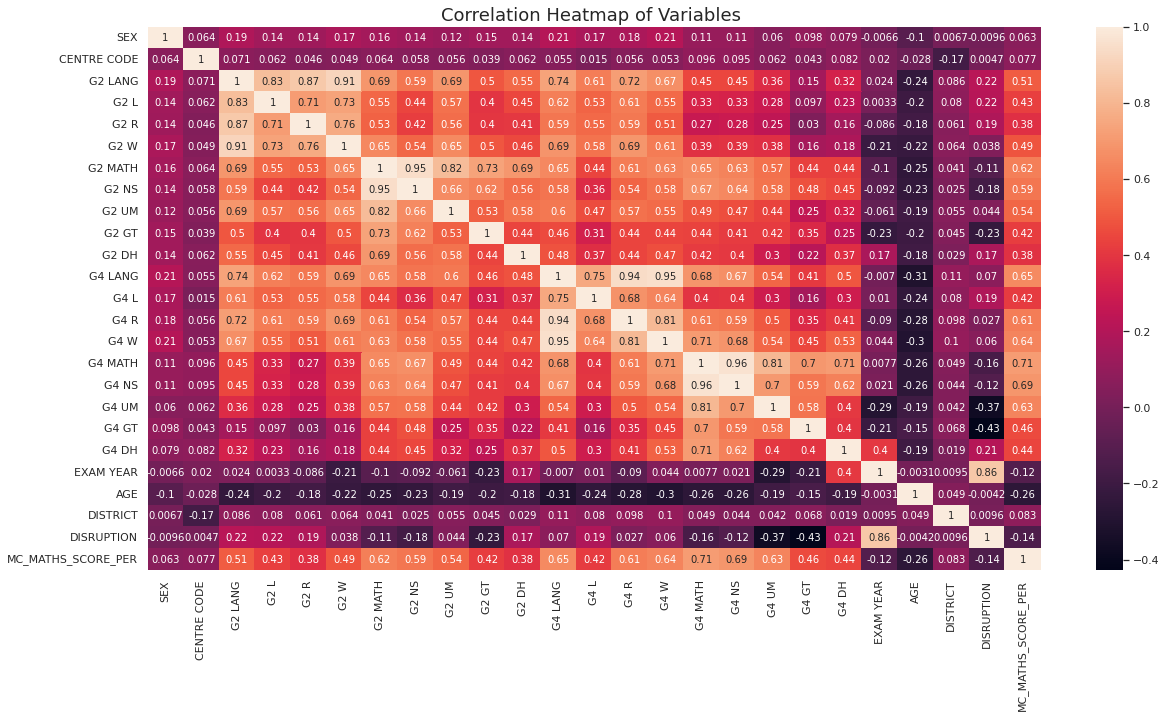

In [ ]:
#Produce a correlation matrix and project it as a heatmap
math_corr_mat = math_var.corr()
fig, ax = plt.subplots(figsize=(20,10))  
sns.heatmap(math_corr_mat, annot=True, ax=ax)
plt.title("Correlation Heatmap of Variables ", fontsize=18)
#Export the graph as a file in Google Drive
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/First Correlation Heatmap.png', bbox_inches='tight')
plt.show()

In [ ]:
#Save the correlation scores to a DataFrame and Export to an Excel File for documentation
math_corr_pd = pd.DataFrame(math_corr_mat['MC_MATHS_SCORE_PER'].sort_values(ascending=False))
math_corr_pd.reset_index(inplace=True)
math_corr_pd.columns = ['Variable Names', 'Correlation Score']
math_corr_pd.to_excel('/content/drive/My Drive/Compiled Data /Tables/Math Variables Correlation.xlsx', sheet_name='sheet1', index=False)
math_corr_pd

Variable Names  Correlation Score
0   MC_MATHS_SCORE_PER           1.000000
1              G4 MATH           0.712095
2                G4 NS           0.690914
3              G4 LANG           0.649902
4                 G4 W           0.637206
5                G4 UM           0.634250
6              G2 MATH           0.616717
7                 G4 R           0.612461
8                G2 NS           0.590981
9                G2 UM           0.537790
10             G2 LANG           0.513790
11                G2 W           0.490729
12               G4 GT           0.463342
13               G4 DH           0.443503
14                G2 L           0.429073
15               G2 GT           0.422214
16                G4 L           0.418925
17               G2 DH           0.382320
18                G2 R           0.378411
19            DISTRICT           0.083349
20         CENTRE CODE           0.077187
21                 SEX           0.062853
22           EXAM YEAR          -0.120513
23          DISRUPTION          -0.135813
24                 AGE          -0.255258

We now explore the results above using scatterplots.

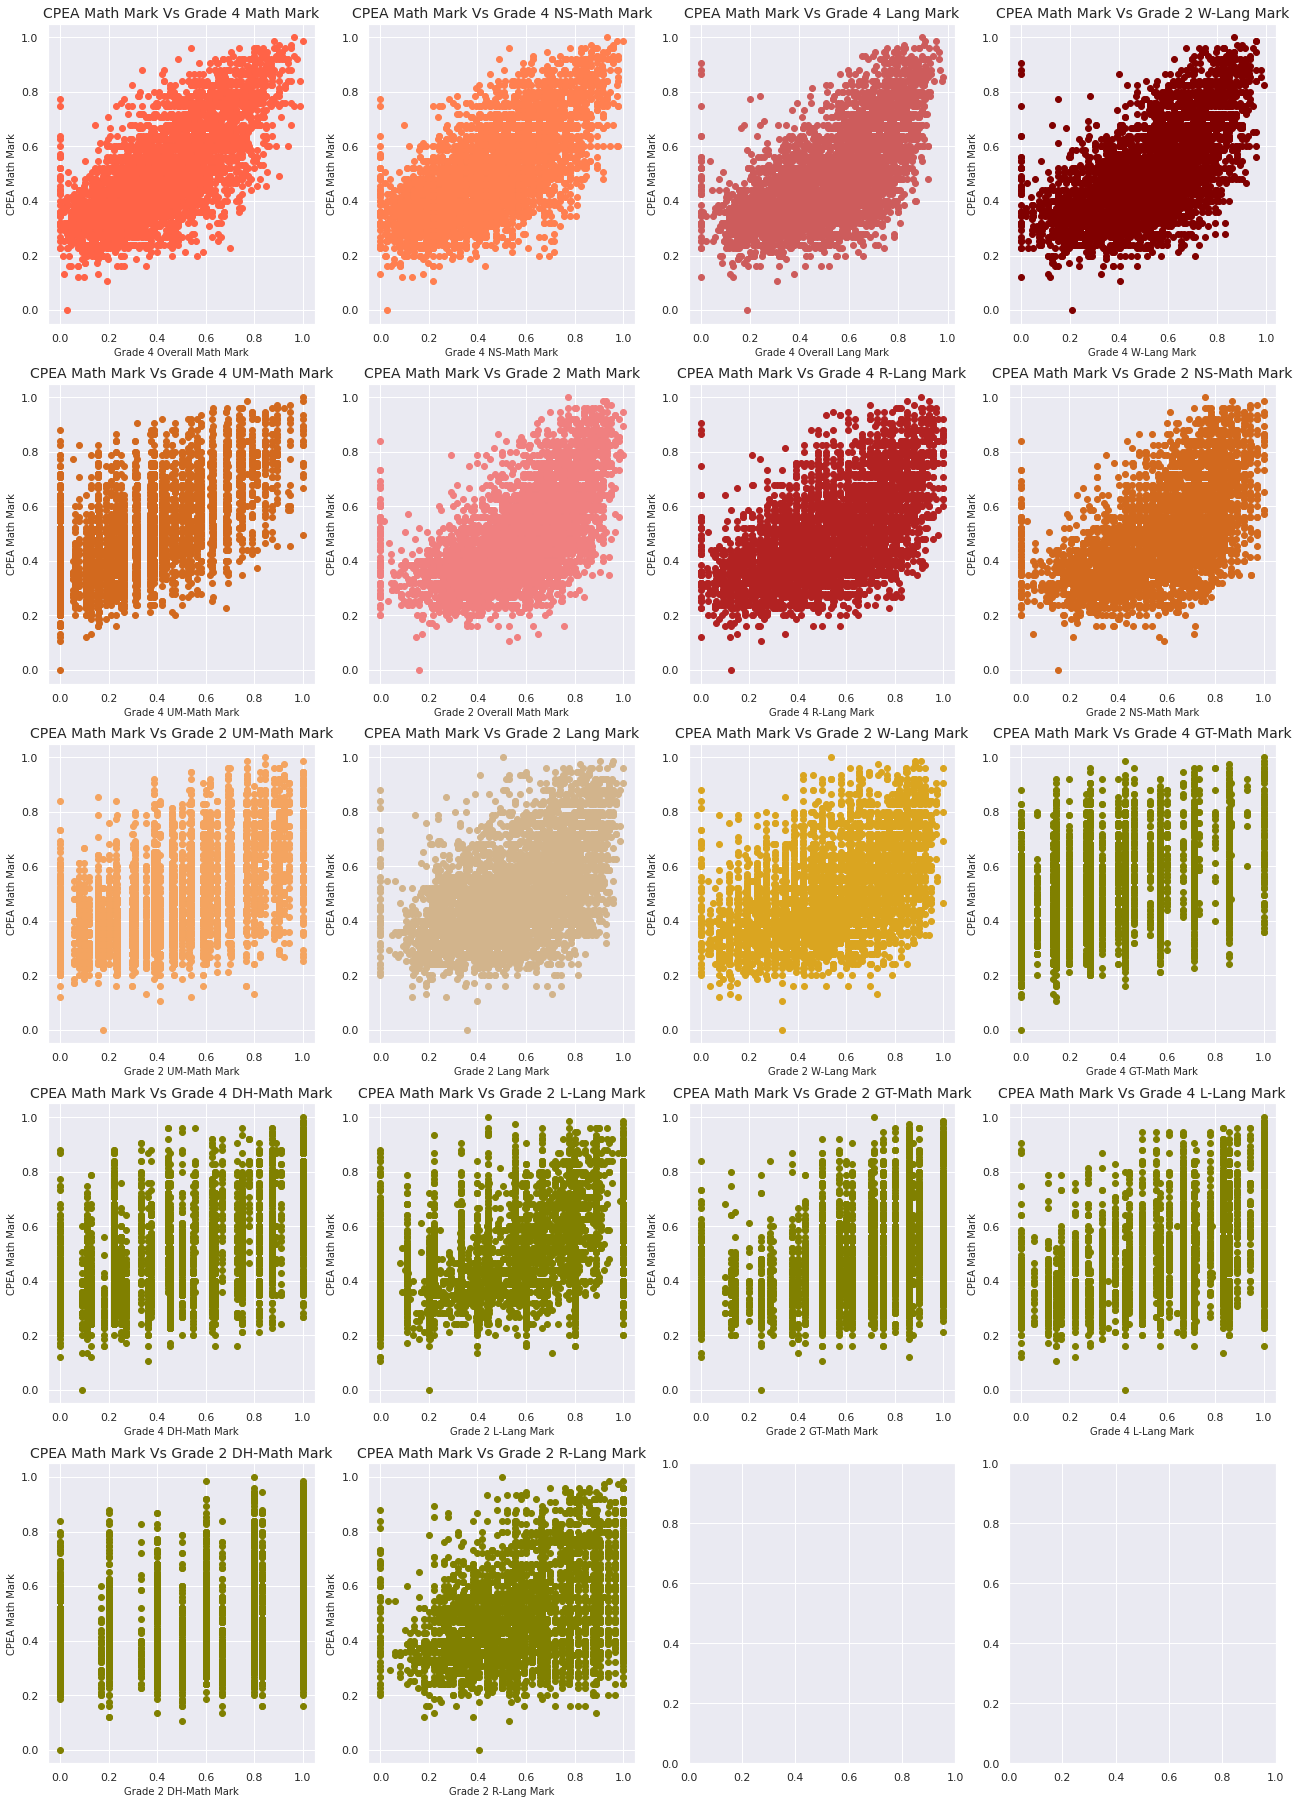

In [ ]:
#Plot grid of scatterplots to explore the relationship between the response variable and a number of features
fig, axs = plt.subplots(5, 4, figsize=(22,32))

#Plot 1
axs[0,0].scatter(df['G4 MATH'], df['MC_MATHS_SCORE_PER'], color='tomato')
axs[0,0].set_title('CPEA Math Mark Vs Grade 4 Math Mark', fontsize=14)
axs[0,0].set_xlabel('Grade 4 Overall Math Mark', fontsize=10)
axs[0,0].set_ylabel('CPEA Math Mark', fontsize=10)
axs[0,0].grid(True)


#Plot 2
axs[0,1].scatter(df['G4 NS'], df['MC_MATHS_SCORE_PER'], color='coral')
axs[0,1].set_title('CPEA Math Mark Vs Grade 4 NS-Math Mark', fontsize=14)
axs[0,1].set_xlabel('Grade 4 NS-Math Mark', fontsize=10)
axs[0,1].set_ylabel('CPEA Math Mark', fontsize=10)
axs[0,1].grid(True)


#Plot 3
axs[0,2].scatter(df['G4 LANG'], df['MC_MATHS_SCORE_PER'], color='indianred')
axs[0,2].set_title('CPEA Math Mark Vs Grade 4 Lang Mark', fontsize=14)
axs[0,2].set_xlabel('Grade 4 Overall Lang Mark', fontsize=10)
axs[0,2].set_ylabel('CPEA Math Mark', fontsize=10)
axs[0,2].grid(True)



#Plot 4
axs[0,3].scatter(df['G4 W'], df['MC_MATHS_SCORE_PER'], color='maroon')
axs[0,3].set_title('CPEA Math Mark Vs Grade 2 W-Lang Mark', fontsize=14)
axs[0,3].set_xlabel('Grade 4 W-Lang Mark', fontsize=10)
axs[0,3].set_ylabel('CPEA Math Mark', fontsize=10)
axs[0,3].grid(True)


#Plot 5
axs[1,0].scatter(df['G4 UM'], df['MC_MATHS_SCORE_PER'], color='chocolate')
axs[1,0].set_title('CPEA Math Mark Vs Grade 4 UM-Math Mark', fontsize=14)
axs[1,0].set_xlabel('Grade 4 UM-Math Mark', fontsize=10)
axs[1,0].set_ylabel('CPEA Math Mark', fontsize=10)
axs[1,0].grid(True)


#Plot 6
axs[1,1].scatter(df['G2 MATH'], df['MC_MATHS_SCORE_PER'], color='lightcoral')
axs[1,1].set_title('CPEA Math Mark Vs Grade 2 Math Mark', fontsize=14)
axs[1,1].set_xlabel('Grade 2 Overall Math Mark', fontsize=10)
axs[1,1].set_ylabel('CPEA Math Mark', fontsize=10)
axs[1,1].grid(True)



#Plot 7
axs[1,2].scatter(df['G4 R'], df['MC_MATHS_SCORE_PER'], color='firebrick')
axs[1,2].set_title('CPEA Math Mark Vs Grade 4 R-Lang Mark', fontsize=14)
axs[1,2].set_xlabel('Grade 4 R-Lang Mark', fontsize=10)
axs[1,2].set_ylabel('CPEA Math Mark', fontsize=10)
axs[1,2].grid(True)


#Plot 8
axs[1,3].scatter(df['G2 NS'], df['MC_MATHS_SCORE_PER'], color='chocolate')
axs[1,3].set_title('CPEA Math Mark Vs Grade 2 NS-Math Mark', fontsize=14)
axs[1,3].set_xlabel('Grade 2 NS-Math Mark', fontsize=10)
axs[1,3].set_ylabel('CPEA Math Mark', fontsize=10)
axs[1,3].grid(True)


#Plot 9
axs[2,0].scatter(df['G2 UM'], df['MC_MATHS_SCORE_PER'], color='sandybrown')
axs[2,0].set_title('CPEA Math Mark Vs Grade 2 UM-Math Mark', fontsize=14)
axs[2,0].set_xlabel('Grade 2 UM-Math Mark', fontsize=10)
axs[2,0].set_ylabel('CPEA Math Mark', fontsize=10)
axs[2,0].grid(True)


#Plot 10
axs[2,1].scatter(df['G2 LANG'], df['MC_MATHS_SCORE_PER'], color='tan')
axs[2,1].set_title('CPEA Math Mark Vs Grade 2 Lang Mark', fontsize=14)
axs[2,1].set_xlabel('Grade 2 Lang Mark', fontsize=10)
axs[2,1].set_ylabel('CPEA Math Mark', fontsize=10)
axs[2,1].grid(True)

#Plot 11
axs[2,2].scatter(df['G2 W'], df['MC_MATHS_SCORE_PER'], color='goldenrod')
axs[2,2].set_title('CPEA Math Mark Vs Grade 2 W-Lang Mark', fontsize=14)
axs[2,2].set_xlabel('Grade 2 W-Lang Mark', fontsize=10)
axs[2,2].set_ylabel('CPEA Math Mark', fontsize=10)
axs[2,2].grid(True)

#Plot 12
axs[2,3].scatter(df['G4 GT'], df['MC_MATHS_SCORE_PER'], color='olive')
axs[2,3].set_title('CPEA Math Mark Vs Grade 4 GT-Math Mark', fontsize=14)
axs[2,3].set_xlabel('Grade 4 GT-Math Mark', fontsize=10)
axs[2,3].set_ylabel('CPEA Math Mark', fontsize=10)
axs[2,3].grid(True)


axs[3,0].scatter(df['G4 DH'], df['MC_MATHS_SCORE_PER'], color='olive')
axs[3,0].set_title('CPEA Math Mark Vs Grade 4 DH-Math Mark', fontsize=14)
axs[3,0].set_xlabel('Grade 4 DH-Math Mark', fontsize=10)
axs[3,0].set_ylabel('CPEA Math Mark', fontsize=10)
axs[3,0].grid(True)

axs[3,1].scatter(df['G2 L'], df['MC_MATHS_SCORE_PER'], color='olive')
axs[3,1].set_title('CPEA Math Mark Vs Grade 2 L-Lang Mark', fontsize=14)
axs[3,1].set_xlabel('Grade 2 L-Lang Mark', fontsize=10)
axs[3,1].set_ylabel('CPEA Math Mark', fontsize=10)
axs[3,1].grid(True)

axs[3,2].scatter(df['G2 GT'], df['MC_MATHS_SCORE_PER'], color='olive')
axs[3,2].set_title('CPEA Math Mark Vs Grade 2 GT-Math Mark', fontsize=14)
axs[3,2].set_xlabel('Grade 2 GT-Math Mark', fontsize=10)
axs[3,2].set_ylabel('CPEA Math Mark', fontsize=10)
axs[3,2].grid(True)

axs[3,3].scatter(df['G4 L'], df['MC_MATHS_SCORE_PER'], color='olive')
axs[3,3].set_title('CPEA Math Mark Vs Grade 4 L-Lang Mark', fontsize=14)
axs[3,3].set_xlabel('Grade 4 L-Lang Mark', fontsize=10)
axs[3,3].set_ylabel('CPEA Math Mark', fontsize=10)
axs[3,3].grid(True)

axs[4,0].scatter(df['G2 DH'], df['MC_MATHS_SCORE_PER'], color='olive')
axs[4,0].set_title('CPEA Math Mark Vs Grade 2 DH-Math Mark', fontsize=14)
axs[4,0].set_xlabel('Grade 2 DH-Math Mark', fontsize=10)
axs[4,0].set_ylabel('CPEA Math Mark', fontsize=10)
axs[4,0].grid(True)

axs[4,1].scatter(df['G2 R'], df['MC_MATHS_SCORE_PER'], color='olive')
axs[4,1].set_title('CPEA Math Mark Vs Grade 2 R-Lang Mark', fontsize=14)
axs[4,1].set_xlabel('Grade 2 R-Lang Mark', fontsize=10)
axs[4,1].set_ylabel('CPEA Math Mark', fontsize=10)
axs[4,1].grid(True)
#Export the graph as a file in Google Drive
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/Scatter Plot Grid.png', bbox_inches='tight')
plt.show()

In [ ]:
#Apply transformations to non-linear relationships
#Because they are all convex shaped, the suitable transformation would be an exponential transformation
math_var['G4 LANG EXP'] = np.exp(df['G4 LANG'])
math_var['G4 W EXP'] = np.exp(df['G4 W'])
math_var['G2 MATH EXP'] = np.exp(df['G2 MATH'])
math_var['G4 R EXP'] = np.exp(df['G4 R'])
math_var['G2 NS EXP'] = np.exp(df['G2 NS'])
math_var['G2 LANG EXP'] = np.exp(df['G2 LANG'])
math_var['G2 W EXP'] = np.exp(df['G2 W'])
math_var['G2 L EXP'] = np.exp(df['G2 L'])
math_var['G2 GT EXP']= np.exp(df['G2 GT'])





In [ ]:
df['MC_MATHS_SCORE_PER'].describe()

count    4641.000000
mean        0.495609
std         0.164995
min         0.000000
25%         0.360000
50%         0.466667
75%         0.600000
max         1.000000
Name: MC_MATHS_SCORE_PER, dtype: float64

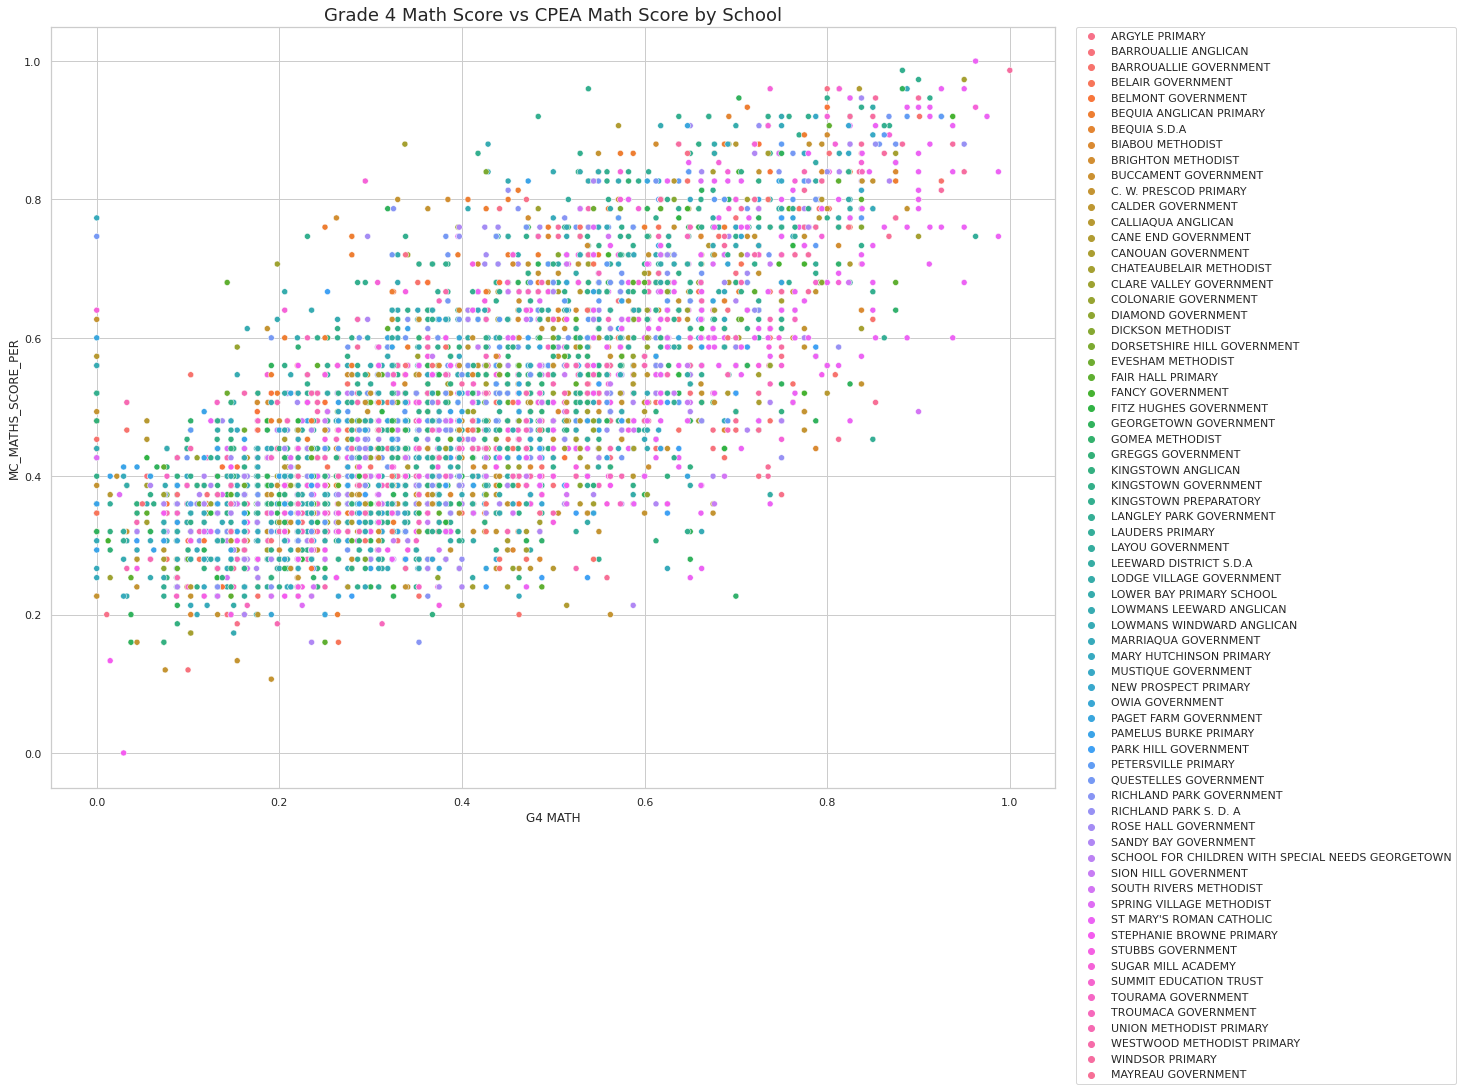

In [ ]:
#Grade 4 Math Score vs CPEA Math Score by School
plt.rcParams["figure.figsize"] = (18,14)
sns.set_theme(style="whitegrid")
sns.scatterplot(x='G4 MATH', y='MC_MATHS_SCORE_PER', data=df, hue='SCHOOL', legend="auto")
plt.title("Grade 4 Math Score vs CPEA Math Score by School", fontsize=18)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
#Export the graph as a file in Google Drive
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/Grade 4 Math Score vs CPEA Math Score by School.png', bbox_inches='tight')
plt.show()


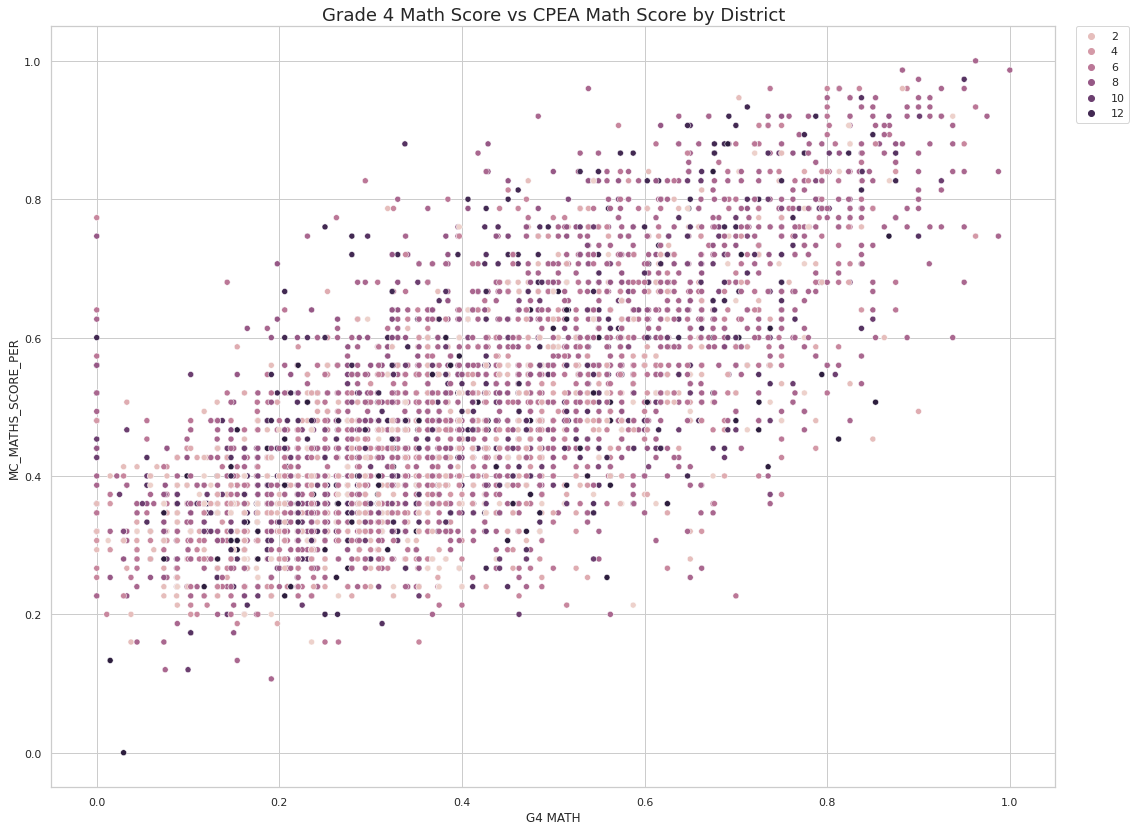

In [ ]:
#Plot Grade 4 Math Score vs CPEA Math Score by District
plt.rcParams["figure.figsize"] = (18,14)
sns.set_theme(style="whitegrid")
sns.scatterplot(x='G4 MATH', y='MC_MATHS_SCORE_PER', data=df, hue='DISTRICT', legend="auto")
plt.title("Grade 4 Math Score vs CPEA Math Score by District", fontsize=18)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
#Export the graph as a file in Google Drive
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/Grade 4 Math Score vs CPEA Math Score by District.png', bbox_inches='tight')
plt.show()


No handles with labels found to put in legend.


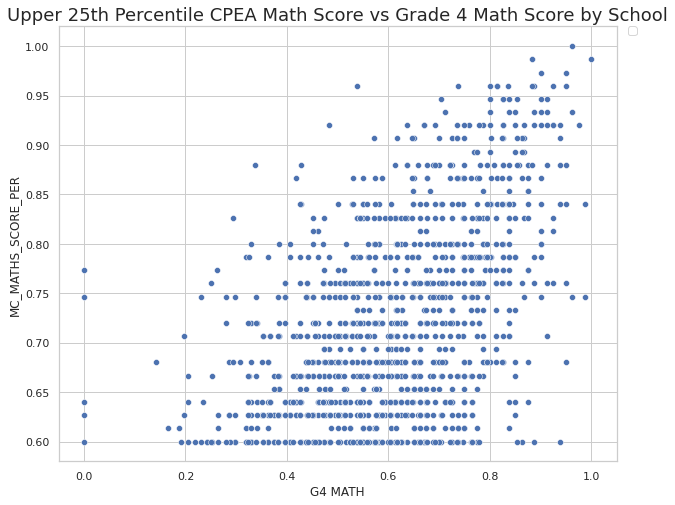

In [ ]:
#Plot upper 25th percentile of CPEA Math scores against their Grade 4 Math scores
plt.rcParams["figure.figsize"] = (10,8)
math_upper25 = df[df['MC_MATHS_SCORE_PER']>=0.6]
sns.scatterplot('G4 MATH','MC_MATHS_SCORE_PER', data=math_upper25, legend="auto")
plt.title("Upper 25th Percentile CPEA Math Score vs Grade 4 Math Score by School", fontsize=18)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
#Export the graph as a file in Google Drive
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/Upper 25th Percentile.png', bbox_inches='tight')
plt.show()


Get a count of student population at each level

In [ ]:
c1 = df[(df['EXAM YEAR']==2019)]
c2= df[(df['EXAM YEAR']==2020)]
c3 = df[(df['EXAM YEAR']==2021)]

In [ ]:
g2_school_counts_c1 = pd.DataFrame(c1['G2 SCHOOL'].value_counts())
g2_school_counts_c1 = g2_school_counts_c1.reset_index()
g2_school_counts_c1.rename(columns = {'index':'School', 'G2 SCHOOL':'G2 Total'}, inplace = True)

g2_school_counts_c2 = pd.DataFrame(c2['G2 SCHOOL'].value_counts())
g2_school_counts_c2 = g2_school_counts_c2.reset_index()
g2_school_counts_c2.rename(columns = {'index':'School', 'G2 SCHOOL':'G2 Total'}, inplace = True)

g2_school_counts_c3 = pd.DataFrame(c3['G2 SCHOOL'].value_counts())
g2_school_counts_c3 = g2_school_counts_c3.reset_index()
g2_school_counts_c3.rename(columns = {'index':'School', 'G2 SCHOOL':'G2 Total'}, inplace = True)


g4_school_counts_c1 = pd.DataFrame(c1['G4 SCHOOL'].value_counts())
g4_school_counts_c1 = g4_school_counts_c1.reset_index()
g4_school_counts_c1.rename(columns = {'index':'School', 'G4 SCHOOL':'G4 Total'}, inplace = True)

g4_school_counts_c2 = pd.DataFrame(c2['G4 SCHOOL'].value_counts())
g4_school_counts_c2 = g4_school_counts_c2.reset_index()
g4_school_counts_c2.rename(columns = {'index':'School', 'G4 SCHOOL':'G4 Total'}, inplace = True)

g4_school_counts_c3 = pd.DataFrame(c3['G4 SCHOOL'].value_counts())
g4_school_counts_c3 = g4_school_counts_c3.reset_index()
g4_school_counts_c3.rename(columns = {'index':'School', 'G4 SCHOOL':'G4 Total'}, inplace = True)


cpea_school_counts_c1 = pd.DataFrame(c1['SCHOOL'].value_counts())
cpea_school_counts_c1 = cpea_school_counts_c1.reset_index()
cpea_school_counts_c1.rename(columns = {'index':'School', 'SCHOOL':'CPEA Total'}, inplace = True)

cpea_school_counts_c2 = pd.DataFrame(c2['SCHOOL'].value_counts())
cpea_school_counts_c2 = cpea_school_counts_c2.reset_index()
cpea_school_counts_c2.rename(columns = {'index':'School', 'SCHOOL':'CPEA Total'}, inplace = True)

cpea_school_counts_c3 = pd.DataFrame(c3['SCHOOL'].value_counts())
cpea_school_counts_c3 = cpea_school_counts_c3.reset_index()
cpea_school_counts_c3.rename(columns = {'index':'School', 'SCHOOL':'CPEA Total'}, inplace = True)


In [ ]:
cpea_school_counts_c3

School  CPEA Total
0        KINGSTOWN PREPARATORY          99
1        C. W. PRESCOD PRIMARY          92
2     ST MARY'S ROMAN CATHOLIC          79
3     LODGE VILLAGE GOVERNMENT          62
4     LOWMANS LEEWARD ANGLICAN          57
..                         ...         ...
61                BEQUIA S.D.A           6
62        NEW PROSPECT PRIMARY           5
63          MAYREAU GOVERNMENT           5
64  WESTWOOD METHODIST PRIMARY           5
65         MUSTIQUE GOVERNMENT           2

[66 rows x 2 columns]

In [ ]:
#Creat a series of box and whisker plots of schools' CPEA Math scores
#First we divide the schools into 4 groups, then plot each group separately to produce a neat chart that can easily fit on a letter size sheet in the worded document

set1 = ['ARGYLE PRIMARY', 'BARROUALLIE ANGLICAN', 'BARROUALLIE GOVERNMENT','BELAIR GOVERNMENT', 'BELMONT GOVERNMENT','BEQUIA ANGLICAN PRIMARY', 'BEQUIA S.D.A', 'BIABOU METHODIST',
       'BRIGHTON METHODIST', 'BUCCAMENT GOVERNMENT', 'C. W. PRESCOD PRIMARY', 'CALDER GOVERNMENT', 'CALLIAQUA ANGLICAN','CANE END GOVERNMENT', 'CANOUAN GOVERNMENT',
       'CHATEAUBELAIR METHODIST', 'CLARE VALLEY GOVERNMENT']

set2 = ['COLONARIE GOVERNMENT', 'DIAMOND GOVERNMENT', 'DICKSON METHODIST','DORSETSHIRE HILL GOVERNMENT', 'EVESHAM METHODIST','FAIR HALL PRIMARY', 'FANCY GOVERNMENT', 'FITZ HUGHES GOVERNMENT',
       'GEORGETOWN GOVERNMENT', 'GOMEA METHODIST', 'GREGGS GOVERNMENT','KINGSTOWN ANGLICAN', 'KINGSTOWN GOVERNMENT','KINGSTOWN PREPARATORY', 'LANGLEY PARK GOVERNMENT',
       'LAUDERS PRIMARY', 'LAYOU GOVERNMENT']

set3 = ['LEEWARD DISTRICT S.D.A','LODGE VILLAGE GOVERNMENT', 'LOWER BAY PRIMARY SCHOOL','LOWMANS LEEWARD ANGLICAN', 'LOWMANS WINDWARD ANGLICAN',
       'MARRIAQUA GOVERNMENT', 'MARY HUTCHINSON PRIMARY','MUSTIQUE GOVERNMENT', 'NEW PROSPECT PRIMARY', 'OWIA GOVERNMENT','PAGET FARM GOVERNMENT', 'PAMELUS BURKE PRIMARY',
       'PARK HILL GOVERNMENT', 'PETERSVILLE PRIMARY','QUESTELLES GOVERNMENT', 'RICHLAND PARK GOVERNMENT','RICHLAND PARK S. D. A',]

set4 = ['ROSE HALL GOVERNMENT','SANDY BAY GOVERNMENT','SCHOOL FOR CHILDREN WITH SPECIAL NEEDS GEORGETOWN','SION HILL GOVERNMENT', 'SOUTH RIVERS METHODIST',
       'SPRING VILLAGE METHODIST', "ST MARY'S ROMAN CATHOLIC",'STEPHANIE BROWNE PRIMARY', 'STUBBS GOVERNMENT','SUGAR MILL ACADEMY', 'SUMMIT EDUCATION TRUST',
       'TOURAMA GOVERNMENT', 'TROUMACA GOVERNMENT','UNION METHODIST PRIMARY', 'WESTWOOD METHODIST PRIMARY','WINDSOR PRIMARY', 'MAYREAU GOVERNMENT']

d1 = df.loc[df['SCHOOL'].isin(set1)]
d2 = df.loc[df['SCHOOL'].isin(set2)]
d3 = df.loc[df['SCHOOL'].isin(set3)]
d4 = df.loc[df['SCHOOL'].isin(set4)]

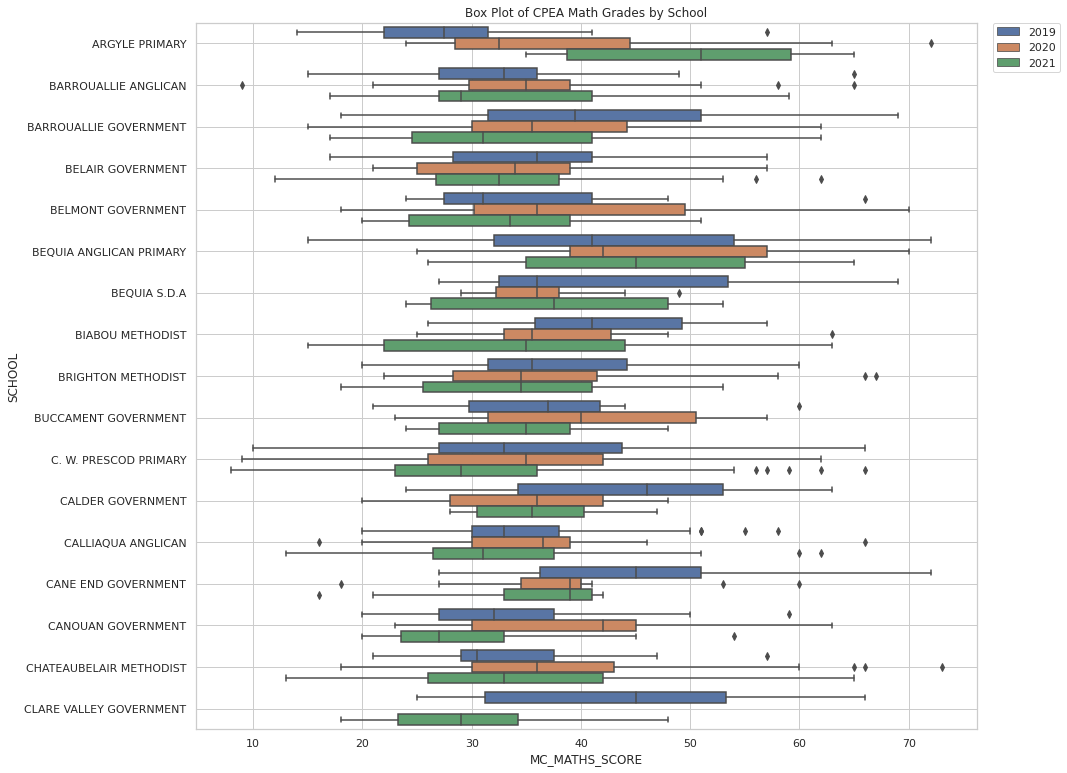

In [ ]:

plt.rcParams["figure.figsize"] = (14,13)
fig, ax = plt.subplots()
sns.boxplot(x="MC_MATHS_SCORE", y="SCHOOL",hue="EXAM YEAR", data=d1).set(title='Box Plot of CPEA Math Grades by School')
ax.grid(True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
#Export the graph as a file in Google Drive
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/Box Plot of CPEA Math Grades by School PT1.png', bbox_inches='tight')
plt.show()


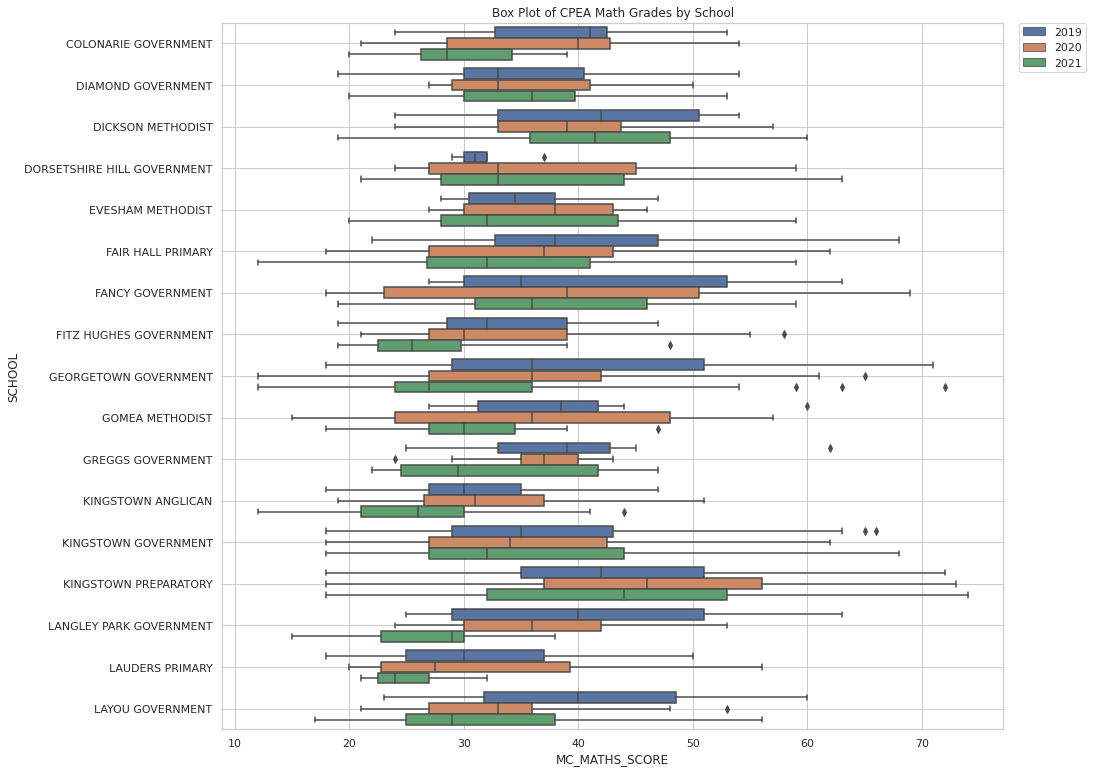

In [ ]:

plt.rcParams["figure.figsize"] = (14,13)
fig, ax = plt.subplots()
sns.boxplot(x="MC_MATHS_SCORE", y="SCHOOL",hue="EXAM YEAR", data=d2).set(title='Box Plot of CPEA Math Grades by School')
ax.grid(True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

#Export the graph as a file in Google Drive
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/Box Plot of CPEA Math Grades by School PT2.png', bbox_inches='tight')
plt.show()


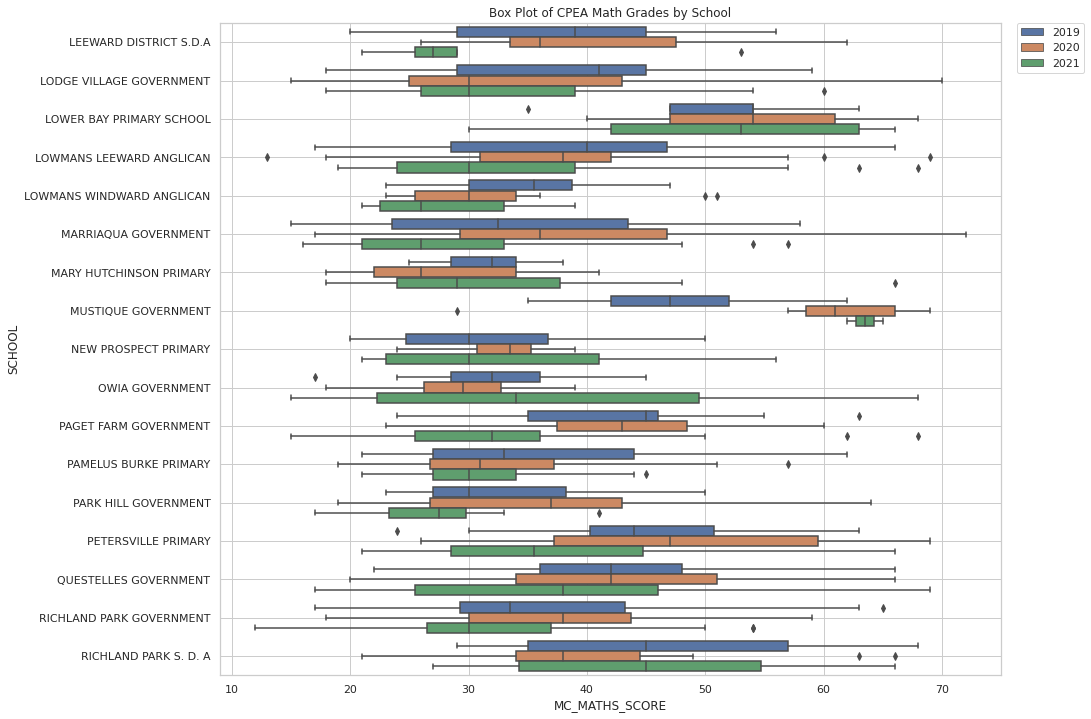

In [ ]:

plt.rcParams["figure.figsize"] = (14,12)
fig, ax = plt.subplots()
sns.boxplot(x="MC_MATHS_SCORE", y="SCHOOL",hue="EXAM YEAR", data=d3).set(title='Box Plot of CPEA Math Grades by School')
ax.grid(True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

#Export the graph as a file in Google Drive
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/Box Plot of CPEA Math Grades by School PT3.png', bbox_inches='tight')
plt.show()


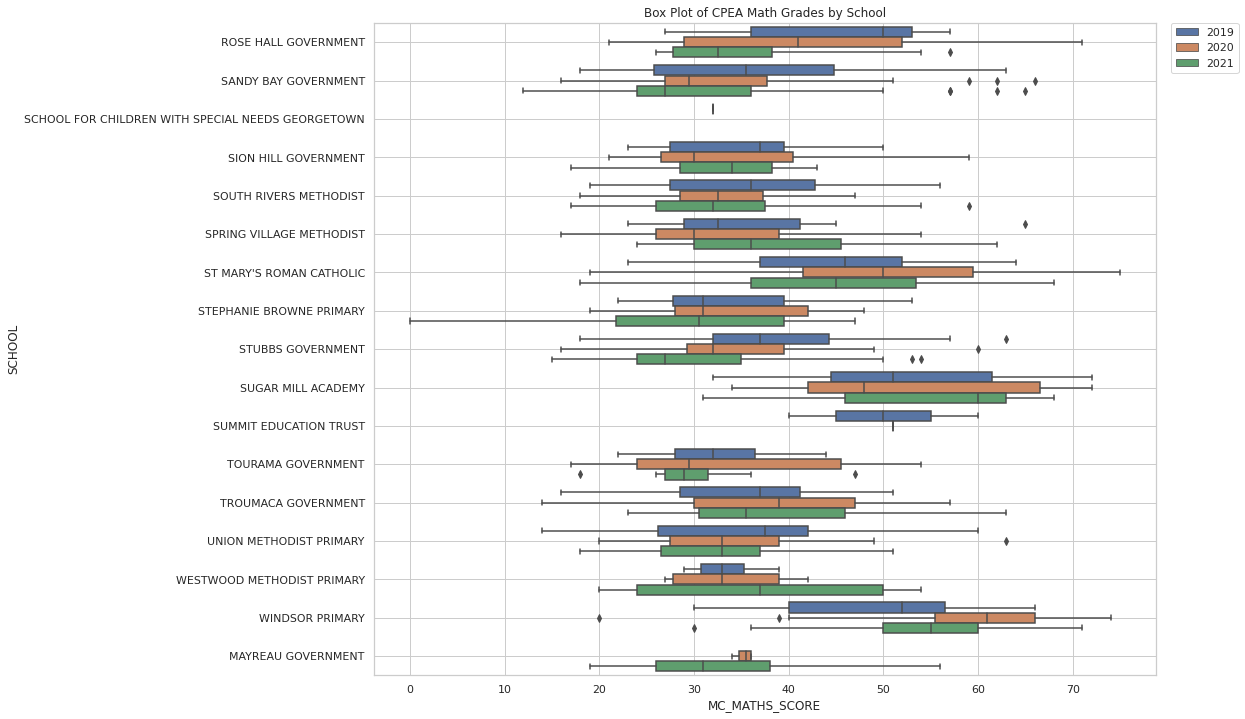

In [ ]:

plt.rcParams["figure.figsize"] = (14,12)
fig, ax = plt.subplots()
sns.boxplot(x="MC_MATHS_SCORE", y="SCHOOL",hue="EXAM YEAR", data=d4).set(title='Box Plot of CPEA Math Grades by School')
ax.grid(True)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
#Export the graph as a file in Google Drive
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/Box Plot of CPEA Math Grades by School PT4.png', bbox_inches='tight')
plt.show()


A series of distribution plots for further exploratory analysis.

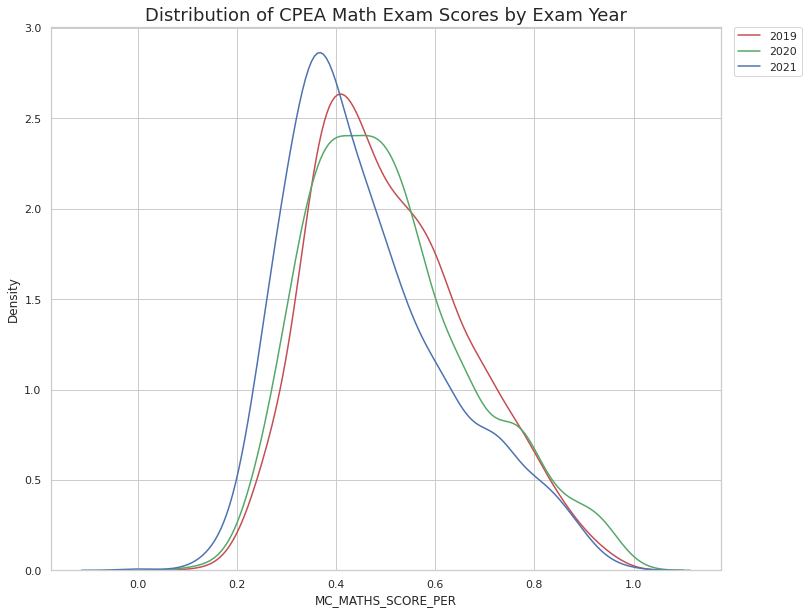

In [ ]:
#Plot distribution of Grade CPEA Math Exam Scores by Exam Year
plt.rcParams["figure.figsize"] = (12,10)
sns.distplot(df[(df['EXAM YEAR']==2019)]['MC_MATHS_SCORE_PER'],kde=True,hist=False, color = 'r', label='2019')
sns.distplot(df[(df['EXAM YEAR']==2020)]['MC_MATHS_SCORE_PER'],kde=True,hist=False, color = 'g', label='2020')
sns.distplot(df[(df['EXAM YEAR']==2021)]['MC_MATHS_SCORE_PER'],kde=True,hist=False, color='b', label='2021')
plt.title("Distribution of CPEA Math Exam Scores by Exam Year", fontsize=18)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
#Export the graph as a file in Google Drive
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/Distribution of Grade CPEA Math Exam Scores by Exam Year.png', bbox_inches='tight')
plt.show()


We go on then to plot the distibutions for the corresponding Grade 2 and Grade 4 diagnostic Math results to explore whether these variables experienced the same trend. 

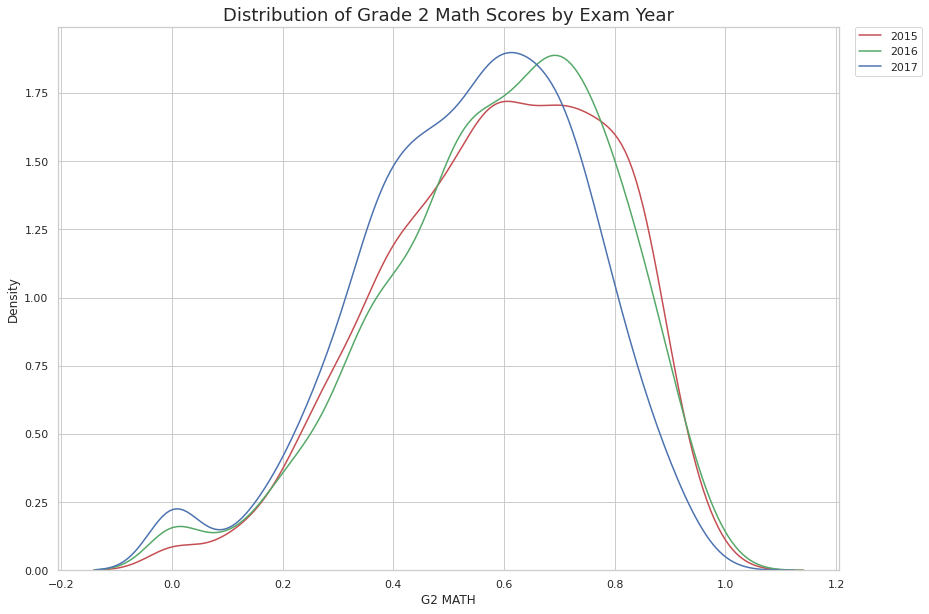

In [ ]:
#Plot distribution of Grade 2 Math Scores by Exam Year
plt.rcParams["figure.figsize"] = (14,10)
sns.distplot(df[(df['EXAM YEAR']==2019)]['G2 MATH'],kde=True,hist=False,label='2015', color = 'r')
sns.distplot(df[(df['EXAM YEAR']==2020)]['G2 MATH'],kde=True,hist=False,label='2016', color = 'g')
sns.distplot(df[(df['EXAM YEAR']==2021)]['G2 MATH'],kde=True,hist=False,label='2017', color='b')
plt.title("Distribution of Grade 2 Math Scores by Exam Year", fontsize=18)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
#Export the graph as a file in Google Drive
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/Distribution of Grade 2 Math Scores by Exam Year.png', bbox_inches='tight')
plt.show()



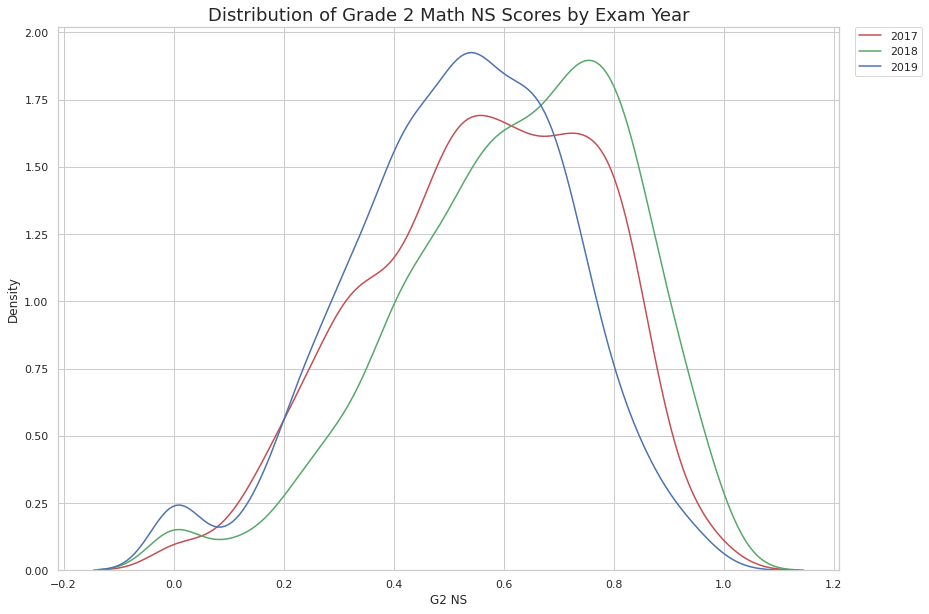

In [ ]:
# Plot distribution of Grade 2 Math NS Scores by Exam Year
sns.distplot(df[(df['EXAM YEAR']==2019)]['G2 NS'],kde=True, color = 'r',hist=False, label='2017')
sns.distplot(df[(df['EXAM YEAR']==2020)]['G2 NS'],kde=True, color = 'g',hist=False, label= '2018')
sns.distplot(df[(df['EXAM YEAR']==2021)]['G2 NS'],kde=True, color='b',hist=False, label = '2019')

plt.title("Distribution of Grade 2 Math NS Scores by Exam Year", fontsize=18)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/Distribution of Grade 2 Math NS Scores by Exam Year.png', bbox_inches='tight')
plt.show()

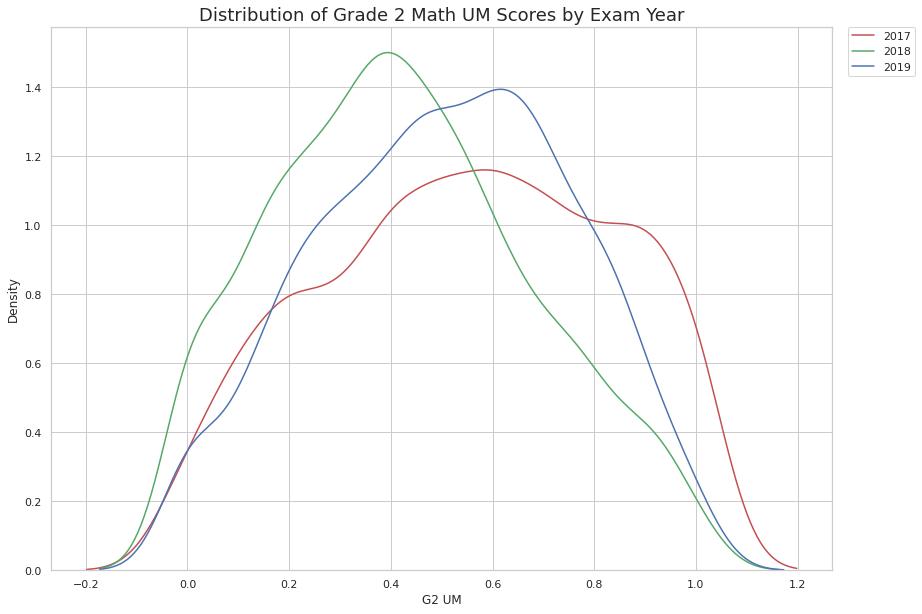

In [ ]:

sns.distplot(df[(df['EXAM YEAR']==2019)]['G2 UM'],kde=True, color = 'r',hist=False, label='2017')
sns.distplot(df[(df['EXAM YEAR']==2020)]['G2 UM'],kde=True, color = 'g',hist=False, label= '2018')
sns.distplot(df[(df['EXAM YEAR']==2021)]['G2 UM'],kde=True, color='b',hist=False, label = '2019')

plt.title("Distribution of Grade 2 Math UM Scores by Exam Year", fontsize=18)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/Distribution of Grade 2 Math UM Scores by Exam Year.png', bbox_inches='tight')
plt.show()

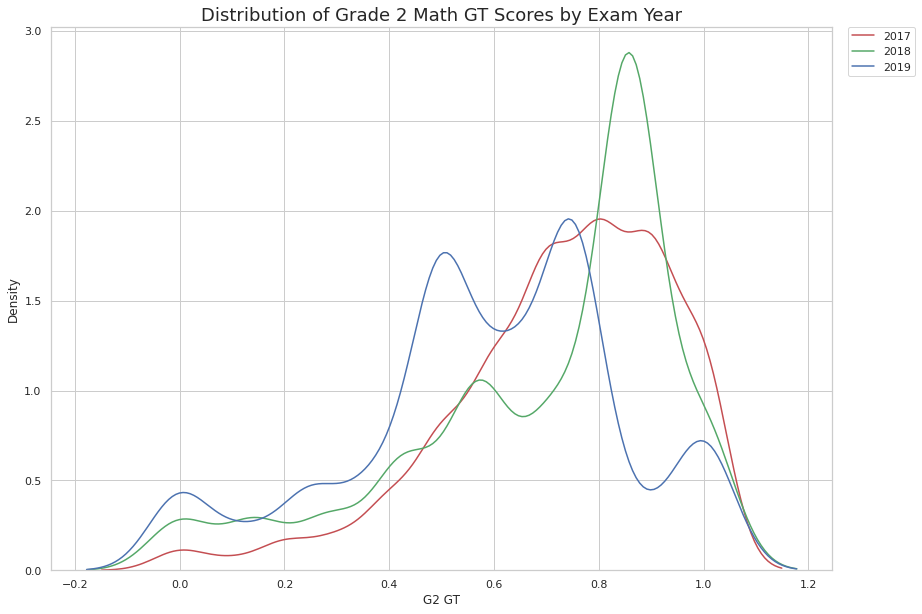

In [ ]:
sns.distplot(df[(df['EXAM YEAR']==2019)]['G2 GT'],kde=True, color = 'r',hist=False, label='2017')
sns.distplot(df[(df['EXAM YEAR']==2020)]['G2 GT'],kde=True, color = 'g',hist=False, label= '2018')
sns.distplot(df[(df['EXAM YEAR']==2021)]['G2 GT'],kde=True, color='b',hist=False, label = '2019')

plt.title("Distribution of Grade 2 Math GT Scores by Exam Year", fontsize=18)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/Distribution of Grade 2 Math GT Scores by Exam Year.png', bbox_inches='tight')
plt.show()

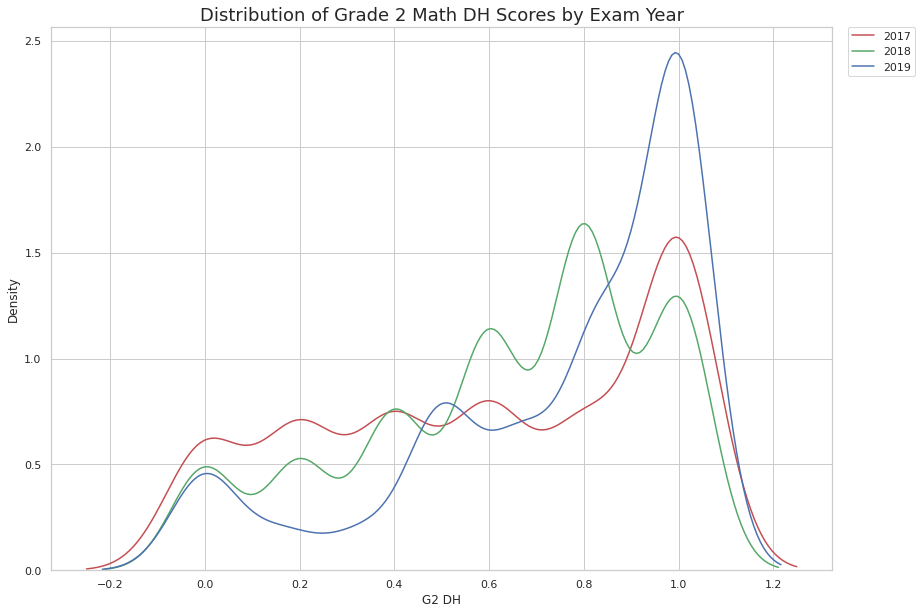

In [ ]:
sns.distplot(df[(df['EXAM YEAR']==2019)]['G2 DH'],kde=True, color = 'r',hist=False, label='2017')
sns.distplot(df[(df['EXAM YEAR']==2020)]['G2 DH'],kde=True, color = 'g',hist=False, label= '2018')
sns.distplot(df[(df['EXAM YEAR']==2021)]['G2 DH'],kde=True, color='b',hist=False, label = '2019')

plt.title("Distribution of Grade 2 Math DH Scores by Exam Year", fontsize=18)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/Distribution of Grade 2 Math DH Scores by Exam Year.png', bbox_inches='tight')
plt.show()

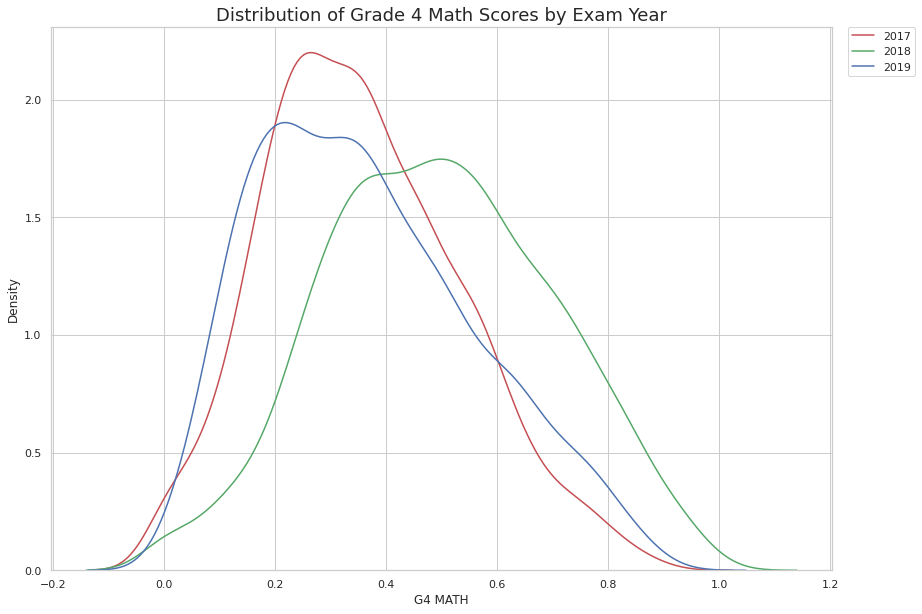

In [ ]:
sns.distplot(df[(df['EXAM YEAR']==2019)]['G4 MATH'],kde=True, color = 'r',hist=False, label='2017')
sns.distplot(df[(df['EXAM YEAR']==2020)]['G4 MATH'],kde=True, color = 'g',hist=False, label= '2018')
sns.distplot(df[(df['EXAM YEAR']==2021)]['G4 MATH'],kde=True, color='b',hist=False, label = '2019')

plt.title("Distribution of Grade 4 Math Scores by Exam Year", fontsize=18)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/Distribution of Grade 4 Math Scores by Exam Year.png', bbox_inches='tight')
plt.show()


As we examine these distributions, we see that the Grade 2 Math score experiences the same trend as the CPEA Math exam score, but with a better modal score of. On the other hand, the Grade 4 Math score experiences the slight improvement of the general student performance from 2017-2018, then falls back in 2019. The scores for this exam are typically lower than both the Grade 2 score,and CPEA Math scores. This suggests that there may be some factor/s that currently reduce student performance as they transition from Grade 2 to Grade 4.

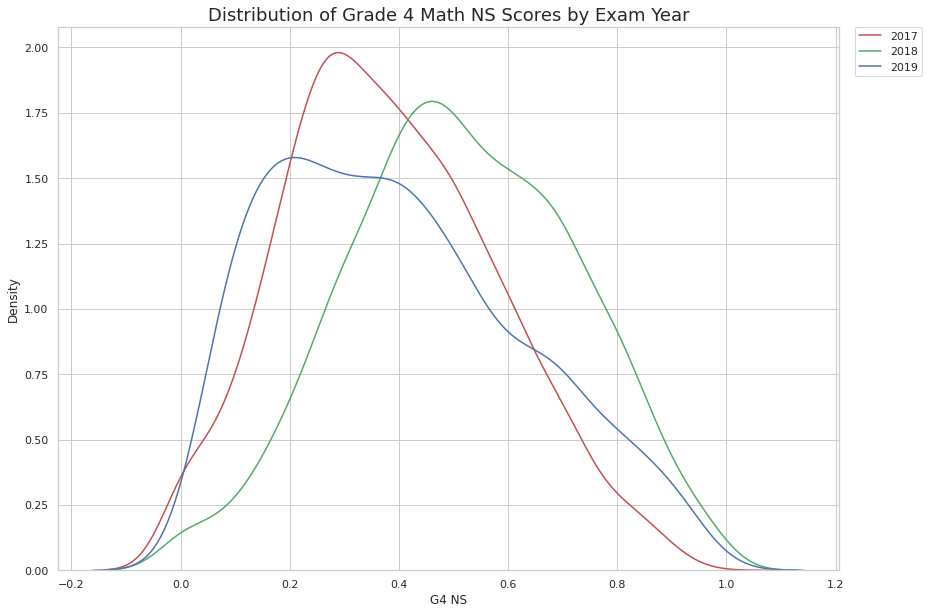

In [ ]:
sns.distplot(df[(df['EXAM YEAR']==2019)]['G4 NS'],kde=True, color = 'r',hist=False, label='2017')
sns.distplot(df[(df['EXAM YEAR']==2020)]['G4 NS'],kde=True, color = 'g',hist=False, label= '2018')
sns.distplot(df[(df['EXAM YEAR']==2021)]['G4 NS'],kde=True, color='b',hist=False, label = '2019')

plt.title("Distribution of Grade 4 Math NS Scores by Exam Year", fontsize=18)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/Distribution of Grade 4 Math NS Scores by Exam Year.png', bbox_inches='tight')
plt.show()

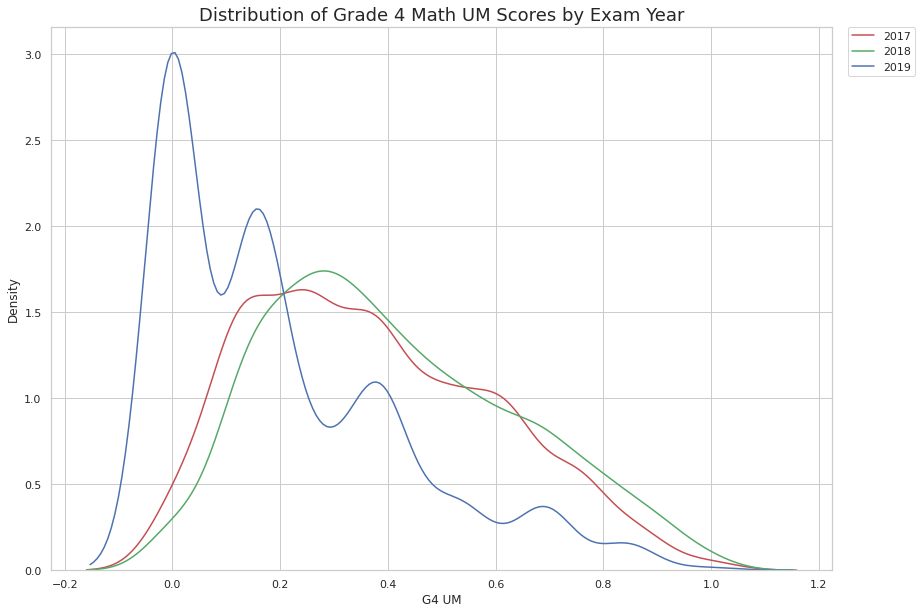

In [ ]:
sns.distplot(df[(df['EXAM YEAR']==2019)]['G4 UM'],kde=True, color = 'r',hist=False, label='2017')
sns.distplot(df[(df['EXAM YEAR']==2020)]['G4 UM'],kde=True, color = 'g',hist=False, label= '2018')
sns.distplot(df[(df['EXAM YEAR']==2021)]['G4 UM'],kde=True, color='b',hist=False, label = '2019')

plt.title("Distribution of Grade 4 Math UM Scores by Exam Year", fontsize=18)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/Distribution of Grade 4 Math UM Scores by Exam Year.png', bbox_inches='tight')
plt.show()

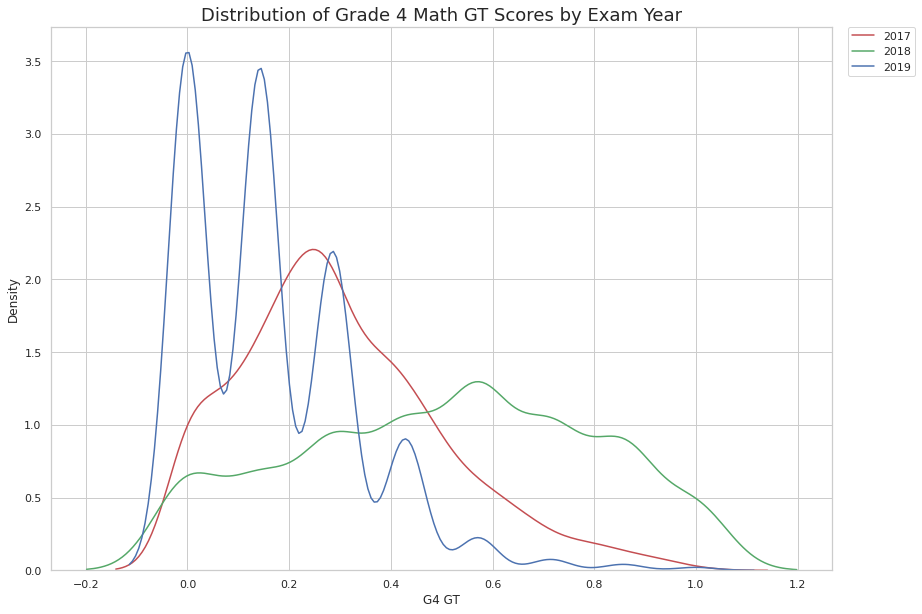

In [ ]:
sns.distplot(df[(df['EXAM YEAR']==2019)]['G4 GT'],kde=True, color = 'r',hist=False, label='2017')
sns.distplot(df[(df['EXAM YEAR']==2020)]['G4 GT'],kde=True, color = 'g',hist=False, label= '2018')
sns.distplot(df[(df['EXAM YEAR']==2021)]['G4 GT'],kde=True, color='b',hist=False, label = '2019')

plt.title("Distribution of Grade 4 Math GT Scores by Exam Year", fontsize=18)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/Distribution of Grade 4 Math GT Scores by Exam Year.png', bbox_inches='tight')
plt.show()

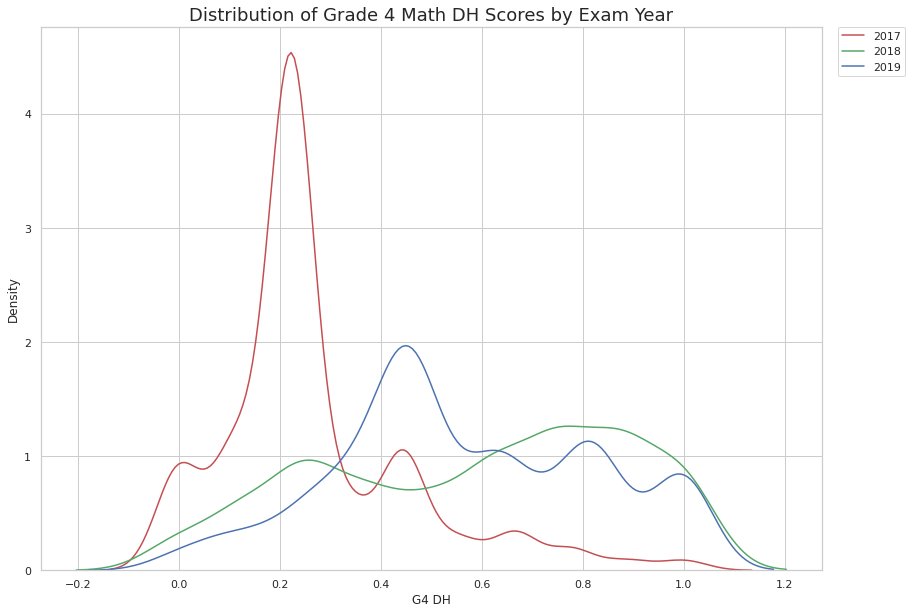

In [ ]:
sns.distplot(df[(df['EXAM YEAR']==2019)]['G4 DH'],kde=True, color = 'r',hist=False, label='2017')
sns.distplot(df[(df['EXAM YEAR']==2020)]['G4 DH'],kde=True, color = 'g',hist=False, label= '2018')
sns.distplot(df[(df['EXAM YEAR']==2021)]['G4 DH'],kde=True, color='b',hist=False, label = '2019')

plt.title("Distribution of Grade 4 Math DH Scores by Exam Year", fontsize=18)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/Distribution of Grade 4 Math DH Scores by Exam Year.png', bbox_inches='tight')
plt.show()

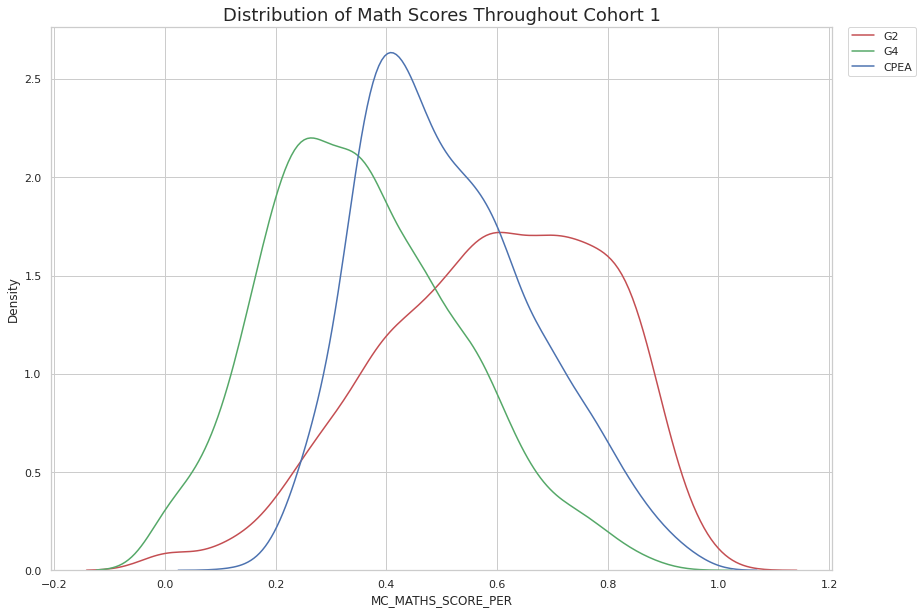

In [ ]:
plt.rcParams["figure.figsize"] = (14,10)
sns.distplot(df[(df['EXAM YEAR']==2019)]['G2 MATH'],kde=True,hist=False,label='G2', color = 'r')
sns.distplot(df[(df['EXAM YEAR']==2019)]['G4 MATH'],kde=True,hist=False,label='G4', color = 'g')
sns.distplot(df[(df['EXAM YEAR']==2019)]['MC_MATHS_SCORE_PER'],kde=True,hist=False,label='CPEA', color='b')
plt.title("Distribution of Math Scores Throughout Cohort 1", fontsize=18)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/Distribution of Math Scores Throughout Cohort 3.png', bbox_inches='tight')
plt.show()

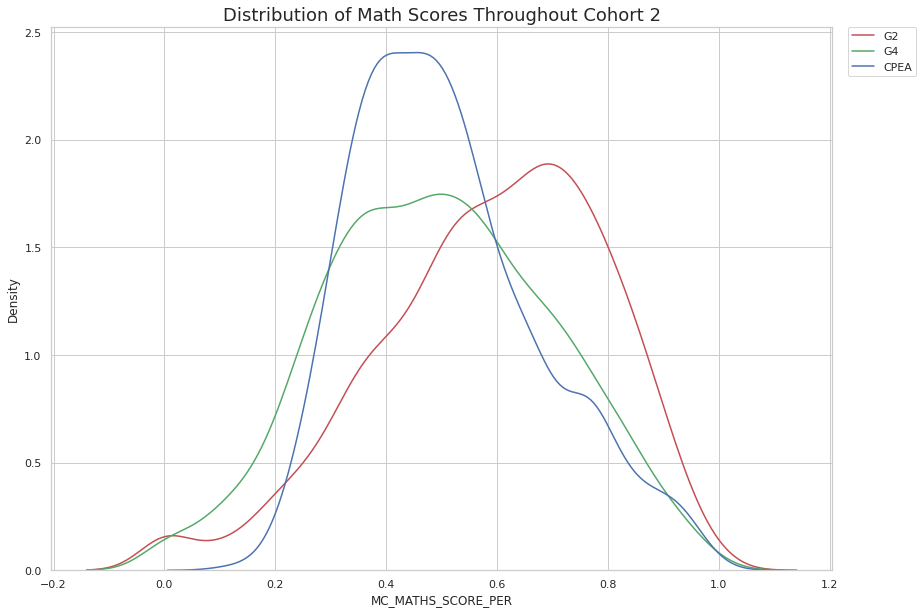

In [ ]:
plt.rcParams["figure.figsize"] = (14,10)
sns.distplot(df[(df['EXAM YEAR']==2020)]['G2 MATH'],kde=True,hist=False,label='G2', color = 'r')
sns.distplot(df[(df['EXAM YEAR']==2020)]['G4 MATH'],kde=True,hist=False,label='G4', color = 'g')
sns.distplot(df[(df['EXAM YEAR']==2020)]['MC_MATHS_SCORE_PER'],kde=True,hist=False,label='CPEA', color='b')
plt.title("Distribution of Math Scores Throughout Cohort 2", fontsize=18)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/Distribution of Math Scores Throughout Cohort 2.png', bbox_inches='tight')
plt.show()

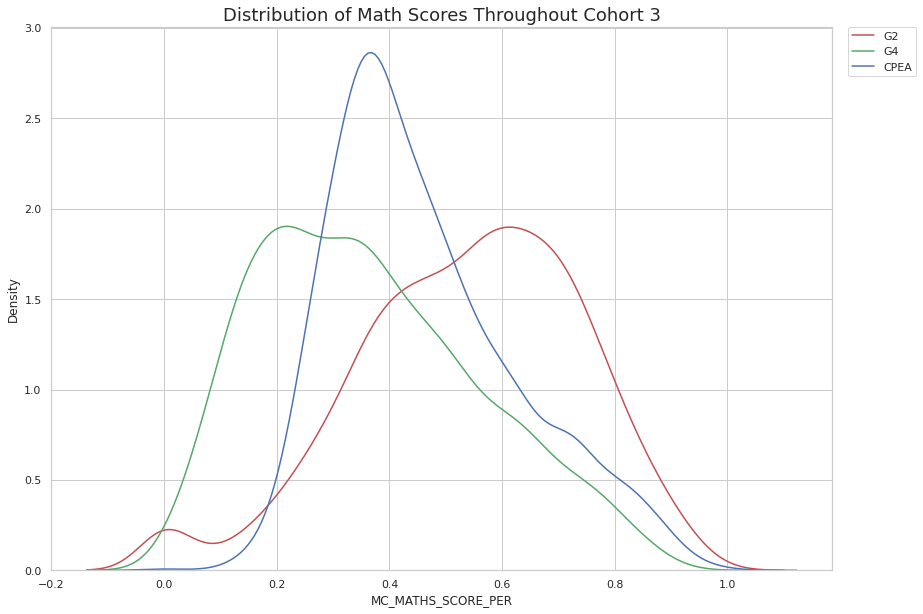

In [ ]:
plt.rcParams["figure.figsize"] = (14,10)
sns.distplot(df[(df['EXAM YEAR']==2021)]['G2 MATH'],kde=True,hist=False,label='G2', color = 'r')
sns.distplot(df[(df['EXAM YEAR']==2021)]['G4 MATH'],kde=True,hist=False,label='G4', color = 'g')
sns.distplot(df[(df['EXAM YEAR']==2021)]['MC_MATHS_SCORE_PER'],kde=True,hist=False,label='CPEA', color='b')
plt.title("Distribution of Math Scores Throughout Cohort 3", fontsize=18)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/Distribution of Math Scores Throughout Cohort 3.png', bbox_inches='tight')
plt.show()

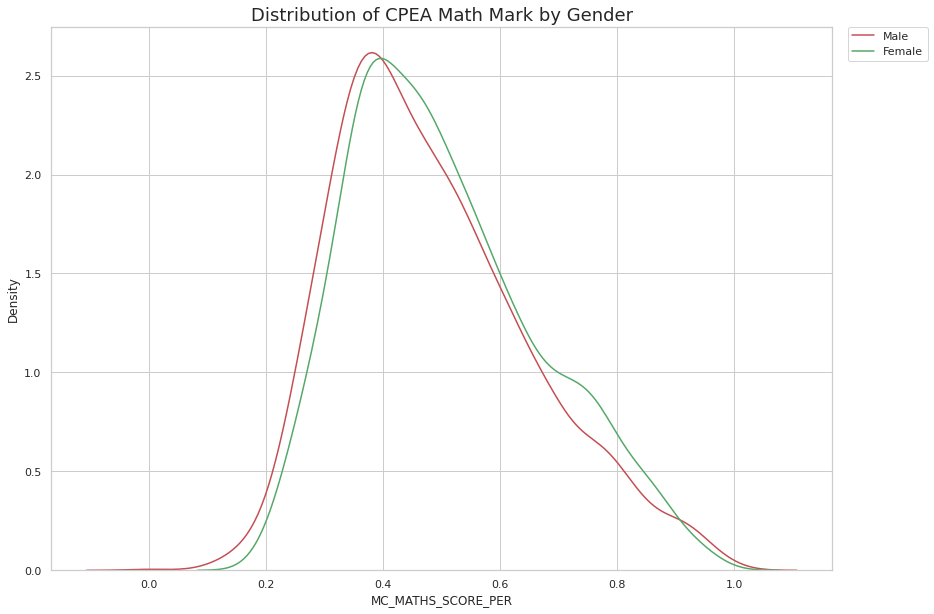

In [ ]:
plt.rcParams["figure.figsize"] = (14,10)

sns.distplot(df[(df['SEX']==0)]['MC_MATHS_SCORE_PER'],kde=True,hist = False, color = 'r', label='Male')
sns.distplot(df[(df['SEX']==1)]['MC_MATHS_SCORE_PER'],kde=True, hist = False,color = 'g', label='Female')

plt.title("Distribution of CPEA Math Mark by Gender", fontsize=18)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/Distribution of CPEA Math Mark by Gender.png', bbox_inches='tight')
plt.show()

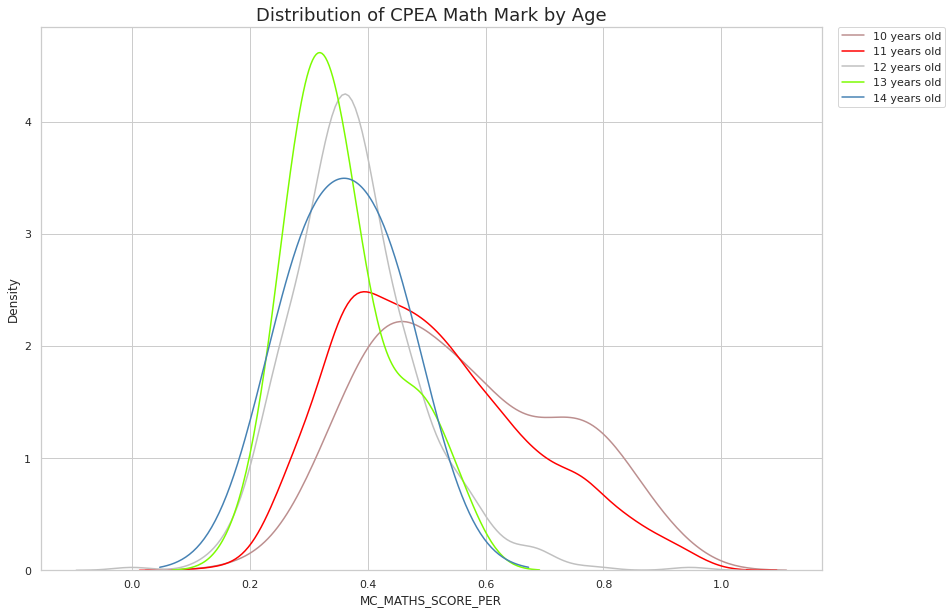

In [ ]:
plt.rcParams["figure.figsize"] = (14,10)

sns.distplot(df[(df['AGE']==9)]['MC_MATHS_SCORE_PER'],kde=True,hist=False,color = 'black', label = '9 years old')
sns.distplot(df[(df['AGE']==10)]['MC_MATHS_SCORE_PER'],kde=True,hist=False, color = 'rosybrown', label = '10 years old')
sns.distplot(df[(df['AGE']==11)]['MC_MATHS_SCORE_PER'],kde=True,hist=False, color = 'red', label = '11 years old')
sns.distplot(df[(df['AGE']==12)]['MC_MATHS_SCORE_PER'],kde=True,hist=False, color = 'silver', label = '12 years old')
sns.distplot(df[(df['AGE']==13)]['MC_MATHS_SCORE_PER'],kde=True,hist=False, color = 'lawngreen', label = '13 years old')
sns.distplot(df[(df['AGE']==14)]['MC_MATHS_SCORE_PER'],kde=True,hist=False, color = 'steelblue', label = '14 years old')
plt.title("Distribution of CPEA Math Mark by Age", fontsize=18)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/Distribution of CPEA Math Mark by Age.png', bbox_inches='tight')
plt.show()

In [ ]:
df.AGE.value_counts()

11    3996
12     492
10     126
13      36
14       2
9        1
Name: AGE, dtype: int64

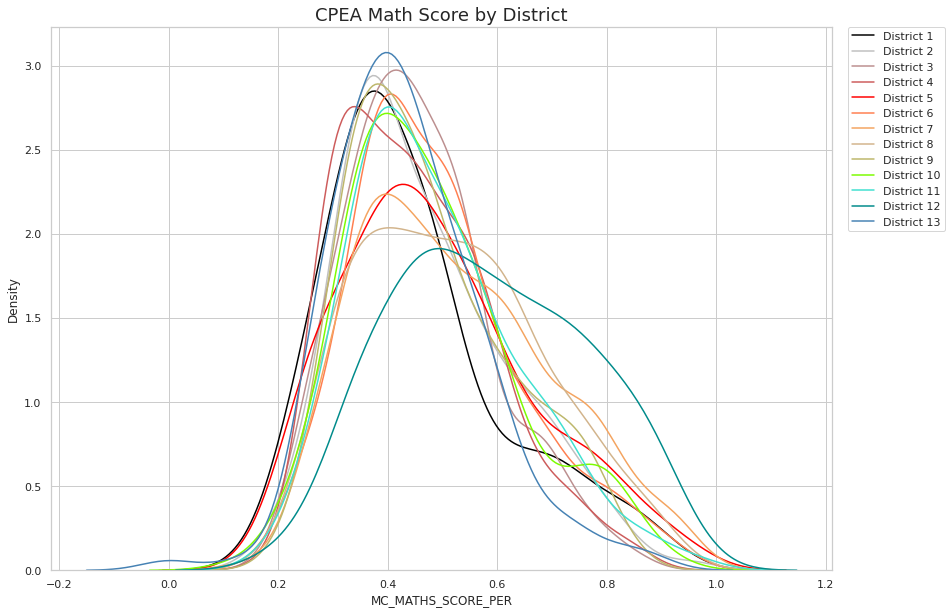

In [ ]:
sns.distplot(df[(df['DISTRICT']==1)]['MC_MATHS_SCORE_PER'],rug=False, kde=True, color = 'black',hist=False, label = "District 1")
sns.distplot(df[(df['DISTRICT']==2)]['MC_MATHS_SCORE_PER'],rug=False, kde=True, color = 'silver',hist=False, label = "District 2")
sns.distplot(df[(df['DISTRICT']==3)]['MC_MATHS_SCORE_PER'],rug=False, kde=True, color = 'rosybrown',hist=False, label = "District 3")
sns.distplot(df[(df['DISTRICT']==4)]['MC_MATHS_SCORE_PER'],rug=False, kde=True, color = 'indianred',hist=False, label = "District 4")
sns.distplot(df[(df['DISTRICT']==5)]['MC_MATHS_SCORE_PER'],rug=False, kde=True, color = 'red',hist=False, label = "District 5")
sns.distplot(df[(df['DISTRICT']==6)]['MC_MATHS_SCORE_PER'],rug=False, kde=True, color = 'coral',hist=False, label = "District 6")
sns.distplot(df[(df['DISTRICT']==7)]['MC_MATHS_SCORE_PER'],rug=False, kde=True, color = 'sandybrown',hist=False, label = "District 7")
sns.distplot(df[(df['DISTRICT']==8)]['MC_MATHS_SCORE_PER'],rug=False, kde=True, color = 'tan',hist=False, label = "District 8")
sns.distplot(df[(df['DISTRICT']==9)]['MC_MATHS_SCORE_PER'],rug=False, kde=True, color = 'darkkhaki',hist=False, label = "District 9")
sns.distplot(df[(df['DISTRICT']==10)]['MC_MATHS_SCORE_PER'],rug=False, kde=True, color = 'lawngreen',hist=False, label = "District 10")
sns.distplot(df[(df['DISTRICT']==11)]['MC_MATHS_SCORE_PER'],rug=False, kde=True, color = 'turquoise',hist=False, label = "District 11")
sns.distplot(df[(df['DISTRICT']==12)]['MC_MATHS_SCORE_PER'],rug=False, kde=True, color = 'darkcyan',hist=False, label = "District 12")
sns.distplot(df[(df['DISTRICT']==13)]['MC_MATHS_SCORE_PER'],rug=False, kde=True, color = 'steelblue',hist=False, label = "District 13")

plt.title("CPEA Math Score by District", fontsize=18)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/CPEA Math Score by District.png', bbox_inches='tight')
plt.show()


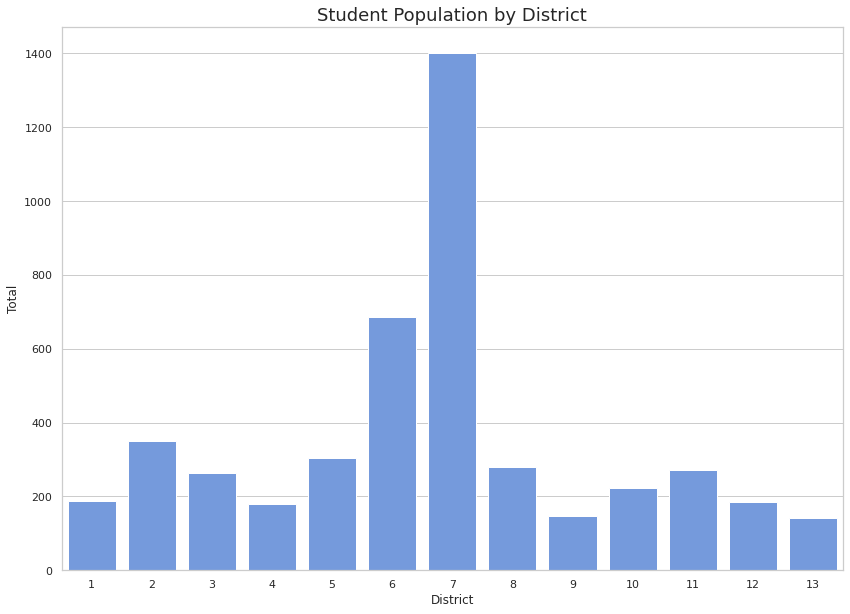

In [ ]:
#Plot population by District
district_counts = pd.DataFrame(math_var.DISTRICT.value_counts())
district_counts.reset_index(inplace=True)
district_counts.columns=['District', 'Total']
sns.barplot(x='District',y='Total', data=district_counts, color='cornflowerblue')
plt.title("Student Population by District", fontsize=18)
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/Population by District.png', bbox_inches='tight')
plt.show()

In [ ]:
#Split the features and response variable into two dataframes
math_X = math_var.copy()
math_Y= math_X['MC_MATHS_SCORE_PER']

#NB: Here we drop the remaining "object" type variables
math_X.drop(['SCHOOL','G2 SCHOOL','G4 SCHOOL','DATE OF BIRTH','EXAM DATE','EXAM DATE','MC_MATHS_SCORE_PER'],axis = 1, inplace=True)


In [ ]:
# splitting the data into train and test
x_train, x_test, y_train, y_test = train_test_split(math_X, math_Y,test_size = 0.3, random_state = 42)

In [ ]:
len(x_train)

3236

In [ ]:
len(x_test)

1387

In [ ]:
#Duplicate the x_train and x_test to creat the base model later
x_train_duplicate = x_train.copy()
x_test_duplicate = x_test.copy()

#**Feature Selection**

###**Fitting a multiple regression model to a sample of data to get coeff and p-values, and develop interaction variables to improve R-squared and Adjusted R-Squared.**

In [ ]:
x=sm.add_constant(x_train)
results=sm.OLS(y_train,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     MC_MATHS_SCORE_PER   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     173.6
Date:                Tue, 09 Aug 2022   Prob (F-statistic):               0.00
Time:                        01:26:18   Log-Likelihood:                 2834.7
No. Observations:                3236   AIC:                            -5601.
Df Residuals:                    3202   BIC:                            -5395.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          44.2450     23.980      1.845      0.065      -2.773      91.263
SEX            -0.0190      0.004     -5.137      0.000      -0.026      -0.012
CENTRE CODE  8.407e-06   9.64e-05      0.087      0.931      -0.000       0.000
G2 LANG        -0.2853      0.146     -1.960      0.050      -0.571    6.72e-05
G2 L            0.1141      0.053      2.150      0.032       0.010       0.218
G2 R           -0.0185      0.020     -0.939      0.348      -0.057       0.020
G2 W            0.1516      0.109      1.387      0.166      -0.063       0.366
G2 MATH         0.1721      0.321      0.537      0.592      -0.457       0.801
G2 NS          -0.1472      0.220     -0.669      0.503      -0.579       0.284
G2 UM          -0.0358      0.058     -0.619      0.536      -0.149       0.078
G2 GT          -0.1236      0.067     -1.834      0.067      -0.256       0.009
G2 DH          -0.0411      0.024     -1.694      0.090      -0.089       0.006
G4 LANG        -0.3956      0.502     -0.788      0.431      -1.380       0.589
G4 L            0.0424      0.025      1.690      0.091      -0.007       0.092
G4 R           -0.2555      0.222     -1.150      0.250      -0.691       0.180
G4 W           -0.3211      0.294     -1.092      0.275      -0.898       0.256
G4 MATH        -0.0185      0.151     -0.123      0.902      -0.314       0.277
G4 NS           0.2207      0.087      2.550      0.011       0.051       0.390
G4 UM           0.0934      0.033      2.864      0.004       0.029       0.157
G4 GT           0.0207      0.019      1.078      0.281      -0.017       0.058
G4 DH           0.0383      0.020      1.871      0.061      -0.002       0.079
EXAM YEAR      -0.0227      0.009     -2.451      0.014      -0.041      -0.005
AGE            -0.0237      0.005     -4.976      0.000      -0.033      -0.014
DISTRICT        0.0013      0.001      2.096      0.036    8.64e-05       0.003
DISRUPTION      0.0092      0.015      0.626      0.531      -0.020       0.038
G4 LANG EXP     0.0788      0.229      0.344      0.731      -0.371       0.528
G4 W EXP        0.3289      0.144      2.277      0.023       0.046       0.612
G2 MATH EXP     0.1605      0.124      1.297      0.195      -0.082       0.403
G4 R EXP        0.2539      0.104      2.448      0.014       0.051       0.457
G2 NS EXP      -0.0284      0.100     -0.284      0.776      -0.225       0.168
G2 LANG EXP     0.1819      0.085      2.149      0.032       0.016       0.348
G2 W EXP       -0.0994      0.066     -1.517      0.129      -0.228       0.029
G2 L EXP       -0.0549      0.031     -1.763      0.078      -0.116       0.006
G2 GT EXP       0.0342      0.034      1.019      0.308      -0.032       0.100
==============================================================================
Omnibus:                        9.204   Durb

In [ ]:
x_train_copy = x_train.copy()
x_train_copy['G4xG4'] = x_train_copy['G4 MATH'] * x_train_copy['G4 LANG EXP']

x1=sm.add_constant(x_train_copy)
results=sm.OLS(y_train,x1).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     MC_MATHS_SCORE_PER   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     169.4
Date:                Tue, 09 Aug 2022   Prob (F-statistic):               0.00
Time:                        01:26:18   Log-Likelihood:                 2840.6
No. Observations:                3236   AIC:                            -5611.
Df Residuals:                    3201   BIC:                            -5398.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          48.8488     23.979      2.037      0.042       1.833      95.865
SEX            -0.0187      0.004     -5.053      0.000      -0.026      -0.011
CENTRE CODE -1.372e-05   9.65e-05     -0.142      0.887      -0.000       0.000
G2 LANG        -0.2796      0.145     -1.924      0.054      -0.564       0.005
G2 L            0.1057      0.053      1.993      0.046       0.002       0.210
G2 R           -0.0196      0.020     -0.999      0.318      -0.058       0.019
G2 W            0.1379      0.109      1.263      0.207      -0.076       0.352
G2 MATH         0.1460      0.320      0.456      0.649      -0.482       0.774
G2 NS          -0.0735      0.221     -0.333      0.739      -0.506       0.359
G2 UM          -0.0257      0.058     -0.444      0.657      -0.139       0.088
G2 GT          -0.1279      0.067     -1.901      0.057      -0.260       0.004
G2 DH          -0.0370      0.024     -1.526      0.127      -0.085       0.011
G4 LANG        -0.2035      0.505     -0.403      0.687      -1.193       0.786
G4 L            0.0379      0.025      1.511      0.131      -0.011       0.087
G4 R           -0.2414      0.222     -1.088      0.277      -0.676       0.194
G4 W           -0.2264      0.295     -0.767      0.443      -0.805       0.352
G4 MATH        -0.2479      0.165     -1.504      0.133      -0.571       0.075
G4 NS           0.2309      0.086      2.670      0.008       0.061       0.400
G4 UM           0.0904      0.033      2.777      0.006       0.027       0.154
G4 GT           0.0202      0.019      1.058      0.290      -0.017       0.058
G4 DH           0.0405      0.020      1.977      0.048       0.000       0.081
EXAM YEAR      -0.0231      0.009     -2.501      0.012      -0.041      -0.005
AGE            -0.0248      0.005     -5.208      0.000      -0.034      -0.015
DISTRICT        0.0013      0.001      2.101      0.036    8.92e-05       0.003
DISRUPTION      0.0068      0.015      0.462      0.644      -0.022       0.036
G4 LANG EXP    -0.0683      0.233     -0.293      0.770      -0.525       0.389
G4 W EXP        0.2610      0.146      1.793      0.073      -0.024       0.546
G2 MATH EXP     0.1456      0.124      1.177      0.239      -0.097       0.388
G4 R EXP        0.2398      0.104      2.314      0.021       0.037       0.443
G2 NS EXP      -0.0527      0.100     -0.526      0.599      -0.249       0.144
G2 LANG EXP     0.1833      0.085      2.170      0.030       0.018       0.349
G2 W EXP       -0.0915      0.065     -1.398      0.162      -0.220       0.037
G2 L EXP       -0.0508      0.031     -1.633      0.103      -0.112       0.010
G2 GT EXP       0.0396      0.034      1.180      0.238      -0.026       0.105
G4xG4           0.1237      0.036      3.397      0.001       0.052       0.195
===========================================

In [ ]:
#Make adjustment to original x-train to include newly developed feature
x_train['G4xG4'] = x_train['G4 MATH'] * x_train['G4 LANG EXP']
x_test['G4xG4'] = x_test['G4 MATH'] * x_test['G4 LANG EXP']


In [ ]:
x_train.columns

Index(['SEX', 'CENTRE CODE', 'G2 LANG', 'G2 L', 'G2 R', 'G2 W', 'G2 MATH',
       'G2 NS', 'G2 UM', 'G2 GT', 'G2 DH', 'G4 LANG', 'G4 L', 'G4 R', 'G4 W',
       'G4 MATH', 'G4 NS', 'G4 UM', 'G4 GT', 'G4 DH', 'EXAM YEAR', 'AGE',
       'DISTRICT', 'DISRUPTION', 'G4 LANG EXP', 'G4 W EXP', 'G2 MATH EXP',
       'G4 R EXP', 'G2 NS EXP', 'G2 LANG EXP', 'G2 W EXP', 'G2 L EXP',
       'G2 GT EXP', 'G4xG4'],
      dtype='object')

In [ ]:
x_train_copy = x_train.copy()
x_train_copy['G2xG2'] = x_train_copy['G2 MATH'] * x_train_copy['G2 LANG EXP']
x_train_copy.drop(['G2 MATH','G2 LANG EXP'],axis = 1, inplace=True)

x1=sm.add_constant(x_train_copy)
results=sm.OLS(y_train,x1).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     MC_MATHS_SCORE_PER   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     174.3
Date:                Tue, 09 Aug 2022   Prob (F-statistic):               0.00
Time:                        01:26:18   Log-Likelihood:                 2838.6
No. Observations:                3236   AIC:                            -5609.
Df Residuals:                    3202   BIC:                            -5402.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          47.8669     23.860      2.006      0.045       1.084      94.649
SEX            -0.0186      0.004     -5.029      0.000      -0.026      -0.011
CENTRE CODE -5.588e-06   9.64e-05     -0.058      0.954      -0.000       0.000
G2 LANG        -0.0099      0.054     -0.183      0.855      -0.116       0.096
G2 L            0.0711      0.050      1.425      0.154      -0.027       0.169
G2 R           -0.0173      0.020     -0.881      0.378      -0.056       0.021
G2 W            0.0302      0.093      0.323      0.746      -0.153       0.213
G2 NS          -0.0079      0.087     -0.090      0.928      -0.179       0.164
G2 UM          -0.0170      0.041     -0.419      0.675      -0.097       0.063
G2 GT          -0.1121      0.055     -2.026      0.043      -0.221      -0.004
G2 DH          -0.0334      0.016     -2.041      0.041      -0.065      -0.001
G4 LANG        -0.2209      0.504     -0.438      0.662      -1.210       0.768
G4 L            0.0338      0.025      1.353      0.176      -0.015       0.083
G4 R           -0.2290      0.222     -1.032      0.302      -0.664       0.206
G4 W           -0.2387      0.295     -0.809      0.418      -0.817       0.340
G4 MATH        -0.2380      0.165     -1.440      0.150      -0.562       0.086
G4 NS           0.2303      0.086      2.663      0.008       0.061       0.400
G4 UM           0.0892      0.033      2.741      0.006       0.025       0.153
G4 GT           0.0188      0.019      0.984      0.325      -0.019       0.056
G4 DH           0.0416      0.020      2.032      0.042       0.001       0.082
EXAM YEAR      -0.0232      0.009     -2.542      0.011      -0.041      -0.005
AGE            -0.0249      0.005     -5.220      0.000      -0.034      -0.016
DISTRICT        0.0014      0.001      2.229      0.026       0.000       0.003
DISRUPTION      0.0080      0.015      0.546      0.585      -0.021       0.037
G4 LANG EXP    -0.0295      0.232     -0.127      0.899      -0.485       0.426
G4 W EXP        0.2543      0.146      1.747      0.081      -0.031       0.540
G2 MATH EXP     0.1693      0.114      1.487      0.137      -0.054       0.393
G4 R EXP        0.2237      0.103      2.165      0.030       0.021       0.426
G2 NS EXP      -0.0749      0.089     -0.839      0.402      -0.250       0.100
G2 W EXP       -0.0232      0.055     -0.422      0.673      -0.131       0.085
G2 L EXP       -0.0296      0.029     -1.017      0.309      -0.087       0.027
G2 GT EXP       0.0351      0.033      1.061      0.289      -0.030       0.100
G4xG4           0.1194      0.037      3.256      0.001       0.047       0.191
G2xG2           0.0337      0.034      0.978      0.328      -0.034       0.101
==============================================================================
Omnibus:                       11.756   Durb

In [ ]:
x_train_copy = x_train.copy()
x_train_copy['G4NSxG4R'] = x_train_copy['G4 NS'] * x_train_copy['G4 R']

x1=sm.add_constant(x_train_copy)
results=sm.OLS(y_train,x1).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     MC_MATHS_SCORE_PER   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     164.8
Date:                Tue, 09 Aug 2022   Prob (F-statistic):               0.00
Time:                        01:26:18   Log-Likelihood:                 2842.2
No. Observations:                3236   AIC:                            -5612.
Df Residuals:                    3200   BIC:                            -5393.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          46.5995     24.003      1.941      0.052      -0.464      93.663
SEX            -0.0187      0.004     -5.067      0.000      -0.026      -0.011
CENTRE CODE -1.286e-05   9.64e-05     -0.133      0.894      -0.000       0.000
G2 LANG        -0.2793      0.145     -1.923      0.055      -0.564       0.006
G2 L            0.1018      0.053      1.919      0.055      -0.002       0.206
G2 R           -0.0198      0.020     -1.009      0.313      -0.058       0.019
G2 W            0.1442      0.109      1.320      0.187      -0.070       0.358
G2 MATH         0.1460      0.320      0.456      0.648      -0.482       0.774
G2 NS          -0.0721      0.221     -0.327      0.744      -0.505       0.361
G2 UM          -0.0269      0.058     -0.465      0.642      -0.140       0.087
G2 GT          -0.1258      0.067     -1.870      0.062      -0.258       0.006
G2 DH          -0.0378      0.024     -1.559      0.119      -0.085       0.010
G4 LANG        -0.1201      0.506     -0.237      0.813      -1.113       0.873
G4 L            0.0384      0.025      1.531      0.126      -0.011       0.087
G4 R           -0.2779      0.223     -1.248      0.212      -0.714       0.159
G4 W           -0.3572      0.304     -1.176      0.240      -0.953       0.238
G4 MATH        -0.0159      0.209     -0.076      0.939      -0.426       0.394
G4 NS           0.1142      0.108      1.056      0.291      -0.098       0.326
G4 UM           0.0857      0.033      2.623      0.009       0.022       0.150
G4 GT           0.0167      0.019      0.870      0.384      -0.021       0.054
G4 DH           0.0366      0.021      1.780      0.075      -0.004       0.077
EXAM YEAR      -0.0221      0.009     -2.387      0.017      -0.040      -0.004
AGE            -0.0249      0.005     -5.242      0.000      -0.034      -0.016
DISTRICT        0.0013      0.001      2.121      0.034       0.000       0.003
DISRUPTION      0.0037      0.015      0.253      0.800      -0.025       0.033
G4 LANG EXP    -0.0728      0.233     -0.312      0.755      -0.530       0.384
G4 W EXP        0.3405      0.152      2.238      0.025       0.042       0.639
G2 MATH EXP     0.1495      0.124      1.210      0.227      -0.093       0.392
G4 R EXP        0.2176      0.104      2.086      0.037       0.013       0.422
G2 NS EXP      -0.0558      0.100     -0.557      0.577      -0.252       0.141
G2 LANG EXP     0.1837      0.084      2.174      0.030       0.018       0.349
G2 W EXP       -0.0951      0.065     -1.453      0.146      -0.223       0.033
G2 L EXP       -0.0487      0.031     -1.567      0.117      -0.110       0.012
G2 GT EXP       0.0378      0.034      1.126      0.260      -0.028       0.104
G4xG4           0.0108      0.073      0.148      0.882      -0.132       0.153
G4NSxG4R        0.1769      0.098      1.79

In [ ]:
x_train_copy = x_train.copy()
x_train_copy['AGExDISTRICT'] = x_train_copy['AGE'] * x_train_copy['DISTRICT']

x1=sm.add_constant(x_train_copy)
results=sm.OLS(y_train,x1).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     MC_MATHS_SCORE_PER   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     164.6
Date:                Tue, 09 Aug 2022   Prob (F-statistic):               0.00
Time:                        01:26:18   Log-Likelihood:                 2841.0
No. Observations:                3236   AIC:                            -5610.
Df Residuals:                    3200   BIC:                            -5391.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           47.3462     24.027      1.971      0.049       0.235      94.457
SEX             -0.0187      0.004     -5.059      0.000      -0.026      -0.011
CENTRE CODE   -6.72e-06   9.67e-05     -0.069      0.945      -0.000       0.000
G2 LANG         -0.2835      0.145     -1.950      0.051      -0.568       0.002
G2 L             0.1066      0.053      2.009      0.045       0.003       0.211
G2 R            -0.0196      0.020     -0.996      0.319      -0.058       0.019
G2 W             0.1399      0.109      1.281      0.200      -0.074       0.354
G2 MATH          0.1545      0.320      0.482      0.630      -0.474       0.783
G2 NS           -0.0790      0.221     -0.358      0.720      -0.512       0.354
G2 UM           -0.0266      0.058     -0.459      0.646      -0.140       0.087
G2 GT           -0.1281      0.067     -1.904      0.057      -0.260       0.004
G2 DH           -0.0376      0.024     -1.550      0.121      -0.085       0.010
G4 LANG         -0.1939      0.505     -0.384      0.701      -1.183       0.796
G4 L             0.0378      0.025      1.510      0.131      -0.011       0.087
G4 R            -0.2473      0.222     -1.114      0.265      -0.682       0.188
G4 W            -0.2278      0.295     -0.772      0.440      -0.806       0.351
G4 MATH         -0.2461      0.165     -1.493      0.135      -0.569       0.077
G4 NS            0.2309      0.086      2.670      0.008       0.061       0.400
G4 UM            0.0902      0.033      2.769      0.006       0.026       0.154
G4 GT            0.0203      0.019      1.059      0.290      -0.017       0.058
G4 DH            0.0402      0.020      1.964      0.050    7.05e-05       0.080
EXAM YEAR       -0.0230      0.009     -2.486      0.013      -0.041      -0.005
AGE             -0.0143      0.012     -1.234      0.217      -0.037       0.008
DISTRICT         0.0181      0.017      1.065      0.287      -0.015       0.051
DISRUPTION       0.0066      0.015      0.451      0.652      -0.022       0.035
G4 LANG EXP     -0.0728      0.233     -0.312      0.755      -0.530       0.384
G4 W EXP         0.2613      0.146      1.795      0.073      -0.024       0.547
G2 MATH EXP      0.1440      0.124      1.164      0.244      -0.099       0.386
G4 R EXP         0.2428      0.104      2.342      0.019       0.040       0.446
G2 NS EXP       -0.0514      0.100     -0.513      0.608      -0.248       0.145
G2 LANG EXP      0.1854      0.085      2.194      0.028       0.020       0.351
G2 W EXP        -0.0926      0.065     -1.414      0.157      -0.221       0.036
G2 L EXP        -0.0514      0.031     -1.653      0.098      -0.112       0.010
G2 GT EXP        0.0392      0.034      1.167      0.243      -0.027       0.105
G4xG4            0.1231      0.036      3.378      0.001       0.052       0.194
AGExD

In [ ]:
x_train_copy = x_train.copy()
x_train_copy['G4NSxG4UM'] = x_train_copy['G4 UM'] * x_train_copy['G4 NS']

x1=sm.add_constant(x_train_copy)
results=sm.OLS(y_train,x1).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     MC_MATHS_SCORE_PER   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     165.4
Date:                Tue, 09 Aug 2022   Prob (F-statistic):               0.00
Time:                        01:26:18   Log-Likelihood:                 2846.5
No. Observations:                3236   AIC:                            -5621.
Df Residuals:                    3200   BIC:                            -5402.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          52.0785     23.957      2.174      0.030       5.105      99.052
SEX            -0.0186      0.004     -5.041      0.000      -0.026      -0.011
CENTRE CODE  -1.45e-05   9.63e-05     -0.151      0.880      -0.000       0.000
G2 LANG        -0.3168      0.145     -2.178      0.029      -0.602      -0.032
G2 L            0.1054      0.053      1.992      0.046       0.002       0.209
G2 R           -0.0178      0.020     -0.910      0.363      -0.056       0.021
G2 W            0.1393      0.109      1.277      0.202      -0.074       0.353
G2 MATH         0.1486      0.320      0.465      0.642      -0.478       0.776
G2 NS          -0.0299      0.221     -0.135      0.892      -0.463       0.403
G2 UM          -0.0271      0.058     -0.469      0.639      -0.140       0.086
G2 GT          -0.1344      0.067     -2.000      0.046      -0.266      -0.003
G2 DH          -0.0373      0.024     -1.540      0.124      -0.085       0.010
G4 LANG        -0.2845      0.504     -0.564      0.573      -1.273       0.704
G4 L            0.0372      0.025      1.489      0.137      -0.012       0.086
G4 R           -0.2207      0.222     -0.996      0.319      -0.655       0.214
G4 W           -0.1991      0.295     -0.676      0.499      -0.777       0.379
G4 MATH        -0.1308      0.168     -0.778      0.437      -0.460       0.199
G4 NS           0.1947      0.087      2.239      0.025       0.024       0.365
G4 UM           0.0129      0.040      0.326      0.745      -0.065       0.091
G4 GT           0.0202      0.019      1.057      0.291      -0.017       0.058
G4 DH           0.0434      0.020      2.122      0.034       0.003       0.084
EXAM YEAR      -0.0247      0.009     -2.672      0.008      -0.043      -0.007
AGE            -0.0249      0.005     -5.246      0.000      -0.034      -0.016
DISTRICT        0.0014      0.001      2.201      0.028       0.000       0.003
DISRUPTION      0.0067      0.015      0.454      0.650      -0.022       0.035
G4 LANG EXP     0.0199      0.234      0.085      0.932      -0.439       0.479
G4 W EXP        0.2414      0.145      1.659      0.097      -0.044       0.527
G2 MATH EXP     0.1421      0.123      1.151      0.250      -0.100       0.384
G4 R EXP        0.2267      0.104      2.189      0.029       0.024       0.430
G2 NS EXP      -0.0750      0.100     -0.749      0.454      -0.271       0.121
G2 LANG EXP     0.2025      0.085      2.395      0.017       0.037       0.368
G2 W EXP       -0.0922      0.065     -1.411      0.158      -0.220       0.036
G2 L EXP       -0.0504      0.031     -1.623      0.105      -0.111       0.010
G2 GT EXP       0.0427      0.034      1.272      0.204      -0.023       0.108
G4xG4           0.0449      0.043      1.045      0.296      -0.039       0.129
G4NSxG4UM       0.1573      0.046      3.42

In [ ]:
#Make adjustment to original x-train to include newly developed feature
x_train['G4NSxG4UM'] = x_train['G4 NS'] * x_train['G4 UM']
x_test['G4NSxG4UM'] = x_test['G4 NS'] * x_test['G4 UM']


In [ ]:
#Here we continued to drop insignificant variables 1 by 1 and observe which led to an increase in Adj. R-Squared
x_train_copy = x_train.copy()

x_train_copy.drop(['G2 NS','CENTRE CODE','G4 LANG EXP','G4 UM','G2 UM','DISRUPTION','G2 MATH','G4 MATH','G4 GT','G2 R','G4 LANG'],axis = 1, inplace=True)
x1=sm.add_constant(x_train_copy)
results=sm.OLS(y_train,x1).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     MC_MATHS_SCORE_PER   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     241.6
Date:                Tue, 09 Aug 2022   Prob (F-statistic):               0.00
Time:                        01:26:18   Log-Likelihood:                 2844.5
No. Observations:                3236   AIC:                            -5639.
Df Residuals:                    3211   BIC:                            -5487.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          43.0324      6.864      6.270      0.000      29.575      56.490
SEX            -0.0186      0.004     -5.078      0.000      -0.026      -0.011
G2 LANG        -0.3062      0.136     -2.245      0.025      -0.574      -0.039
G2 L            0.1082      0.052      2.097      0.036       0.007       0.209
G2 W            0.1261      0.107      1.182      0.237      -0.083       0.335
G2 GT          -0.1110      0.051     -2.160      0.031      -0.212      -0.010
G2 DH          -0.0253      0.009     -2.814      0.005      -0.043      -0.008
G4 L            0.0145      0.010      1.501      0.134      -0.004       0.033
G4 R           -0.3535      0.087     -4.085      0.000      -0.523      -0.184
G4 W           -0.3504      0.104     -3.361      0.001      -0.555      -0.146
G4 NS           0.1303      0.030      4.321      0.000       0.071       0.189
G4 DH           0.0284      0.012      2.425      0.015       0.005       0.051
EXAM YEAR      -0.0213      0.003     -6.276      0.000      -0.028      -0.015
AGE            -0.0248      0.005     -5.238      0.000      -0.034      -0.016
DISTRICT        0.0015      0.001      2.367      0.018       0.000       0.003
G4 W EXP        0.2566      0.064      3.990      0.000       0.130       0.383
G2 MATH EXP     0.1530      0.027      5.588      0.000       0.099       0.207
G4 R EXP        0.2476      0.050      4.949      0.000       0.150       0.346
G2 NS EXP      -0.0500      0.020     -2.560      0.011      -0.088      -0.012
G2 LANG EXP     0.1763      0.080      2.205      0.028       0.020       0.333
G2 W EXP       -0.0760      0.063     -1.202      0.230      -0.200       0.048
G2 L EXP       -0.0502      0.030     -1.647      0.100      -0.110       0.010
G2 GT EXP       0.0396      0.028      1.407      0.160      -0.016       0.095
G4xG4           0.0395      0.030      1.305      0.192      -0.020       0.099
G4NSxG4UM       0.1424      0.030      4.816      0.000       0.084       0.200
==============================================================================
Omnibus:                       11.890   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               14.232
Skew:                           0.066   Prob(JB):                     0.000812
Kurtosis:                       3.297   Cond. No.                     7.82e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.82e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
#When we removed the following features, we were able to maintain a R-squared of 0.644 and an Adj.R-Squared of 0.641

x_train.drop(['G2 NS','CENTRE CODE','G4 LANG EXP','G4 UM','G2 UM','DISRUPTION','G2 MATH','G4 MATH','G4 GT','G2 R','G4 LANG','G2 W EXP','G2 W','G2 GT EXP','G4xG4','G2 L EXP'],axis = 1, inplace=True)
x_test.drop(['G2 NS','CENTRE CODE','G4 LANG EXP','G4 UM','G2 UM','DISRUPTION','G2 MATH','G4 MATH','G4 GT','G2 R','G4 LANG','G2 W EXP','G2 W','G2 GT EXP','G4xG4','G2 L EXP'],axis = 1, inplace=True)


In [ ]:
#VIF is used as an indicator of multicollinearity
x1=sm.add_constant(x_train)
x1 = pd.DataFrame(x1)

pd.Series([variance_inflation_factor(x1.values, i) 
               for i in range(x1.shape[1])], 
              index=x1.columns)

const          1.179757e+07
SEX            1.060509e+00
G2 LANG        1.010965e+02
G2 L           3.374534e+00
G2 GT          2.672993e+00
G2 DH          2.718470e+00
G4 L           2.276136e+00
G4 R           1.259580e+02
G4 W           1.267729e+02
G4 NS          4.686810e+00
G4 DH          2.431353e+00
EXAM YEAR      1.858583e+00
AGE            1.151113e+00
DISTRICT       1.024796e+00
G4 W EXP       1.211240e+02
G2 MATH EXP    2.925712e+01
G4 R EXP       1.179949e+02
G2 NS EXP      1.582608e+01
G2 LANG EXP    1.016061e+02
G4NSxG4UM      4.056588e+00
dtype: float64

In [ ]:
#Save the x_train columns as an Excel file to be included in the report
x_trainvar_pd = pd.DataFrame(x_train.columns)
x_trainvar_pd.columns = ['Variable Names']
x_trainvar_pd.to_excel('/content/drive/My Drive/Compiled Data /Tables/Intial List of Variables for Model Dev.xlsx', sheet_name='sheet1', index=False)
x_trainvar_pd

Variable Names
0             SEX
1         G2 LANG
2            G2 L
3           G2 GT
4           G2 DH
5            G4 L
6            G4 R
7            G4 W
8           G4 NS
9           G4 DH
10      EXAM YEAR
11            AGE
12       DISTRICT
13       G4 W EXP
14    G2 MATH EXP
15       G4 R EXP
16      G2 NS EXP
17    G2 LANG EXP
18      G4NSxG4UM

#**Model Development**

In [ ]:
models = ['Base Model','XGBoost','PCR','KNN','LASSO','ANN']
rmse=[]
mae=[]
r_sq = []

####***Base model of previous exam averages***

In [ ]:
#This is the base model developed by simply taking the average of the Grade 2 and Grade 4 Math diagnostic scores
avg_pred = ((x_test_duplicate['G4 MATH']+ x_test_duplicate['G2 MATH'])/2)
print(mean_squared_error(y_test, avg_pred, squared=False))
rmse.append(mean_squared_error(y_test, avg_pred, squared=False))
print(mean_absolute_error(y_test,avg_pred))
mae.append(mean_absolute_error(y_test,avg_pred))
print(r2_score(y_test,avg_pred))
r_sq.append(r2_score(y_test,avg_pred))

0.1296313882070459
0.10245137032756108
0.3147982582736465


####***XGBoost***

In [ ]:
from sklearn.utils import shuffle
#Create instances of both scalers to be used
quantile = QuantileTransformer(output_distribution='normal')
scaler = StandardScaler()

In [ ]:
xg_results=[]
xg_models=[]

In [ ]:

xg = XGBRegressor(objective='reg:squarederror')
xg_params = dict()
xg_params['n_estimators'] = [95,100,105]
xg_params['max_depth'] = [2,3,4]
xg_params['learning_rate'] = [0.05,0.1,0.15,0.001]

X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled =  scaler.transform(x_test)

grid_cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
search = GridSearchCV(xg, xg_params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=grid_cv, error_score='raise')
results = search.fit(X_train_scaled,y_train)

# summarize result
print('Best Score: %s' % results.best_score_)
print('Best Hyperparameters: %s' % results.best_params_)

Best Score: -0.10067752469388883
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [ ]:
xg = XGBRegressor(n_estimators=100,objective='reg:squarederror', max_depth=3,learning_rate=0.1)

xg.fit(X_train_scaled,y_train)
y_pred1 = xg.predict(X_test_scaled)

print(mean_squared_error(y_test,y_pred1,squared=False))
xg_models.append("StandardScaler")
xg_results.append(y_pred1)
print(mean_absolute_error(y_test,y_pred1) )
print(r2_score(y_test,y_pred1))

0.09723971429498895
0.07620689572321912
0.6144457783610286


In [ ]:
xg = XGBRegressor(objective='reg:squarederror')

X_train_scaled = quantile.fit_transform(x_train)
X_test_scaled =  quantile.transform(x_test)

search = GridSearchCV(xg, xg_params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=grid_cv, error_score='raise')
results = search.fit(X_train_scaled,y_train)

# summarize result
print('Best Score: %s' % results.best_score_)
print('Best Hyperparameters: %s' % results.best_params_)

Best Score: -0.10065140065761259
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [ ]:
xg = XGBRegressor(n_estimators=100,objective='reg:squarederror', max_depth=3,learning_rate=0.1)

xg.fit(X_train_scaled,y_train)
y_pred11 = xg.predict(X_test_scaled)

print(mean_squared_error(y_test,y_pred11,squared=False))
xg_models.append("QuantileTransformer")
xg_results.append(y_pred11)
print(mean_absolute_error(y_test,y_pred11) )
print(r2_score(y_test,y_pred11))

0.09709128819580767
0.0758618045821553
0.6156218952308273


In [ ]:
xg = XGBRegressor(objective='reg:squarederror')
search = GridSearchCV(xg, xg_params, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=grid_cv, error_score='raise')
results = search.fit(x_train,y_train)

# summarize result
print('Best Score: %s' % results.best_score_)
print('Best Hyperparameters: %s' % results.best_params_)

Best Score: -0.10067687433112166
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [ ]:
#Apply best parameters based on previous cell and run model
xg = XGBRegressor(n_estimators=100,objective='reg:squarederror', max_depth=3,learning_rate=0.1)
xg.fit(x_train,y_train)
y_pred12 = xg.predict(x_test)

print(mean_squared_error(y_test,y_pred12,squared=False))
xg_models.append("No Scaling")
xg_results.append(y_pred12)
print(mean_absolute_error(y_test,y_pred12) )
print(r2_score(y_test,y_pred12))

0.09723971429498895
0.07620689572321912
0.6144457783610286


In [ ]:
#Reapply best model thus far
xg = XGBRegressor(n_estimators=100,objective='reg:squarederror', max_depth=3,learning_rate=0.1)
xg.fit(X_train_scaled,y_train)
y_pred4 = xg.predict(X_test_scaled)

print(mean_squared_error(y_test,y_pred4,squared=False))
print(mean_absolute_error(y_test,y_pred4) )
print(r2_score(y_test,y_pred4))


0.09709128819580767
0.0758618045821553
0.6156218952308273


In [ ]:
#Save the current feature importance scores assigned by the XGBRegressor model to an Excel file
rel_features = pd.DataFrame(xg.feature_importances_)
math_cols = pd.DataFrame(x_train.columns)
rel_features= pd.concat([math_cols,rel_features],axis=1)
rel_features.columns = ['Features','Importance']
rel_features.sort_values('Importance',ascending=False,inplace=True)
rel_features.to_excel('/content/drive/My Drive/Compiled Data /Tables/Rank of Initial XG Variables.xlsx', sheet_name='sheet1', index=False)
rel_features

Features  Importance
18    G4NSxG4UM    0.328312
7          G4 W    0.155952
8         G4 NS    0.154184
14  G2 MATH EXP    0.105174
6          G4 R    0.085888
2          G2 L    0.026299
16    G2 NS EXP    0.025220
10    EXAM YEAR    0.018337
11          AGE    0.017897
0           SEX    0.016914
12     DISTRICT    0.015649
5          G4 L    0.013206
9         G4 DH    0.011225
1       G2 LANG    0.009875
3         G2 GT    0.009115
4         G2 DH    0.006753
13     G4 W EXP    0.000000
15     G4 R EXP    0.000000
17  G2 LANG EXP    0.000000

####We try to create new variables to improve the prediction power of the model.

In [ ]:
xg_x_train = x_train.copy()
xg_x_test = x_test.copy()

xg_x_train['G2xG2'] = xg_x_train['G2 LANG EXP'] * xg_x_train['G2 MATH EXP']
xg_x_test['G2xG2']=xg_x_test['G2 LANG EXP'] * xg_x_test['G2 MATH EXP']

xg_x_train['G4RxG4NS'] = xg_x_train['G4 R'] * xg_x_train['G4 NS']
xg_x_test['G4RxG4NS']=xg_x_test['G4 R'] * xg_x_test['G4 NS']

xg_x_train['AGExSEX'] = xg_x_train['AGE'] * xg_x_train['SEX']
xg_x_test['AGExSEX']=xg_x_test['AGE'] * xg_x_test['SEX']

In [ ]:
#Apply XGBRegressor to new feature set
xg = XGBRegressor(n_estimators=100,objective='reg:squarederror', max_depth=3,learning_rate=0.1)

X_train_scaled = quantile.fit_transform(xg_x_train)
X_test_scaled =  quantile.transform(xg_x_test)
xg.fit(X_train_scaled,y_train)
y_pred4 = xg.predict(X_test_scaled)

print(sqrt(mean_squared_error(y_test,y_pred4)))
print(mean_absolute_error(y_test,y_pred4) )
print(r2_score(y_test,y_pred4))



0.09768038873845326
0.07662261000392358
0.6109433229790306


In [ ]:

rel_features = pd.DataFrame(xg.feature_importances_)
math_cols = pd.DataFrame(xg_x_train.columns)
rel_features= pd.concat([math_cols,rel_features],axis=1)
rel_features.columns = ['Features','Importance']
rel_features.sort_values('Importance',ascending=False, inplace=True)
rel_features.to_excel('/content/drive/My Drive/Compiled Data /Tables/Rank Final XG Features.xlsx', sheet_name='sheet1', index=False)
rel_features

Features  Importance
20     G4RxG4NS    0.578280
18    G4NSxG4UM    0.088607
7          G4 W    0.074571
14  G2 MATH EXP    0.044513
16    G2 NS EXP    0.043353
19        G2xG2    0.019819
11          AGE    0.018115
10    EXAM YEAR    0.015190
8         G4 NS    0.015139
5          G4 L    0.013774
21      AGExSEX    0.013557
0           SEX    0.012987
12     DISTRICT    0.012330
6          G4 R    0.011495
2          G2 L    0.010641
9         G4 DH    0.009238
1       G2 LANG    0.007391
3         G2 GT    0.005707
4         G2 DH    0.005294
13     G4 W EXP    0.000000
15     G4 R EXP    0.000000
17  G2 LANG EXP    0.000000

In [ ]:
#Save the best model results to the
rmse.append(mean_squared_error(y_test, y_pred11, squared=False))
mae.append(mean_absolute_error(y_test,y_pred11))
r_sq.append(r2_score(y_test,y_pred11))

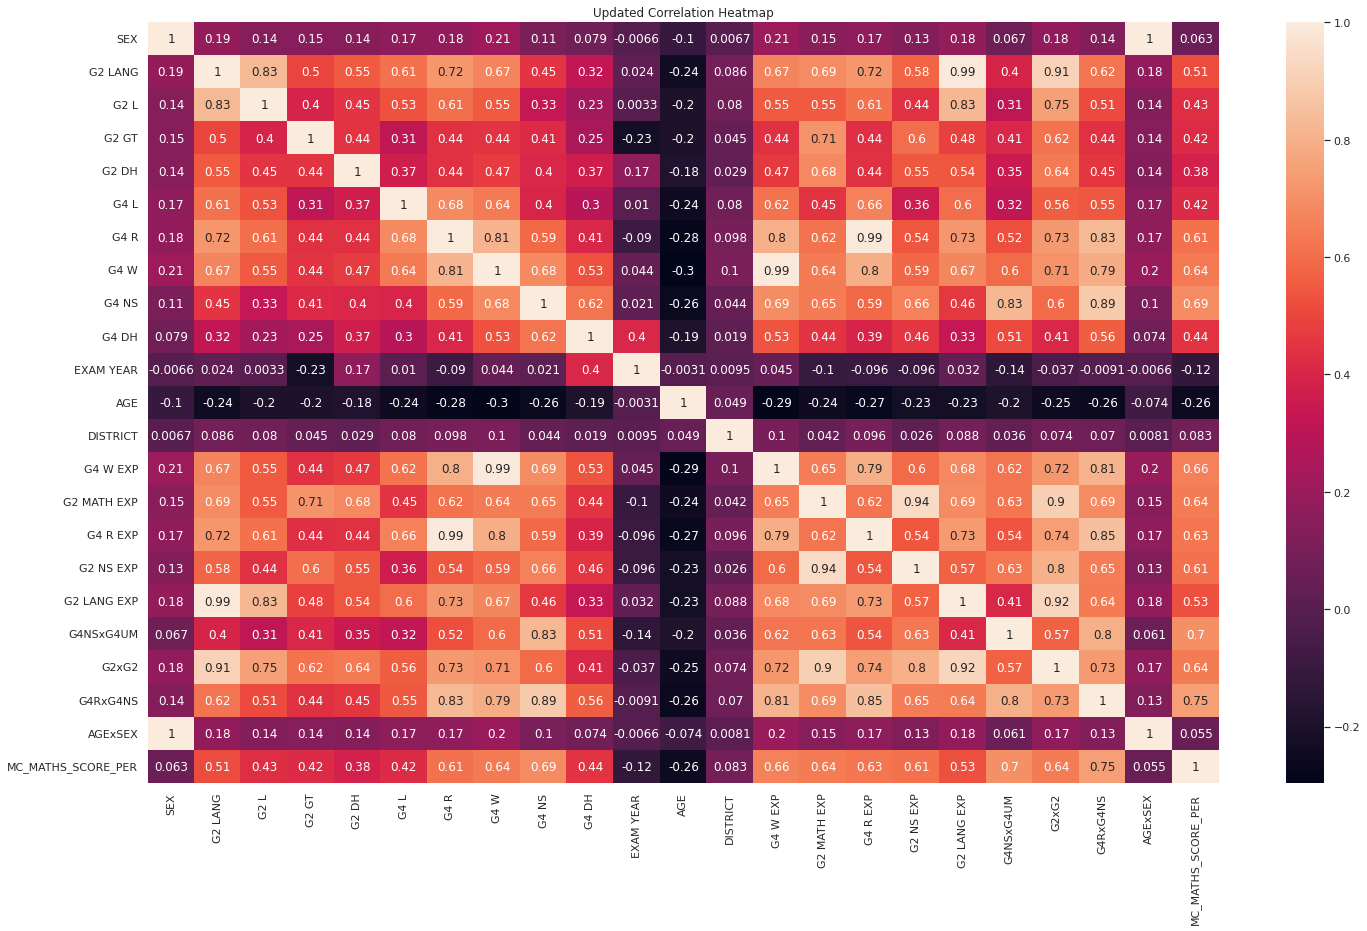

In [ ]:
from scipy.stats import spearmanr
#Find correlation coefficients for newly developed variables 
updated_math_train = pd.concat([xg_x_train,y_train], axis=1)
updated_math_test = pd.concat([xg_x_test,y_test], axis=1)
updated_math_var= pd.concat([updated_math_train,updated_math_test], axis=0)

updated_math_corr = updated_math_var.corr()
fig, ax = plt.subplots(figsize=(24,14))  
sns.heatmap(updated_math_corr, annot=True, ax=ax)
plt.title("Updated Correlation Heatmap")
plt.show()

In [ ]:
#Save updated correlation scores as Excel file
updated_math_corr_pd= pd.DataFrame(updated_math_corr['MC_MATHS_SCORE_PER'].sort_values(ascending=False))
updated_math_corr_pd.reset_index(inplace=True)
updated_math_corr_pd.columns = ['Variable Names', 'Correlation Score']
updated_math_corr_pd.to_excel('/content/drive/My Drive/Compiled Data /Tables/Updated Math Variables Correlation List.xlsx', sheet_name='sheet1', index=False)
updated_math_corr_pd

Variable Names  Correlation Score
0   MC_MATHS_SCORE_PER           1.000000
1             G4RxG4NS           0.746206
2            G4NSxG4UM           0.698011
3                G4 NS           0.690914
4             G4 W EXP           0.657367
5                G2xG2           0.643558
6          G2 MATH EXP           0.642419
7                 G4 W           0.637206
8             G4 R EXP           0.627018
9                 G4 R           0.612461
10           G2 NS EXP           0.609986
11         G2 LANG EXP           0.528571
12             G2 LANG           0.513790
13               G4 DH           0.443503
14                G2 L           0.429073
15               G2 GT           0.422214
16                G4 L           0.418925
17               G2 DH           0.382320
18            DISTRICT           0.083349
19                 SEX           0.062853
20             AGExSEX           0.055374
21           EXAM YEAR          -0.120513
22                 AGE          -0.255258

###***Principal Component Regression***

In [ ]:
lin_reg = LinearRegression()
rmse_list = []



X_train_scaled = scaler.fit_transform(xg_x_train)
X_test_scaled =  scaler.transform(xg_x_test) 

cv = KFold(n_splits=10, random_state=42, shuffle=True)

pca = PCA()
X_train_scaled = scaler.fit_transform(xg_x_train)
X_test_scaled =  scaler.transform(xg_x_test) 

X_train_pc = pca.fit_transform(X_train_scaled)
X_train_pc.shape

(3236, 22)

Combine both PCA graphs belonging to the same set of features

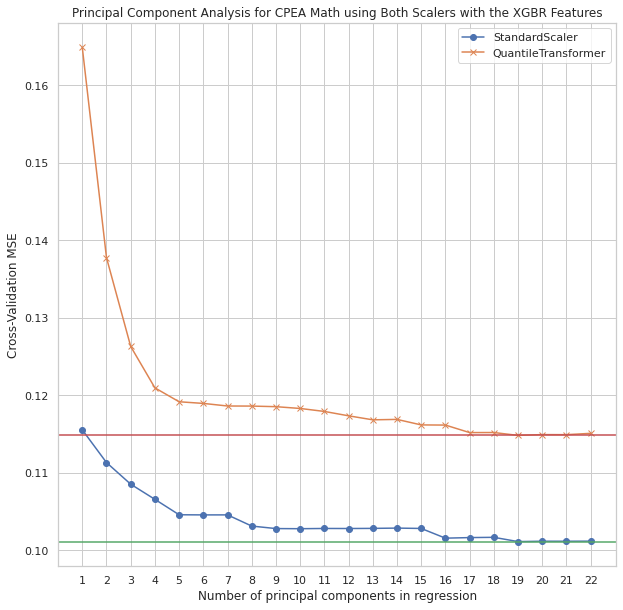

In [ ]:
# Loop through different count of principal components for linear regression
sns.set_theme(style="whitegrid")
lin_reg = LinearRegression()
rmse_list = []
pca = PCA()
X_train_scaled = scaler.fit_transform(xg_x_train)
X_test_scaled =  scaler.transform(xg_x_test) 

X_train_pc = pca.fit_transform(X_train_scaled)
X_train_pc.shape

for i in range(1, X_train_pc.shape[1]+1):
    rmse_score = -1 * cross_val_score(lin_reg, 
                                      X_train_pc[:,:i], # Use first k principal components
                                      y_train, 
                                      cv=cv, 
                                      scoring='neg_root_mean_squared_error').mean()
    rmse_list.append(rmse_score)


lin_reg = LinearRegression()
rmse_list1 = []
pca = PCA()
X_train_scaled = quantile.fit_transform(xg_x_train)
X_test_scaled =  quantile.transform(xg_x_test) 

X_train_pc = pca.fit_transform(X_train_scaled)
X_train_pc.shape

for i in range(1, X_train_pc.shape[1]+1):
    rmse_score = -1 * cross_val_score(lin_reg, 
                                      X_train_pc[:,:i], # Use first k principal components
                                      y_train, 
                                      cv=cv, 
                                      scoring='neg_root_mean_squared_error').mean()
    rmse_list1.append(rmse_score)

# Plot RMSE vs count of principal components used
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(rmse_list, '-o',label='StandardScaler')
plt.plot(rmse_list1, '-x',label='QuantileTransformer')
plt.xlabel('Number of principal components in regression')
plt.ylabel('Cross-Validation MSE')
plt.title('Principal Component Analysis for CPEA Math using Both Scalers with the XGBR Features')
plt.xlim(xmin=-1);
plt.xticks(np.arange(X_train_pc.shape[1]), np.arange(1, X_train_pc.shape[1]+1))
plt.axhline(y=min(rmse_list), color='g', linestyle='-');
plt.axhline(y=min(rmse_list1), color='r', linestyle='-');
plt.legend()


plt.savefig('/content/drive/My Drive/Compiled Data /Plots/CPEA Math PCA - XGFeatures.png', bbox_inches='tight')
plt.show()

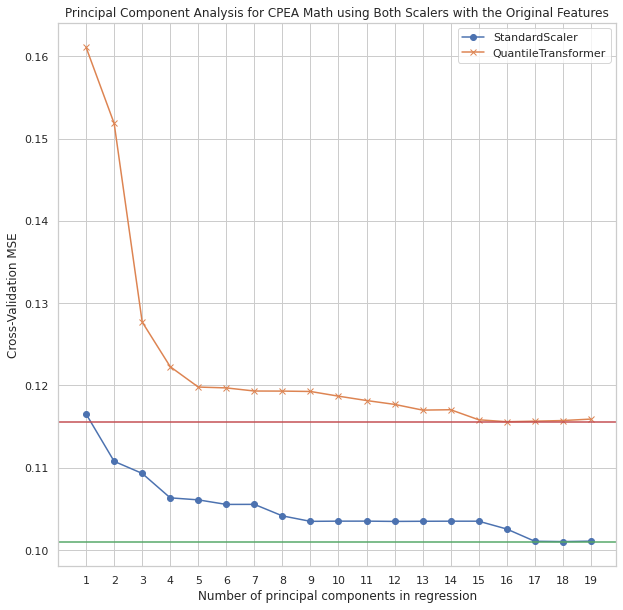

In [ ]:
# Loop through different count of principal components for linear regression

lin_reg = LinearRegression()
rmse_list3 = []
pca = PCA()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled =  scaler.transform(x_test) 

X_train_pc = pca.fit_transform(X_train_scaled)
X_train_pc.shape

for i in range(1, X_train_pc.shape[1]+1):
    rmse_score = -1 * cross_val_score(lin_reg, 
                                      X_train_pc[:,:i], # Use first k principal components
                                      y_train, 
                                      cv=cv, 
                                      scoring='neg_root_mean_squared_error').mean()
    rmse_list3.append(rmse_score)


lin_reg = LinearRegression()
rmse_list4 = []
pca = PCA()
X_train_scaled = quantile.fit_transform(x_train)
X_test_scaled =  quantile.transform(x_test) 

X_train_pc = pca.fit_transform(X_train_scaled)

for i in range(1, X_train_pc.shape[1]+1):
    rmse_score = -1 * cross_val_score(lin_reg, 
                                      X_train_pc[:,:i], # Use first k principal components
                                      y_train, 
                                      cv=cv, 
                                      scoring='neg_root_mean_squared_error').mean()
    rmse_list4.append(rmse_score)

# Plot RMSE vs count of principal components used
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(rmse_list3, '-o',label = 'StandardScaler')
plt.plot(rmse_list4, '-x',label = 'QuantileTransformer')
plt.xlabel('Number of principal components in regression')
plt.ylabel('Cross-Validation MSE')
plt.title('Principal Component Analysis for CPEA Math using Both Scalers with the Original Features')
plt.xlim(xmin=-1);
plt.xticks(np.arange(X_train_pc.shape[1]), np.arange(1, X_train_pc.shape[1]+1))
plt.legend()

plt.axhline(y=min(rmse_list3), color='g', linestyle='-');
plt.axhline(y=min(rmse_list4), color='r', linestyle='-');


plt.savefig('/content/drive/My Drive/Compiled Data /Plots/CPEA Math PCA - Original Features.png', bbox_inches='tight')
plt.show()

In [ ]:
pca_models=['Original Features','XGBR Features']
pca_results = []
lin_reg = LinearRegression()
pca = PCA()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled =  scaler.transform(x_test) 

X_train_pc = pca.fit_transform(X_train_scaled)
# Visually determine optimal number of principal components
best_pc_num = 18

# Get principal components of test set
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)
X_test_pc = pca.transform(X_test_scaled)[:,:best_pc_num]

# Predict on test data
y_pred1 = lin_reg_pc.predict(X_test_pc)
print(mean_squared_error(y_test, y_pred1, squared=False))
print(mean_absolute_error(y_test,y_pred1) )
print(r2_score(y_test,y_pred1))
pca_results.append(mean_squared_error(y_test, y_pred1, squared=False))




0.09854382078231975
0.07739892221404736
0.6040349008763444


In [ ]:
lin_reg = LinearRegression()
pca = PCA()
X_train_scaled = scaler.fit_transform(xg_x_train)
X_test_scaled =  scaler.transform(xg_x_test) 

X_train_pc = pca.fit_transform(X_train_scaled)
# Visually determine optimal number of principal components
best_pc_num = 19

# Get principal components of test set
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)
X_test_pc = pca.transform(X_test_scaled)[:,:best_pc_num]

# Predict on test data
y_pred2 = lin_reg_pc.predict(X_test_pc)
print(mean_squared_error(y_test, y_pred2, squared=False))
pca_results.append(mean_squared_error(y_test, y_pred2, squared=False))
print(mean_absolute_error(y_test,y_pred2) )
print(r2_score(y_test,y_pred2))

0.09849047491272163
0.07724005401566555
0.6044634895989767


In [ ]:
results = pd.DataFrame(
    {'Models': pca_models,
     'RMSE': pca_results,
    })

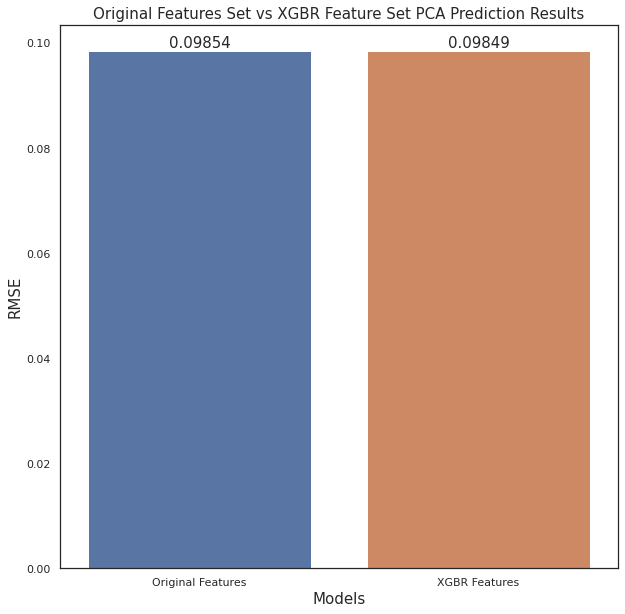

In [ ]:
sns.set_theme(style="white")
plots = sns.barplot(data=results, x='Models', y='RMSE')
 
# Iterrating over the bars one-by-one
for bar in plots.patches:

    plots.annotate(format(bar.get_height(), '.5f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
plt.title('Original Features Set vs XGBR Feature Set PCA Prediction Results', fontsize=15)
plt.xlabel('Models', fontsize=15)
plt.ylabel('RMSE', fontsize=15)
plt.show()

In [ ]:
#Record the best result for PCA 
rmse.append(mean_squared_error(y_test, y_pred2, squared=False))
mae.append(mean_absolute_error(y_test,y_pred2))
r_sq.append(r2_score(y_test,y_pred2))

In [ ]:
# Visually determine optimal number of principal components
best_pc_num = 19

# Get principal components of test set
lin_reg_pc = LinearRegression().fit(X_train_pc[:,:best_pc_num], y_train)
X_test_pc = pca.transform(X_test_scaled)[:,:best_pc_num]

# Predict on test data
y_pred1 = lin_reg_pc.predict(X_test_pc)
print(mean_squared_error(y_test, y_pred1, squared=False))
print(mean_absolute_error(y_test,y_pred1) )
print(r2_score(y_test,y_pred1))

0.09849047491272163
0.07724005401566555
0.6044634895989767


#####***KNN Regression***


In [ ]:
knn_rmse = []
knn_models = []

Model variation #1

No handles with labels found to put in legend.


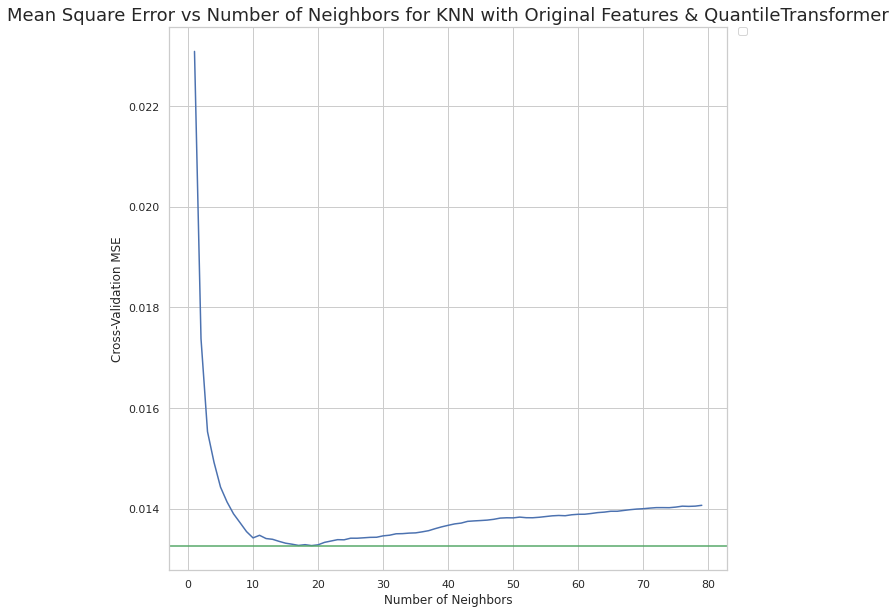

In [ ]:
sns.set_theme(style="whitegrid")

#Apply Quantile Transformed dataset
X_train_scaled = quantile.fit_transform(x_train)
X_test_scaled =  quantile.transform(x_test) 

#Track progression of MSE over the increase of neighbors
error1 = []
for k in range(1,80):
    knn = KNeighborsRegressor(n_neighbors=k, weights="distance")
    y_pred = cross_val_predict(knn, X_train_scaled, y_train, cv=cv)
    error1.append(mean_squared_error(y_train,y_pred)) 

plt.plot(range(1,80),error1)
plt.axhline(y=min(error1), color='g', linestyle='-');
plt.xlabel('Number of Neighbors')
plt.ylabel('Cross-Validation MSE')
plt.title("Mean Square Error vs Number of Neighbors for KNN with Original Features & QuantileTransformer", fontsize=18)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.savefig('/content/drive/My Drive/Compiled Data /Plots/MSE vs Number of Neighbors for KNN with Original Features & QuantileTransformer.png', bbox_inches='tight')
plt.show()

In [ ]:
#Search for best parameters
model = KNeighborsRegressor()
space = dict()
space['weights']=['uniform','distance']
space['algorithm'] = ['brute','kd_tree','ball_tree']
space['n_neighbors']=[16,17,18,19,20]

search = GridSearchCV(model, space, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=grid_cv)

results = search.fit(X_train_scaled,y_train)

# summarize result
print('Best Score: %s' % results.best_score_)
print('Best Hyperparameters: %s' % results.best_params_)

Best Score: -0.11496242258909788
Best Hyperparameters: {'algorithm': 'kd_tree', 'n_neighbors': 17, 'weights': 'distance'}


In [ ]:
#Apply best parameters based on previous cell and run model
knn = KNeighborsRegressor(n_neighbors=17,algorithm='kd_tree',weights='distance')
knn.fit(X_train_scaled,y_train)
y_pred3 = knn.predict(X_test_scaled)


print(mean_squared_error(y_test,y_pred3, squared=False))
knn_models.append('Original Features-QT')
knn_rmse.append(mean_squared_error(y_test,y_pred3, squared=False))
print(mean_absolute_error(y_test,y_pred3))
print(r2_score(y_test,y_pred3))

0.10743842025414346
0.08408480248093043
0.5293291062259258


Model variation #2

No handles with labels found to put in legend.


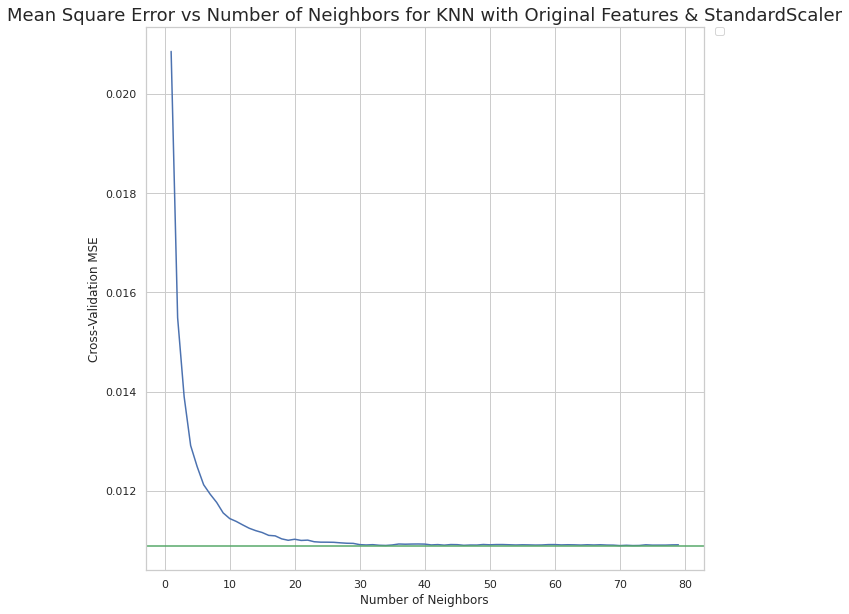

In [ ]:
sns.set_theme(style="whitegrid")

#Apply StandardScaler transformed dataset
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled =  scaler.transform(x_test) 

#Track progression of MSE over the increase of neighbors
error2 = []
for k in range(1,80):
    knn = KNeighborsRegressor(n_neighbors=k, weights="distance")
    y_pred = cross_val_predict(knn, X_train_scaled, y_train, cv=cv)
    error2.append(mean_squared_error(y_train,y_pred)) 

plt.plot(range(1,80),error2)
plt.axhline(y=min(error2), color='g', linestyle='-');
plt.xlabel('Number of Neighbors')
plt.ylabel('Cross-Validation MSE')
plt.title("Mean Square Error vs Number of Neighbors for KNN with Original Features & StandardScaler", fontsize=18)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.savefig('/content/drive/My Drive/Compiled Data /Plots/MSE vs Number of Neighbors for KNN with Original Features & StandardScaler.png', bbox_inches='tight')
plt.show()


In [ ]:
#Search for best parameters
model = KNeighborsRegressor()
space = dict()
space['weights']=['uniform','distance']
space['algorithm'] = ['brute','kd_tree','ball_tree']
space['n_neighbors']=[45,48,50,64,70]

search = GridSearchCV(model, space, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=grid_cv)

results = search.fit(X_train_scaled,y_train)

# summarize result
print('Best Score: %s' % results.best_score_)
print('Best Hyperparameters: %s' % results.best_params_)

Best Score: -0.10425691176642388
Best Hyperparameters: {'algorithm': 'brute', 'n_neighbors': 45, 'weights': 'distance'}


In [ ]:
#Apply best parameters based on previous cell and run model
knn = KNeighborsRegressor(n_neighbors=64,algorithm='brute',weights='distance')
knn.fit(X_train_scaled,y_train)
y_pred31 = knn.predict(X_test_scaled)

print(mean_squared_error(y_test,y_pred31, squared=False))
knn_models.append('Original Features-SS')
knn_rmse.append(mean_squared_error(y_test,y_pred31, squared=False))
print(mean_absolute_error(y_test,y_pred31))
print(r2_score(y_test,y_pred31))


0.09908846502682853
0.07752148742032303
0.5996458670614957


No handles with labels found to put in legend.


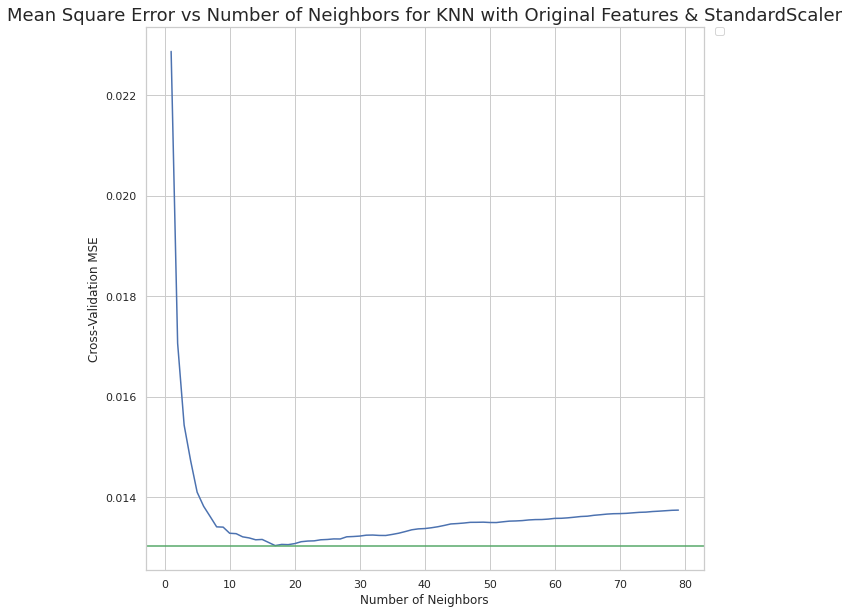

In [ ]:
#Apply Quantile Transformed XGBRegressor feature set
X_train_scaled = quantile.fit_transform(xg_x_train)
X_test_scaled =  quantile.transform(xg_x_test) 

#Track progression of MSE over the increase of neighbors
error3 = []
for k in range(1,80):
    knn = KNeighborsRegressor(n_neighbors=k, weights="distance")
    y_pred = cross_val_predict(knn, X_train_scaled, y_train, cv=cv)
    error3.append(mean_squared_error(y_train,y_pred)) 

plt.plot(range(1,80),error3)
plt.axhline(y=min(error3), color='g', linestyle='-');
plt.xlabel('Number of Neighbors')
plt.ylabel('Cross-Validation MSE')
plt.title("Mean Square Error vs Number of Neighbors for KNN with Original Features & StandardScaler", fontsize=18)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.savefig('/content/drive/My Drive/Compiled Data /Plots/MSE vs Number of Neighbors for KNN with XGBR Features & QuantileTransformer.png', bbox_inches='tight')
plt.show()

In [ ]:
#Search for best parameters
model = KNeighborsRegressor()
space = dict()
space['weights']=['uniform','distance']
space['algorithm'] = ['brute','kd_tree','ball_tree']
space['n_neighbors']=[17,18,19,20]

search = GridSearchCV(model, space, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=grid_cv)

results = search.fit(X_train_scaled,y_train)

# summarize result
print('Best Score: %s' % results.best_score_)
print('Best Hyperparameters: %s' % results.best_params_)

Best Score: -0.11398396465695108
Best Hyperparameters: {'algorithm': 'brute', 'n_neighbors': 17, 'weights': 'distance'}


In [ ]:
#Apply best parameters based on previous cell and run model
knn = KNeighborsRegressor(n_neighbors=17,algorithm='brute',weights='distance')
knn.fit(X_train_scaled,y_train)
y_pred32 = knn.predict(X_test_scaled)

print(mean_squared_error(y_test,y_pred32, squared=False))
knn_models.append('XGBR Features-QT')
knn_rmse.append(mean_squared_error(y_test,y_pred32, squared=False))
print(mean_absolute_error(y_test,y_pred32))
print(r2_score(y_test,y_pred32))

0.10678247183614228
0.08354481220403481
0.5350587764567944


Model variation #4

No handles with labels found to put in legend.


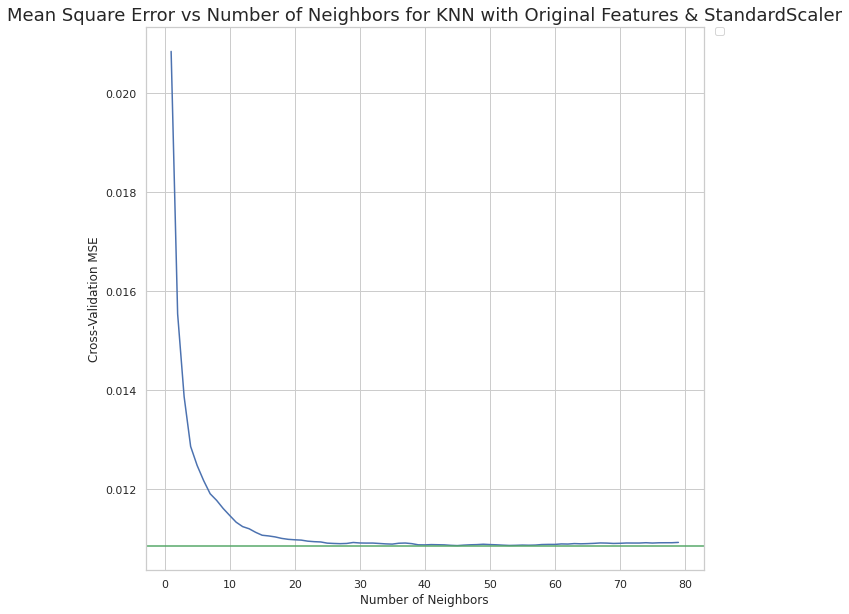

In [ ]:
#Apply StandardScaler transformed XGBRegressor feature set
X_train_scaled = scaler.fit_transform(xg_x_train)
X_test_scaled =  scaler.transform(xg_x_test) 

#Track progression of MSE over the increase of neighbors
error4 = []
for k in range(1,80):
    knn = KNeighborsRegressor(n_neighbors=k, weights="distance")
    y_pred = cross_val_predict(knn, X_train_scaled, y_train, cv=cv)
    error4.append(mean_squared_error(y_train,y_pred)) 

plt.plot(range(1,80),error4)
plt.axhline(y=min(error4), color='g', linestyle='-');
plt.xlabel('Number of Neighbors')
plt.ylabel('Cross-Validation MSE')
plt.title("Mean Square Error vs Number of Neighbors for KNN with Original Features & StandardScaler", fontsize=18)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.savefig('/content/drive/My Drive/Compiled Data /Plots/MSE vs Number of Neighbors for KNN with XGBR Features & StandardScaler.png', bbox_inches='tight')
plt.show()

In [ ]:
#Search for best parameters
model = KNeighborsRegressor()
space = dict()
space['weights']=['uniform','distance']
space['algorithm'] = ['brute','kd_tree','ball_tree']
space['n_neighbors']=[45,48,50,52,54]

search = GridSearchCV(model, space, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=grid_cv)

results = search.fit(X_train_scaled,y_train)

# summarize result
print('Best Score: %s' % results.best_score_)
print('Best Hyperparameters: %s' % results.best_params_)


Best Score: -0.1040180630902767
Best Hyperparameters: {'algorithm': 'brute', 'n_neighbors': 52, 'weights': 'distance'}


In [ ]:
#Apply best parameters based on previous cell and run model
knn = KNeighborsRegressor(n_neighbors=52,algorithm='brute',weights='distance')
knn.fit(X_train_scaled,y_train)
y_pred33 = knn.predict(X_test_scaled)

print(mean_squared_error(y_test,y_pred33, squared=False))
knn_models.append('XGBR Features-SS')
knn_rmse.append(mean_squared_error(y_test,y_pred33, squared=False))
print(mean_absolute_error(y_test,y_pred33))
print(r2_score(y_test,y_pred33))


0.09914998861755818
0.07756948957759832
0.5991485564911027


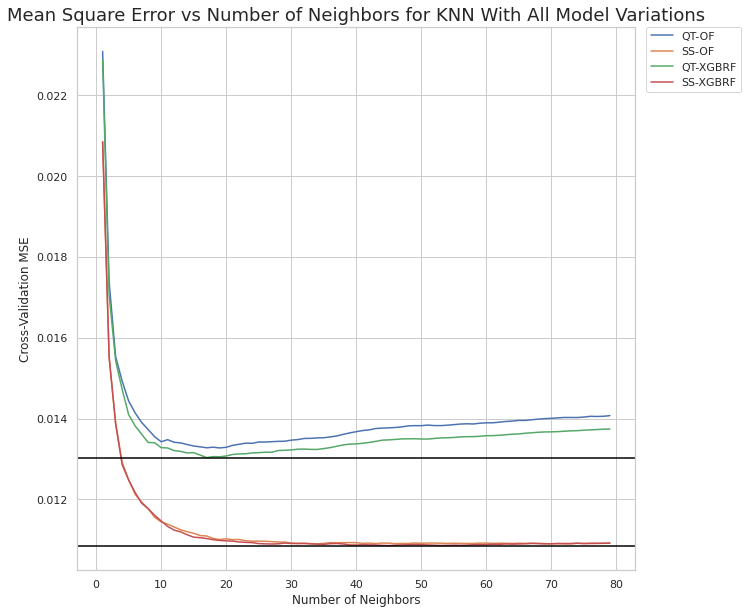

In [ ]:
#Plot the MSE curves for all previous models
plt.plot(range(1,80),error1, label = 'QT-OF')
plt.plot(range(1,80),error2,label = 'SS-OF')
plt.plot(range(1,80),error3,label = 'QT-XGBRF')
plt.plot(range(1,80),error4,label = 'SS-XGBRF')
plt.axhline(y=min(error3), color='black', linestyle='-');
plt.axhline(y=min(error4), color='black', linestyle='-');

plt.xlabel('Number of Neighbors')
plt.ylabel('Cross-Validation MSE')
plt.title("Mean Square Error vs Number of Neighbors for KNN With All Model Variations" , fontsize=18)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.savefig('/content/drive/My Drive/Compiled Data /Plots/CV MSE vs Number of Neighbors for KNN With All Model Variations.png', bbox_inches='tight')
plt.show()

In [ ]:
#Apply PCA to the best KNN model data set
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled =  scaler.transform(x_test) 

pca = PCA()

best_pc_num = 18
X_train_pc = pca.fit_transform(X_train_scaled)[:,:best_pc_num]
X_test_pc = pca.transform(X_test_scaled)[:,:best_pc_num]

knn = KNeighborsRegressor(n_neighbors=64,algorithm='brute',weights='distance')
knn.fit(X_train_pc,y_train)
y_pred34 = knn.predict(X_test_pc)
 
print(mean_squared_error(y_test,y_pred34, squared=False))
knn_models.append('Original Features-SS-PCA')
knn_rmse.append(mean_squared_error(y_test,y_pred34, squared=False))
print(mean_absolute_error(y_test,y_pred34))
print(r2_score(y_test,y_pred34))



0.09908926823600435
0.0775295195726832
0.5996393765095149


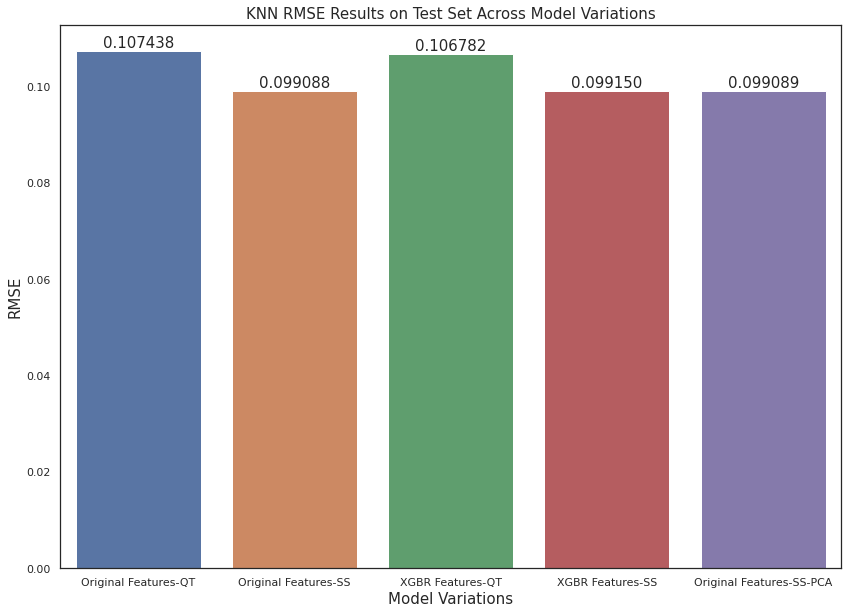

In [ ]:
#Summarize KNN Regression results
plt.rcParams['figure.figsize']=(14,10)
knn_results = pd.DataFrame(
    {'Models': knn_models,
     'RMSE': knn_rmse,
    })

sns.set_theme(style="white")
plots = sns.barplot(data=knn_results, x='Models', y='RMSE')
 
# Iterrating over the bars one-by-one
for bar in plots.patches:   
    plots.annotate(format(bar.get_height(), '.6f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
plt.title('KNN RMSE Results on Test Set Across Model Variations', fontsize=15)
plt.xlabel('Model Variations', fontsize=15)
plt.ylabel('RMSE', fontsize=15)
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/KNN RMSE Results across Model Variations.png', bbox_inches='tight')
plt.show()

In [ ]:
#Save best KNN results
rmse.append(mean_squared_error(y_test, y_pred31, squared=False))
mae.append(mean_absolute_error(y_test,y_pred31))
r_sq.append(r2_score(y_test,y_pred31))

####***LASSO Regression***

####Here we compare the LASSO Regression on both feature set using both scalers. PCA is then applied on the best performance in hopes of further improvement. 

In [ ]:
lasso_models=[]
lasso_rmse=[]

In [ ]:
X_train_scaled = quantile.fit_transform(x_train)
X_test_scaled =  quantile.transform(x_test) 

model= Lasso()
grid = dict()
grid['alpha']=[0.0,0.001,0.0001, 0.00001]
# define search
lasso_search = GridSearchCV(model, grid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# perform the search
results = lasso_search.fit(X_train_scaled,y_train)
# summarize
print('Best Score: %s' % results.best_score_)
print('Best Hyperparameters: %s' % results.best_params_)



Best Score: -0.11558651764698762
Best Hyperparameters: {'alpha': 0.0001}


In [ ]:
#Apply best parameters based on previous cell and run model
lasso = Lasso(alpha=0.0001)
lasso.fit(X_train_scaled,y_train)
y_pred4 = lasso.predict(X_test_scaled)

print(mean_squared_error(y_test,y_pred4,squared=False))
lasso_models.append('Original Features-QT')
lasso_rmse.append(mean_squared_error(y_test,y_pred4,squared=False))
print(mean_absolute_error(y_test,y_pred4) )
print(r2_score(y_test,y_pred4))


0.10952315632467277
0.08527528985849833
0.5108860868176831


In [ ]:
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled =  scaler.transform(x_test) 

model= Lasso()
grid = dict()
grid['alpha']=[0.0,0.001,0.0001, 0.00001]
# define search
lasso_search = GridSearchCV(model, grid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# perform the search
results = lasso_search.fit(X_train_scaled,y_train)
# summarize
print('Best Score: %s' % results.best_score_)
print('Best Hyperparameters: %s' % results.best_params_)


Best Score: -0.10107829105351107
Best Hyperparameters: {'alpha': 0.0}


In [ ]:
#Apply best parameters based on previous cell and run model
lasso = Lasso(alpha=0.0)
lasso.fit(X_train_scaled,y_train)
y_pred41 = lasso.predict(X_test_scaled)


print(mean_squared_error(y_test,y_pred41,squared=False))
lasso_models.append('Original Features-SS')
lasso_rmse.append(mean_squared_error(y_test,y_pred41,squared=False))
print(mean_absolute_error(y_test,y_pred41) )
print(r2_score(y_test,y_pred41))

0.09853310838161282
0.07739115310893661
0.6041209845337654


In [ ]:
X_train_scaled = quantile.fit_transform(xg_x_train)
X_test_scaled =  quantile.transform(xg_x_test) 

model= Lasso()
grid = dict()
grid['alpha']=[0.0,0.001,0.0001, 0.00001]
# define search
lasso_search = GridSearchCV(model, grid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# perform the search
results = lasso_search.fit(X_train_scaled,y_train)
# summarize
print('Best Score: %s' % results.best_score_)
print('Best Hyperparameters: %s' % results.best_params_)

Best Score: -0.11478577677678418
Best Hyperparameters: {'alpha': 1e-05}


In [ ]:
#Apply best parameters based on previous cell and run model
lasso = Lasso(alpha=0.00001)
lasso.fit(X_train_scaled,y_train)
y_pred42 = lasso.predict(X_test_scaled)


print(mean_squared_error(y_test,y_pred42,squared=False))
lasso_models.append('XGB Features-QT')
lasso_rmse.append(mean_squared_error(y_test,y_pred42,squared=False))
print(mean_absolute_error(y_test,y_pred42) )
print(r2_score(y_test,y_pred42))


0.10771950235383666
0.08398195492675772
0.526863131358803


In [ ]:
X_train_scaled = scaler.fit_transform(xg_x_train)
X_test_scaled =  scaler.transform(xg_x_test) 

model= Lasso()
grid = dict()
grid['alpha']=[0.0,0.001,0.0001, 0.00001]
# define search
lasso_search = GridSearchCV(model, grid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# perform the search
results = lasso_search.fit(X_train_scaled,y_train)
# summarize
print('Best Score: %s' % results.best_score_)
print('Best Hyperparameters: %s' % results.best_params_)

Best Score: -0.10112867619950461
Best Hyperparameters: {'alpha': 1e-05}


In [ ]:
#Apply best parameters based on previous cell and run model
lasso = Lasso(alpha=0.00001)
lasso.fit(X_train_scaled,y_train)
y_pred43 = lasso.predict(X_test_scaled)


print(mean_squared_error(y_test,y_pred43,squared=False))
lasso_models.append('XGB Features-SS')
lasso_rmse.append(mean_squared_error(y_test,y_pred43,squared=False))
print(mean_absolute_error(y_test,y_pred43) )
print(r2_score(y_test,y_pred43))

0.09849351117337066
0.07722738540585773
0.6044391020537994


In [ ]:
X_train_scaled = scaler.fit_transform(xg_x_train)
X_test_scaled =  scaler.transform(xg_x_test) 
pca= PCA()
X_train_pc = pca.fit_transform(X_train_scaled)
X_test_pc= pca.transform(X_test_scaled)
best_pc_num = 27

X_train_pc=X_train_pc[:,:best_pc_num]
X_test_pc = X_test_pc[:,:best_pc_num]

model= Lasso()
grid = dict()
grid['alpha']=[0.0,0.001,0.0001, 0.00001]
# define search
lasso_search = GridSearchCV(model, grid, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
# perform the search
results = lasso_search.fit(X_train_pc,y_train)
# summarize
print('Best Score: %s' % results.best_score_)
print('Best Hyperparameters: %s' % results.best_params_)

Best Score: -0.10109645580609208
Best Hyperparameters: {'alpha': 0.0001}


In [ ]:
#Apply best parameters based on previous cell and run model
lasso = Lasso(alpha=0.0001)
lasso.fit(X_train_pc,y_train)
y_pred44 = lasso.predict(X_test_pc)


print(mean_squared_error(y_test,y_pred44,squared=False))
lasso_models.append('XGB Features-SS-PCA')
lasso_rmse.append(mean_squared_error(y_test,y_pred44,squared=False))
print(mean_absolute_error(y_test,y_pred44) )
print(r2_score(y_test,y_pred44))

0.09844611530555981
0.07716013245881945
0.6048197046127788


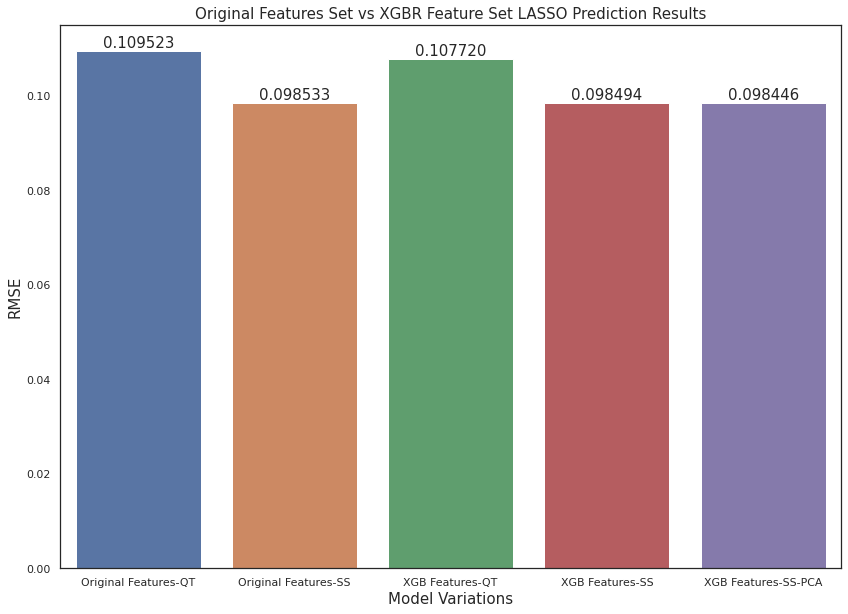

In [ ]:
lasso_results = pd.DataFrame(
    {'Models': lasso_models,
     'RMSE': lasso_rmse,
    })
plt.rcParams["figure.figsize"] = (14,10)
sns.set_theme(style="white")
plots = sns.barplot(data=lasso_results, x='Models', y='RMSE')
 
# Iterrating over the bars one-by-one
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.6f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
plt.title('Original Features Set vs XGBR Feature Set LASSO Prediction Results', fontsize=15)
plt.xlabel('Model Variations', fontsize=15)
plt.ylabel('RMSE', fontsize=15)
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/LASSO Regression MSE Results across Model Variations.png', bbox_inches='tight')
plt.show()

In [ ]:
#Save best LASSO results
rmse.append(mean_squared_error(y_test, y_pred43, squared=False))
mae.append(mean_absolute_error(y_test,y_pred43))
r_sq.append(r2_score(y_test,y_pred43))

####**Deep Learning**

In [ ]:
#Apply different scalers to the XGBRegressor feature set
dnn_scaler = StandardScaler()
x_train_dnn = dnn_scaler.fit_transform(xg_x_train)
x_test_dnn = dnn_scaler.transform(xg_x_test)
#rnn_scaler = StandardScaler()
#x_train_rnn = rnn_scaler.fit_transform(xg_x_train)
#x_test_rnn = rnn_scaler.transform(xg_x_test)

xg_x_train_quantile = quantile.fit_transform(xg_x_train)
xg_x_test_quantile = quantile.transform(xg_x_test)

In [ ]:
#DNN
model2 = Sequential()
model2.add(Dense(128, input_dim=22, activation='tanh'))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(512, activation='relu'))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(1, activation='linear'))
model2.summary()


model2.compile(optimizer='adam', # default='rmsprop', an algorithm to be used in backpropagation
              loss='mean_squared_error', # Loss function to be optimized. A string (name of loss function), or a tf.keras.losses.Loss instance.
              metrics=['MeanSquaredError'], # List of metrics to be evaluated by the model during training and testing. 
             )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2944      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 331,905
Trainable params: 331,905
Non-trai

In [ ]:
#Apply DNN to Quantile Transformed data
history2 = model2.fit(xg_x_train_quantile,y_train, epochs = 200,use_multiprocessing=True )

Epoch 1/200
102/102 [==============================] - 2s 7ms/step - loss: 0.0261 - mean_squared_error: 0.0261
Epoch 2/200
102/102 [==============================] - 1s 7ms/step - loss: 0.0117 - mean_squared_error: 0.0117
Epoch 3/200
102/102 [==============================] - 1s 7ms/step - loss: 0.0114 - mean_squared_error: 0.0114
Epoch 4/200
102/102 [==============================] - 1s 7ms/step - loss: 0.0109 - mean_squared_error: 0.0109
Epoch 5/200
102/102 [==============================] - 1s 7ms/step - loss: 0.0106 - mean_squared_error: 0.0106
Epoch 6/200
102/102 [==============================] - 1s 7ms/step - loss: 0.0112 - mean_squared_error: 0.0112
Epoch 7/200
102/102 [==============================] - 1s 7ms/step - loss: 0.0102 - mean_squared_error: 0.0102
Epoch 8/200
102/102 [==============================] - 1s 7ms/step - loss: 0.0098 - mean_squared_error: 0.0098
Epoch 9/200
102/102 [==============================] - 1s 7ms/step - loss: 0.0097 - mean_squared_error: 0.0097
E

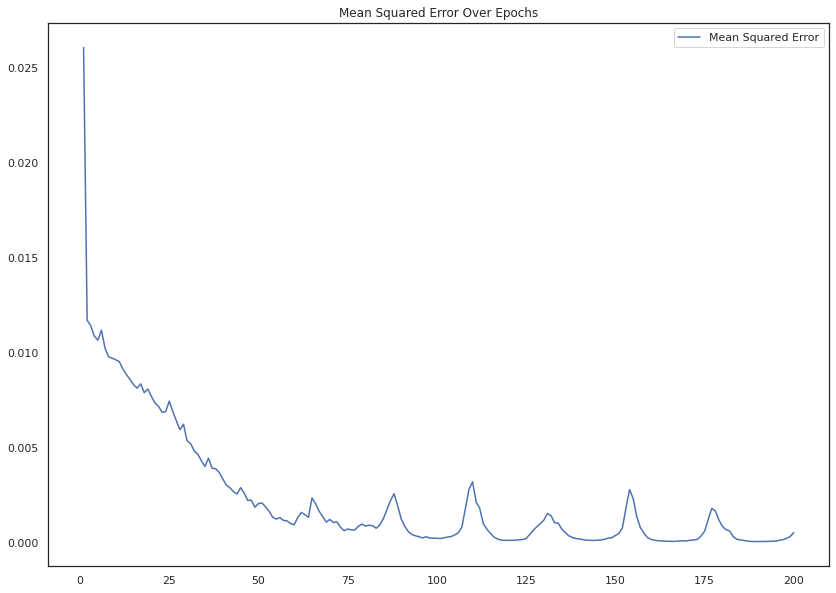

In [ ]:
#Plot the progression of MSE over the training life of the model
mse= history2.history['mean_squared_error']
epochs = range(1,len(mse)+1)
plt.plot(epochs, mse, 'b', label= "Mean Squared Error")

plt.title("Mean Squared Error Over Epochs")
plt.legend()
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/Mean Squared Error Over Epochs-StandardScaler.png', bbox_inches='tight')
plt.show()

In [ ]:
#model prediction
y_pred6 = model2.predict(xg_x_test_quantile)
print(mean_squared_error(y_test,y_pred6, squared=False))
print(mean_absolute_error(y_test,y_pred6) )
print(r2_score(y_test,y_pred6))

0.11771259393393384
0.09209744167138796
0.43500581959117823


In [ ]:
#DNN
model3 = Sequential()
model3.add(Dense(128, input_dim=22, activation='tanh'))
model3.add(Dense(256, activation='relu'))
model3.add(Dense(512, activation='relu'))
model3.add(Dense(256, activation='relu'))
model3.add(Dense(128, activation='relu'))
model3.add(Dense(1, activation='linear'))
model3.summary()

##### Step 5 - Compile keras model
model3.compile(optimizer='adam', # default='rmsprop', an algorithm to be used in backpropagation
              loss='mean_squared_error', # Loss function to be optimized. A string (name of loss function), or a tf.keras.losses.Loss instance.
              metrics=['MeanSquaredError'], # List of metrics to be evaluated by the model during training and testing. 
             )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               2944      
                                                                 
 dense_7 (Dense)             (None, 256)               33024     
                                                                 
 dense_8 (Dense)             (None, 512)               131584    
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 331,905
Trainable params: 331,905
Non-tr

In [ ]:
#Apply DNN to Standardized data
history3 = model3.fit(x_train_dnn,y_train, epochs = 200,use_multiprocessing=True )

Epoch 1/200
102/102 [==============================] - 1s 7ms/step - loss: 0.0250 - mean_squared_error: 0.0250
Epoch 2/200
102/102 [==============================] - 1s 7ms/step - loss: 0.0116 - mean_squared_error: 0.0116
Epoch 3/200
102/102 [==============================] - 1s 7ms/step - loss: 0.0112 - mean_squared_error: 0.0112
Epoch 4/200
102/102 [==============================] - 1s 7ms/step - loss: 0.0104 - mean_squared_error: 0.0104
Epoch 5/200
102/102 [==============================] - 1s 7ms/step - loss: 0.0104 - mean_squared_error: 0.0104
Epoch 6/200
102/102 [==============================] - 1s 6ms/step - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 7/200
102/102 [==============================] - 1s 7ms/step - loss: 0.0097 - mean_squared_error: 0.0097
Epoch 8/200
102/102 [==============================] - 1s 7ms/step - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 9/200
102/102 [==============================] - 1s 7ms/step - loss: 0.0096 - mean_squared_error: 0.0096
E

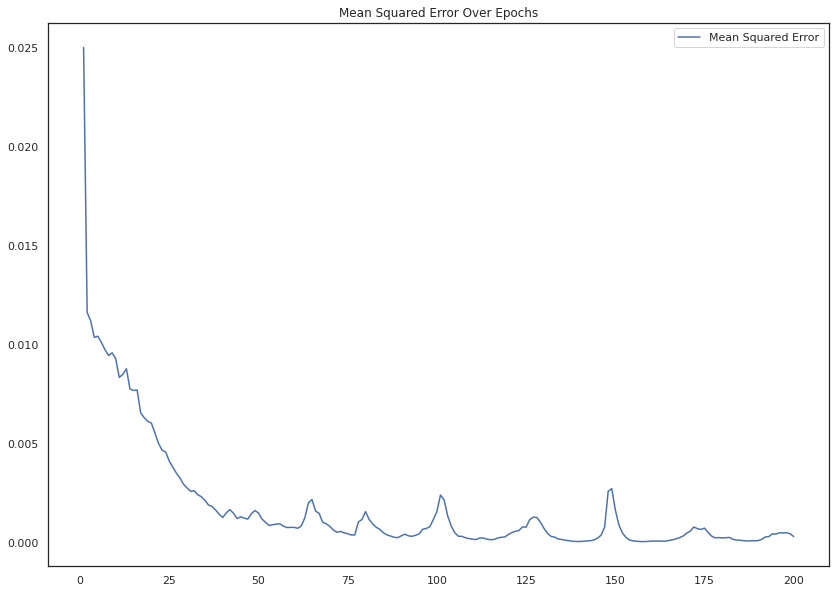

In [ ]:
#Plot the progression of MSE over the training life of the model
mse= history3.history['mean_squared_error']
epochs = range(1,len(mse)+1)
plt.plot(epochs, mse, 'b', label= "Mean Squared Error")
plt.title("Mean Squared Error Over Epochs")
plt.legend()
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/Mean Squared Error Over Epochs -StandardScaler.png', bbox_inches='tight')
plt.show()

In [ ]:
y_pred61 = model3.predict(x_test_dnn)
print(mean_squared_error(y_test,y_pred61, squared=False))
print(mean_absolute_error(y_test,y_pred61) )
print(r2_score(y_test,y_pred61))

0.11020645445833951
0.08630056053378553
0.5047640359267441


In [ ]:
#Apply PCA to the XGBRegressor dataset
X_train_pc = pca.fit_transform(xg_x_train_quantile)[:,:19]
X_test_pc = pca.transform(xg_x_test_quantile)[:,:19]

In [ ]:
#DNN
model4 = Sequential()
model4.add(Dense(128, input_dim=19, activation='tanh'))
model4.add(Dense(256, activation='relu'))
model4.add(Dense(512, activation='relu'))
model4.add(Dense(256, activation='relu'))
model4.add(Dense(128, activation='relu'))
model4.add(Dense(1, activation='linear'))
model4.summary()

##### Step 5 - Compile keras model
model4.compile(optimizer='adam', # default='rmsprop', an algorithm to be used in backpropagation
              loss='mean_squared_error', # Loss function to be optimized. A string (name of loss function), or a tf.keras.losses.Loss instance.
              metrics=['MeanSquaredError'], # List of metrics to be evaluated by the model during training and testing.  
             )

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               2560      
                                                                 
 dense_13 (Dense)            (None, 256)               33024     
                                                                 
 dense_14 (Dense)            (None, 512)               131584    
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 dense_16 (Dense)            (None, 128)               32896     
                                                                 
 dense_17 (Dense)            (None, 1)                 129       
                                                                 
Total params: 331,521
Trainable params: 331,521
Non-tr

In [ ]:
#Apply DNN on principal components
history4 = model4.fit(X_train_pc,y_train, epochs = 300,use_multiprocessing=True )

Epoch 1/300
102/102 [==============================] - 1s 6ms/step - loss: 0.0228 - mean_squared_error: 0.0228
Epoch 2/300
102/102 [==============================] - 1s 7ms/step - loss: 0.0125 - mean_squared_error: 0.0125
Epoch 3/300
102/102 [==============================] - 1s 6ms/step - loss: 0.0117 - mean_squared_error: 0.0117
Epoch 4/300
102/102 [==============================] - 1s 7ms/step - loss: 0.0118 - mean_squared_error: 0.0118
Epoch 5/300
102/102 [==============================] - 1s 6ms/step - loss: 0.0106 - mean_squared_error: 0.0106
Epoch 6/300
102/102 [==============================] - 1s 6ms/step - loss: 0.0106 - mean_squared_error: 0.0106
Epoch 7/300
102/102 [==============================] - 1s 6ms/step - loss: 0.0109 - mean_squared_error: 0.0109
Epoch 8/300
102/102 [==============================] - 1s 6ms/step - loss: 0.0098 - mean_squared_error: 0.0098
Epoch 9/300
102/102 [==============================] - 1s 7ms/step - loss: 0.0097 - mean_squared_error: 0.0097
E

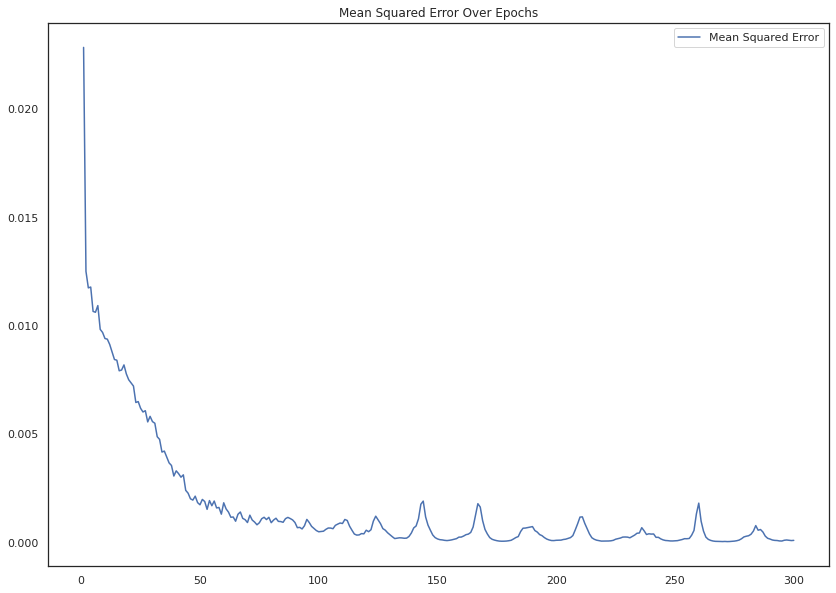

In [ ]:
#Plot the progression of MSE over the training life of the model
mse= history4.history['mean_squared_error']
epochs = range(1,len(mse)+1)
plt.plot(epochs, mse, 'b', label= "Mean Squared Error")
plt.title("Mean Squared Error Over Epochs")
plt.legend()
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/Mean Squared Error Over Epochs -QuantileTransformer-PCA.png', bbox_inches='tight')
plt.show()

In [ ]:
#model prediction
y_pred62 = model4.predict(X_test_pc)
print(mean_squared_error(y_test,y_pred62, squared=False))
print(mean_absolute_error(y_test,y_pred62) )
print(r2_score(y_test,y_pred62))

0.11415312199297048
0.08976051411156585
0.4686585437794163


In [ ]:
#DNN
model2 = Sequential()
model2.add(Dense(128, input_dim=22, activation='tanh'))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(512, activation='relu'))
model2.add(Dense(256, activation='tanh'))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(1, activation='linear'))
model2.summary()

##### Step 5 - Compile keras model
model2.compile(optimizer='rmsprop', # use default optimizer 
              loss='mean_squared_error', # Loss function to be optimized. A string (name of loss function), or a tf.keras.losses.Loss instance.
              metrics=['MeanSquaredError'], # List of metrics to be evaluated by the model during training and testing.  
             )

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 128)               2944      
                                                                 
 dense_19 (Dense)            (None, 256)               33024     
                                                                 
 dense_20 (Dense)            (None, 512)               131584    
                                                                 
 dense_21 (Dense)            (None, 256)               131328    
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                                 
 dense_23 (Dense)            (None, 1)                 129       
                                                                 
Total params: 331,905
Trainable params: 331,905
Non-tr

In [ ]:
#Apply best DNN with a change in optimizer, using the deafult optimizer
history5 = model2.fit(xg_x_train_quantile,y_train, epochs = 300,use_multiprocessing=True )

Epoch 1/300
102/102 [==============================] - 2s 8ms/step - loss: 0.0835 - mean_squared_error: 0.0835
Epoch 2/300
102/102 [==============================] - 1s 8ms/step - loss: 0.0188 - mean_squared_error: 0.0188
Epoch 3/300
102/102 [==============================] - 1s 7ms/step - loss: 0.0155 - mean_squared_error: 0.0155
Epoch 4/300
102/102 [==============================] - 1s 7ms/step - loss: 0.0135 - mean_squared_error: 0.0135
Epoch 5/300
102/102 [==============================] - 1s 8ms/step - loss: 0.0123 - mean_squared_error: 0.0123
Epoch 6/300
102/102 [==============================] - 1s 7ms/step - loss: 0.0118 - mean_squared_error: 0.0118
Epoch 7/300
102/102 [==============================] - 1s 8ms/step - loss: 0.0110 - mean_squared_error: 0.0110
Epoch 8/300
102/102 [==============================] - 1s 7ms/step - loss: 0.0109 - mean_squared_error: 0.0109
Epoch 9/300
102/102 [==============================] - 1s 7ms/step - loss: 0.0106 - mean_squared_error: 0.0106
E

In [ ]:
#model prediction
y_pred63 = model2.predict(xg_x_test_quantile)
print(mean_squared_error(y_test,y_pred63, squared=False))
print(mean_absolute_error(y_test,y_pred63) )
print(r2_score(y_test,y_pred63))

0.11926750969715792
0.09465443575218932
0.4199807370715316


In [ ]:
"""During experimentation, this model was saved as the best performing DNN. Due to the random initialization of weights and biases, we would not be able to
 reproduce this model without saving it to a location to be retreived at a later date."""
#model3.save('/content/drive/My Drive/Compiled Data /ANN_Model_1109.h5')
"""NB: This model performed better with the following scores :0.11091292435378426
0.08669570110646957
0.4983943417661476

It takes in 22 inputs as per provided from the XGBoost feature tweaking and applied the standard scaler to said features"""

'NB: This model performed better with the following scores :0.11091292435378426\n0.08669570110646957\n0.4983943417661476\n\nIt takes in 22 inputs as per provided from the XGBoost feature tweaking and applied the standard scaler to said features'

In [ ]:
#Load model
reconstructed_model2 = keras.models.load_model('/content/drive/My Drive/Compiled Data /ANN_Model_1109.h5')

y_pred7 = reconstructed_model2.predict(x_test_dnn)
print(sqrt(mean_squared_error(y_test,y_pred7)))
print(mean_absolute_error(y_test,y_pred7) )
print(r2_score(y_test,y_pred7))

rmse.append(mean_squared_error(y_test, y_pred7, squared=False))
mae.append(mean_absolute_error(y_test,y_pred7))
r_sq.append(r2_score(y_test,y_pred7))


0.11091292435378426
0.08669570110646957
0.4983943417661476


In [ ]:
reconstructed_model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 128)               2944      
                                                                 
 dense_19 (Dense)            (None, 256)               33024     
                                                                 
 dense_20 (Dense)            (None, 512)               131584    
                                                                 
 dense_21 (Dense)            (None, 256)               131328    
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                                 
 dense_23 (Dense)            (None, 1)                 129       
                                                                 
Total params: 331,905
Trainable params: 331,905
Non-tr

#***Results***

In [ ]:
#Collate best results for all models into a table
results = pd.DataFrame(
    {'Models': models,
     'RMSE': rmse,
     'MAE': mae,
     'R-Sq':r_sq
    })

In [ ]:
#Results table
results


Models      RMSE       MAE      R-Sq
0  Base Model  0.129631  0.102451  0.314798
1     XGBoost  0.097091  0.075862  0.615622
2         PCR  0.098490  0.077240  0.604463
3         KNN  0.099088  0.077521  0.599646
4       LASSO  0.098494  0.077227  0.604439
5         ANN  0.110913  0.086696  0.498394

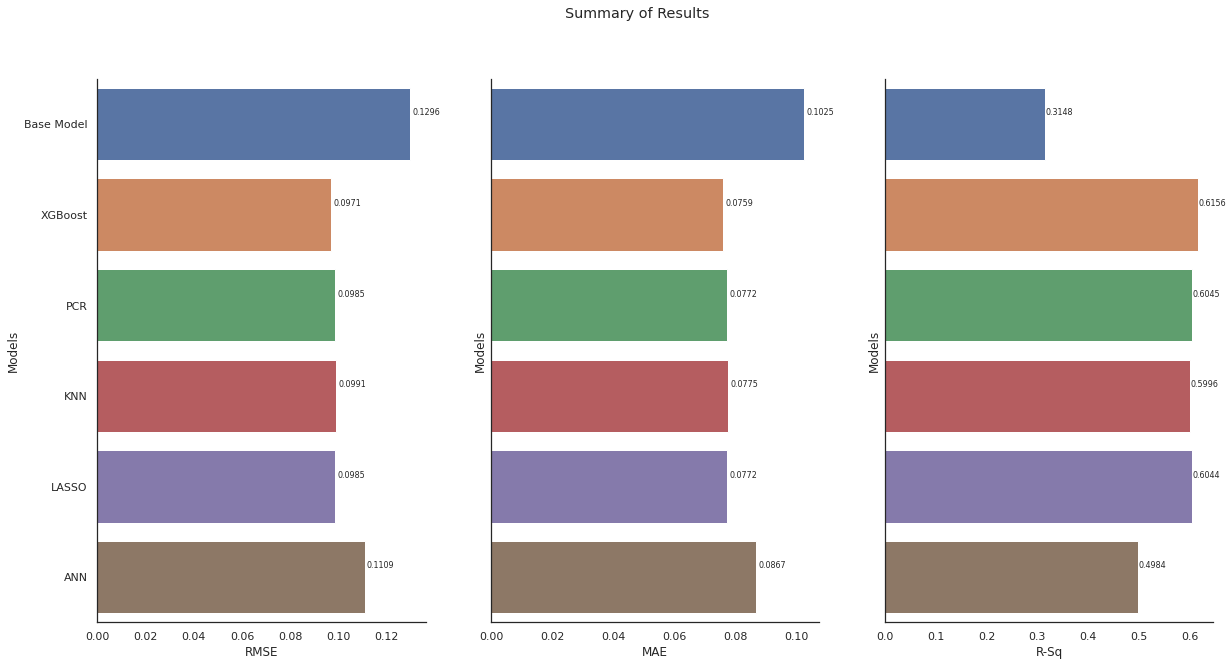

In [ ]:
#Plot results as a bar chart
fig, axes = plt.subplots(1, 3, figsize=(20, 10), sharey=True)
 
fig.suptitle('Summary of Results')
 
yx=sns.barplot(ax=axes[0], data=results, x='RMSE', y='Models')
axes[0].spines["right"].set_visible(False)
axes[0].spines["top"].set_visible(False)

for i in axes[0].patches:
     axes[0].text(i.get_width()+.0009, i.get_y()+.3, str(round((i.get_width()), 4)), fontsize=8)

sns.barplot(ax=axes[1], data=results, x='MAE', y='Models')
axes[1].spines["right"].set_visible(False)
axes[1].spines["top"].set_visible(False)
for i in axes[1].patches:
     axes[1].text(i.get_width()+.0009, i.get_y()+.3, str(round((i.get_width()), 4)), fontsize=8)

sns.barplot(ax=axes[2], data=results, x='R-Sq', y='Models')
axes[2].spines["right"].set_visible(False)
axes[2].spines["top"].set_visible(False)
for i in axes[2].patches:
     axes[2].text(i.get_width()+.0009, i.get_y()+.3, str(round((i.get_width()), 4)), fontsize=8)

plt.savefig('/content/drive/My Drive/Compiled Data /Plots/Results.png', bbox_inches='tight')
plt.show()


###**Plot the last 200 predictions of each model agains the actual values**

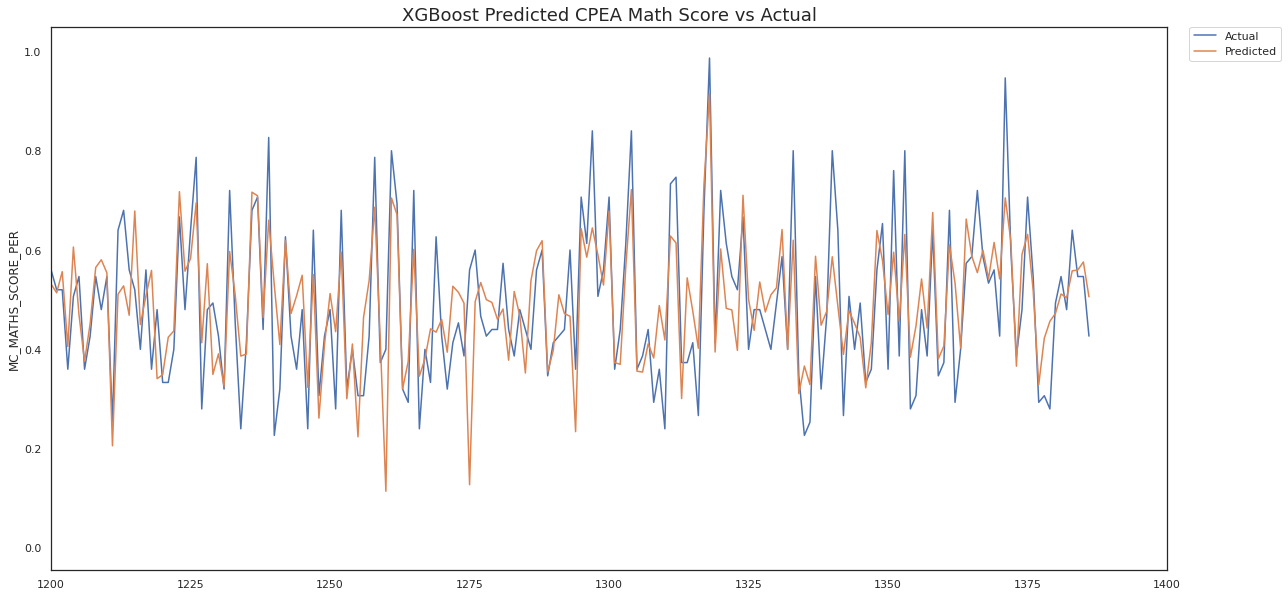

In [ ]:
#Plot XGBRegressor last 200 predictions
plt.rcParams["figure.figsize"] = (20,10)

sns.lineplot(x=range(0,len(y_test)),y=y_test,label = 'Actual')
sns.lineplot(x=range(0,len(y_test)),y=y_pred4, label = 'Predicted')


plt.xlim(left=1200,right=1400) 
plt.title("XGBoost Predicted CPEA Math Score vs Actual", fontsize=18)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.savefig('/content/drive/My Drive/Compiled Data /Plots/XGBoost Predicted CPEA Math Score vs Actual.png', bbox_inches='tight')
plt.show()


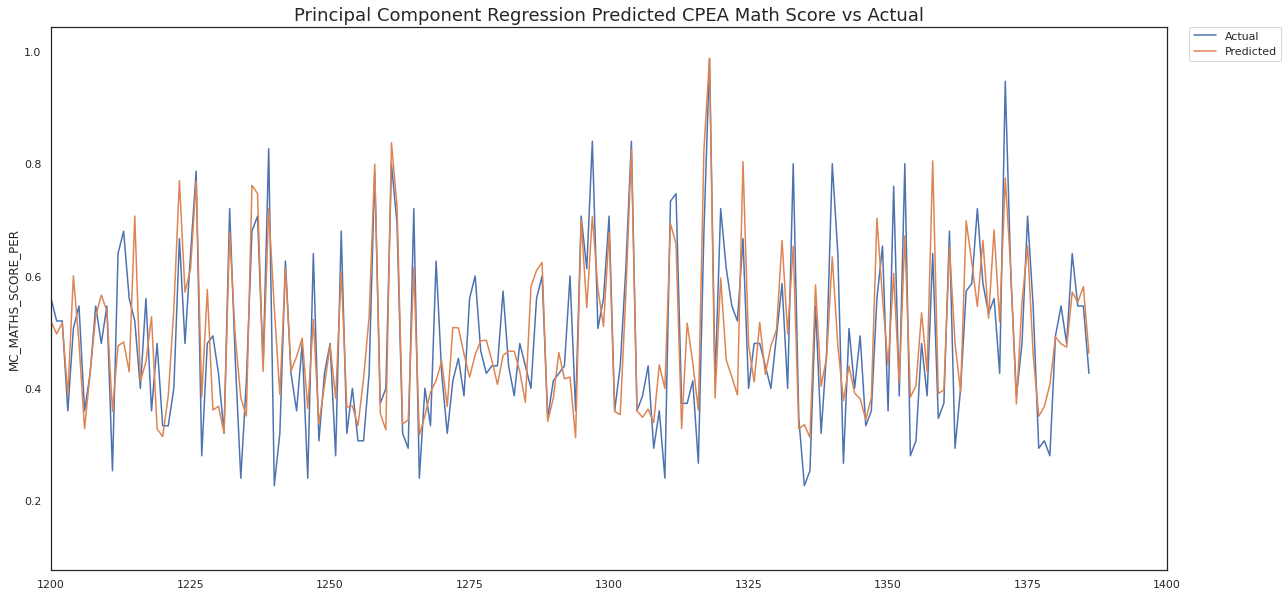

In [ ]:
#Plot PRC last 200 predictions
plt.rcParams["figure.figsize"] = (20,10)

sns.lineplot(x=range(0,len(y_test)),y=y_test,label = 'Actual')
sns.lineplot(x=range(0,len(y_test)),y=y_pred1, label = 'Predicted')

plt.xlim(left=1200,right=1400) 
plt.title("Principal Component Regression Predicted CPEA Math Score vs Actual", fontsize=18)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.savefig('/content/drive/My Drive/Compiled Data /Plots/PCR Predicted CPEA Math Score vs Actual.png', bbox_inches='tight')
plt.show()


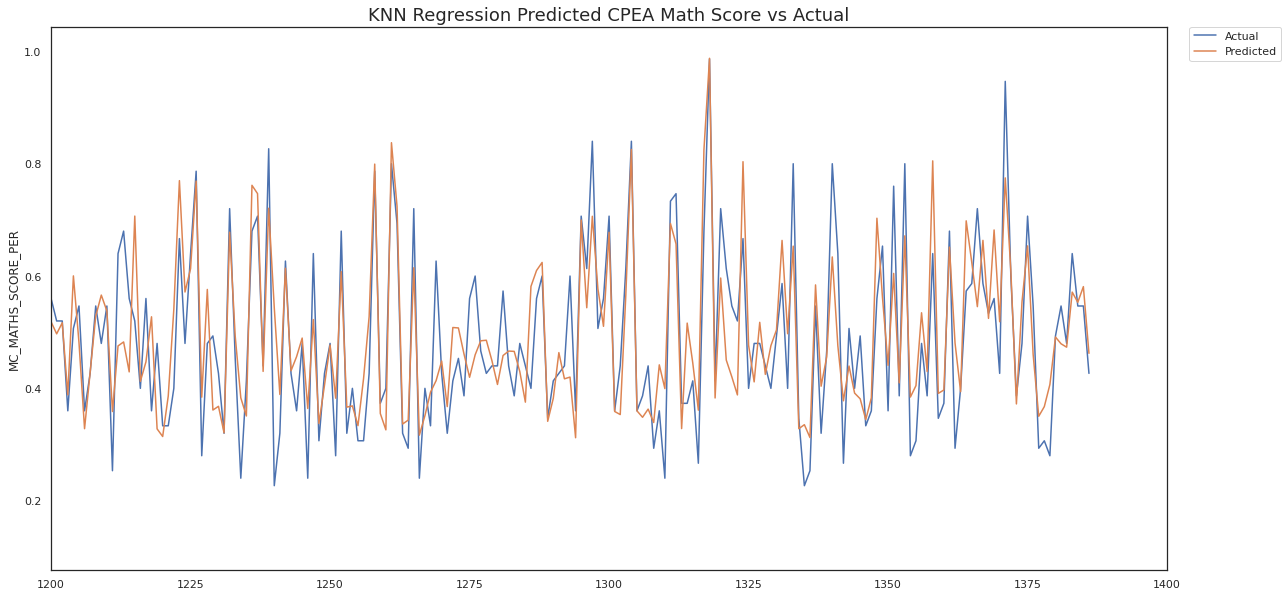

In [ ]:
#Plot KNN Regression last 200 predictions
plt.rcParams["figure.figsize"] = (20,10)

sns.lineplot(x=range(0,len(y_test)),y=y_test,label = 'Actual')
sns.lineplot(x=range(0,len(y_test)),y=y_pred2, label = 'Predicted')


plt.xlim(left=1200,right=1400) 
plt.title("KNN Regression Predicted CPEA Math Score vs Actual", fontsize=18)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('/content/drive/My Drive/Compiled Data /Plots/KNN Predicted CPEA Math Score vs Actual.png', bbox_inches='tight')
plt.show()


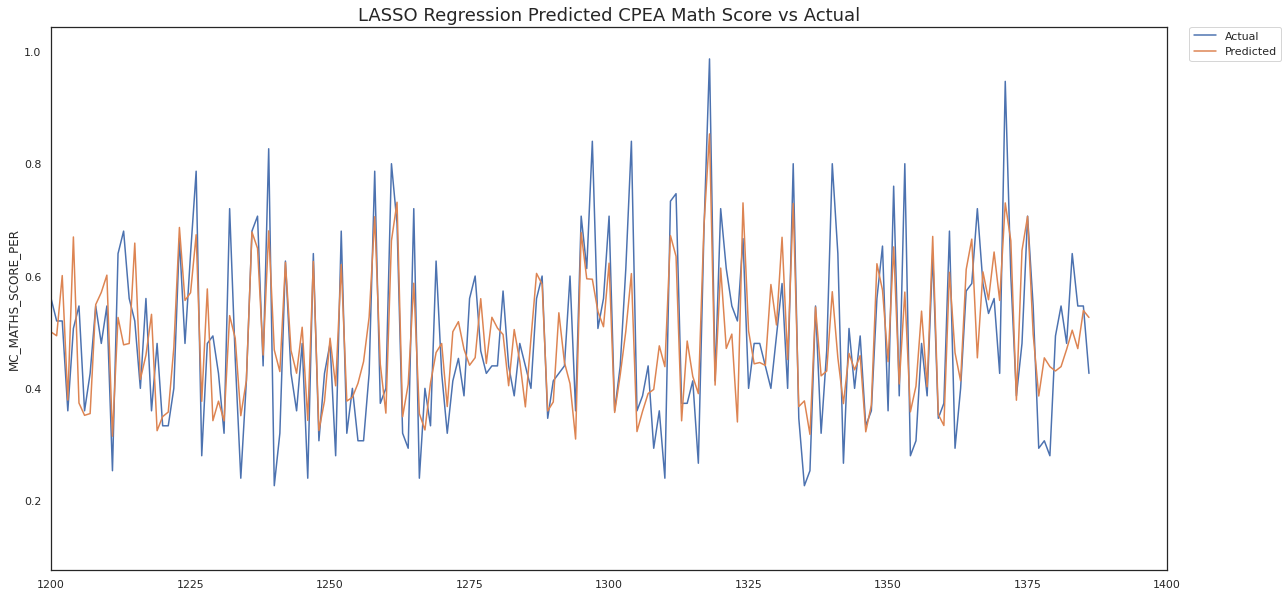

In [ ]:
#Plot LASSO last 200 predictions
plt.rcParams["figure.figsize"] = (20,10)

sns.lineplot(x=range(0,len(y_test)),y=y_test,label = 'Actual')
sns.lineplot(x=range(0,len(y_test)),y=y_pred3, label = 'Predicted')


plt.xlim(left=1200,right=1400) 
plt.title("LASSO Regression Predicted CPEA Math Score vs Actual", fontsize=18)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.savefig('/content/drive/My Drive/Compiled Data /Plots/LASSO Predicted CPEA Math Score vs Actual.png', bbox_inches='tight')
plt.show()


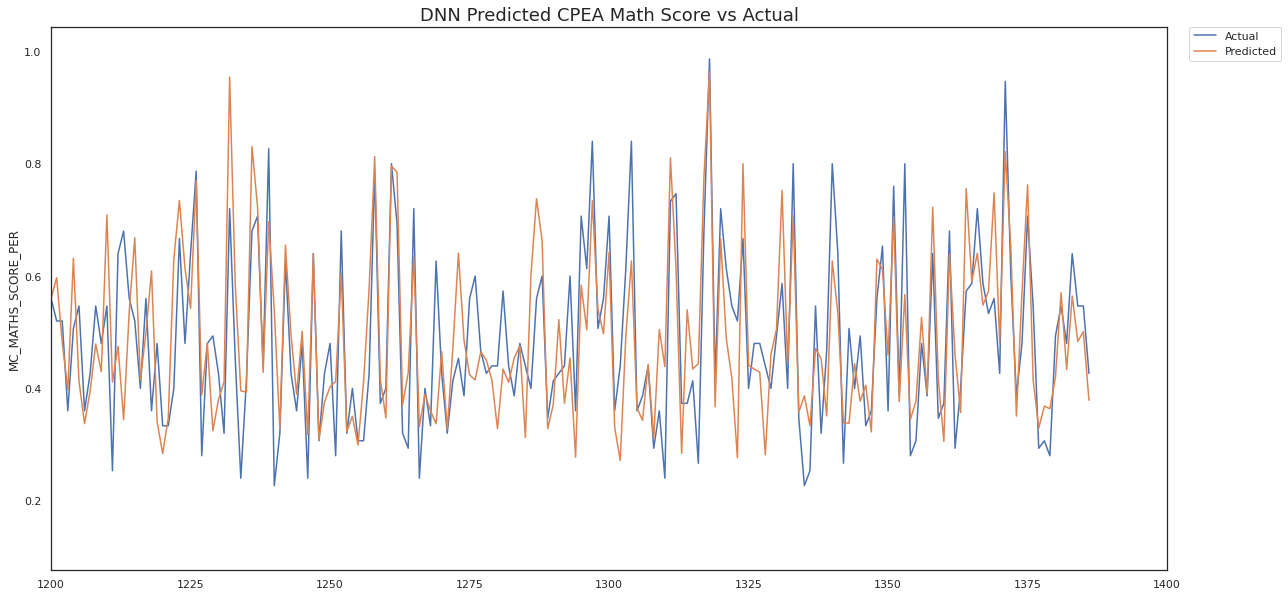

In [ ]:
#Plot DNN last 200 predictions
plt.rcParams["figure.figsize"] = (20,10)

sns.lineplot(x=range(0,len(y_test)),y=y_test,label = 'Actual')
sns.lineplot(x=range(0,len(y_test)),y=y_pred6.flatten(), label = 'Predicted')

plt.xlim(left=1200,right=1400) 
plt.title("DNN Predicted CPEA Math Score vs Actual", fontsize=18)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.savefig('/content/drive/My Drive/Compiled Data /Plots/DNN Predicted CPEA Math Score vs Actual.png', bbox_inches='tight')
plt.show()
